# UTKFace Age Prediction

In [1]:
# importing libraries
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, models
import pandas as pd
import os
from torchsummary import summary
from tqdm import tqdm
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
SEED = 3407
# setting random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
# torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#setting device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
print(device)

cuda


## Data PrePreocessing

In [3]:
# Extracting the data from the files
DIR_PATH = "/scratch/storage0/be20b032/Feature-Sieve-for-RL/UTKFace/Data/UTKFace"

data = {}
data['image'] = []
data['age'] = []
data['gender'] = []
data['ethinicity'] = []

for filename in os.listdir(DIR_PATH):
  f = os.path.join(DIR_PATH, filename)
  d = filename.split("_")

  if os.path.isfile(f) and len(d) == 4:
    data['image'].append(f)
    data['age'].append(int(d[0]))
    data['gender'].append(int(d[1]))
    data['ethinicity'].append(int(d[2]))

# Creating a dataframe to store the images and corresponding attributes
data_df = pd.DataFrame(data)
data_df.to_csv("./Data/data.csv")
TOTAL_PTS = len(data_df)
print(f"Total Data Pts: {TOTAL_PTS}")
data_df.head()

Total Data Pts: 23705


image  age  gender  ethinicity
0  /scratch/storage0/be20b032/Feature-Sieve-for-R...   28       0           3
1  /scratch/storage0/be20b032/Feature-Sieve-for-R...   90       0           0
2  /scratch/storage0/be20b032/Feature-Sieve-for-R...   25       0           1
3  /scratch/storage0/be20b032/Feature-Sieve-for-R...   36       1           1
4  /scratch/storage0/be20b032/Feature-Sieve-for-R...    1       1           2

In [4]:
#Paths
DIR_PATH = "/scratch/storage0/be20b032/Feature_Sieve-for-RL/UTKFace/Data/UTKFace"
DATA_PATH = './Data/data.csv'

#loading the dataset
data_df = pd.read_csv(DATA_PATH)
TOTAL_PTS = len(data_df)

# Spliting the dataset
TRAIN_PTS = int(0.6 * TOTAL_PTS)
TEST_PTS = int(0.2 *  TOTAL_PTS)

#Shuffling the Dataframe
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df = data_df.drop("Unnamed: 0", axis = 1)

train_df = data_df[:TRAIN_PTS].reset_index(drop=True)
test_df = data_df[TRAIN_PTS: TRAIN_PTS + TEST_PTS].reset_index(drop=True)
val_df = data_df[TRAIN_PTS + TEST_PTS: ].reset_index(drop=True)

print(f"Number of Total Data Points: {len(data_df)}")
print(f"Number of Training Data Points: {len(train_df)}")
print(f"Number of Test Data Points: {len(test_df)}")
print(f"Number of Validation Data Points: {len(val_df)}")

Number of Total Data Points: 23705
Number of Training Data Points: 14223
Number of Test Data Points: 4741
Number of Validation Data Points: 4741


## Custom Dataset

In [5]:
# Custom Dataset
class UTKFaceDataset(Dataset):
  def __init__(self, dataframe, image_dir, transform=None):
    self.image_dir = image_dir
    self.df = dataframe
    self.images = dataframe['image'].values
    self.y = dataframe['age'].values
    self.gender = dataframe['gender'].values
    self.eth = dataframe['ethinicity'].values
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.images[index])

    if self.transform is not None:
      img = self.transform(img)

    label = self.y[index]
    gender = self.gender[index]
    return img, label, gender

  def __len__(self):
    return self.y.shape[0]

In [6]:
#Seggregating male and female data points for biasing
male_df = train_df[train_df['gender'] == 0].reset_index(drop=True)
female_df = train_df[train_df['gender'] == 1].reset_index(drop=True)

print(f"Male data pts: {len(male_df)}")
print(f"Female data pts: {len(female_df)}")

Male data pts: 7448
Female data pts: 6775


In [7]:
print(male_df.age.values.mean())
print(female_df.age.values.mean())

35.77295918367347
30.512177121771217


<Axes: >

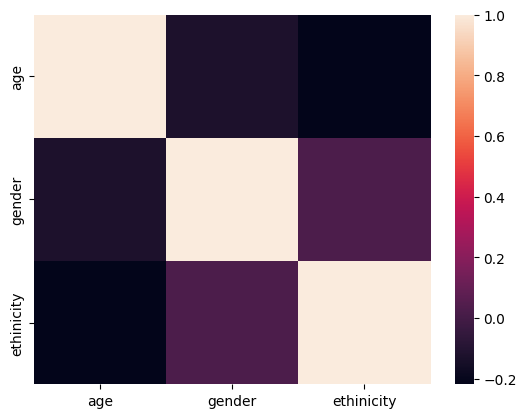

In [8]:
corr_df = data_df.drop("image", axis = 1)
sns.heatmap(corr_df.corr())

## Dataset Generation 1

In [9]:
# Creating dataframes
ages = list(data_df.age.unique())
ages = sorted(ages)

def dataframe(male_df, female_df, total_datapts = 5000, percent = 0.5, thresh = 50, old = "male"):
  MALE_POP = int(percent * total_datapts)
  FEMALE_POP = int((1-percent) * total_datapts)
  print(MALE_POP, FEMALE_POP)

  if old == "male":
    male_datapts = male_df[male_df["age"] > thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] < thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]



  else:
    male_datapts = male_df[male_df["age"] < thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] > thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]

  print(f"Male Population: {len(male_datapts)}/{len(male_datapts) + len(female_datapts)}; Female Population: {len(female_datapts)}/{len(male_datapts) + len(female_datapts)}")
  datapts = [male_datapts, female_datapts]
  datapts = pd.concat(datapts)
  datapts = datapts.sample(frac=1).reset_index(drop=True)
  return datapts

2500 2500
5574 2404
Male Population: 2500/5000; Female Population: 2500/5000


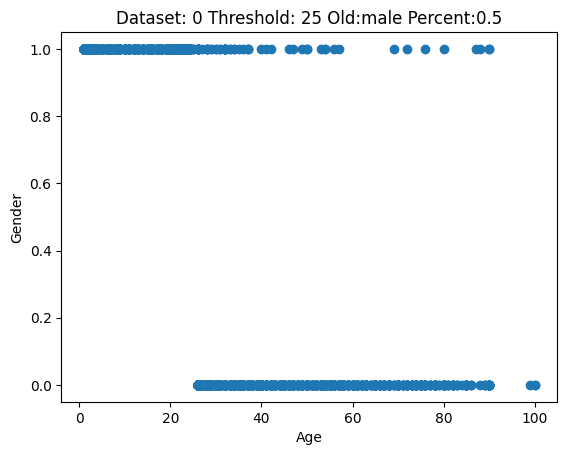

2500 2500
1263 5188
Male Population: 2500/5000; Female Population: 2500/5000


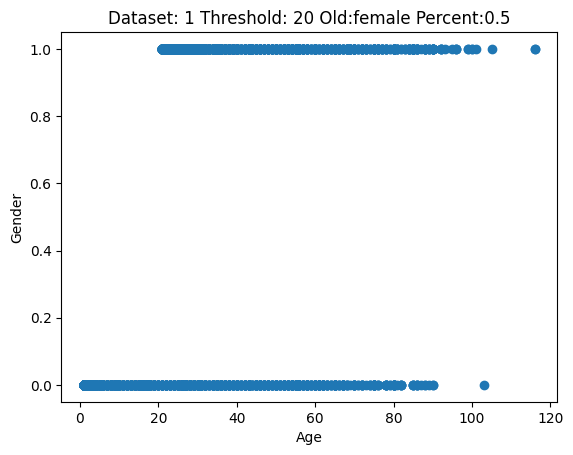

2500 2500
5893 1883
Male Population: 2500/5000; Female Population: 2500/5000


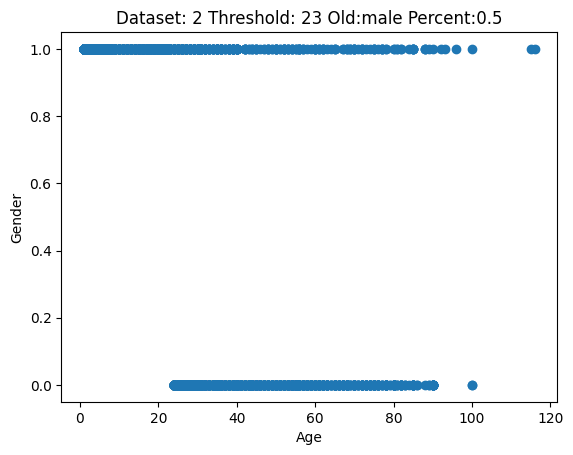

3500 1500
1471 4721
Male Population: 3500/5000; Female Population: 1500/5000


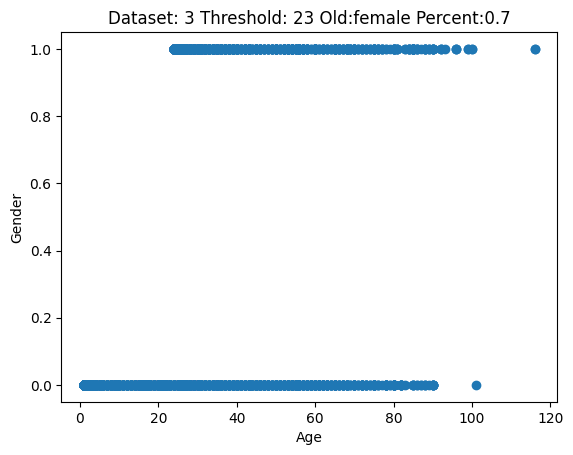

4000 999
5574 2404
Male Population: 4000/4999; Female Population: 999/4999


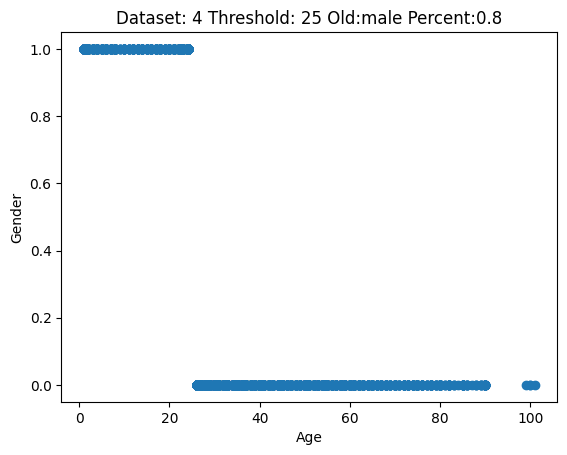

1000 4000
2453 3171
Male Population: 1000/5000; Female Population: 4000/5000


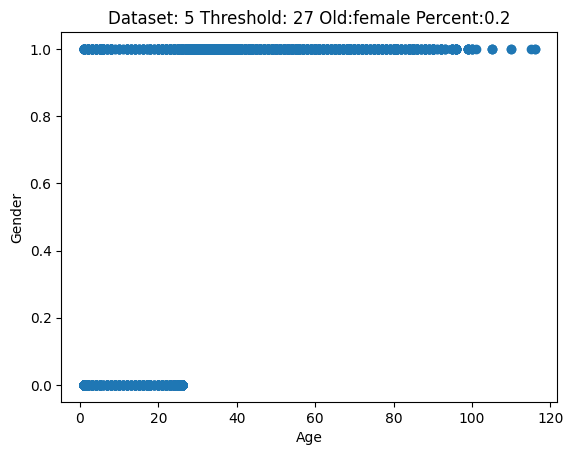

1500 3500
2874 5212
Male Population: 1500/5000; Female Population: 3500/5000


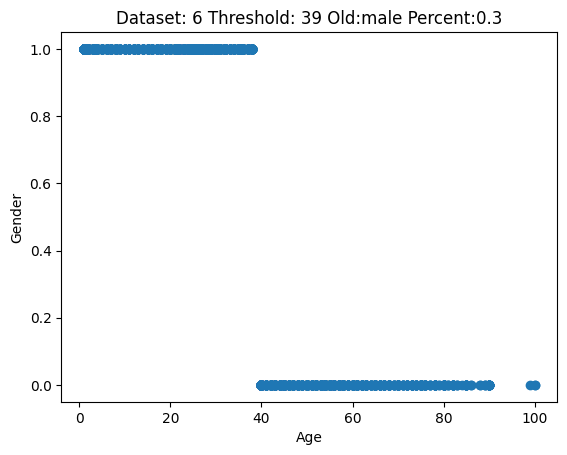

2500 2500
4838 1294
Male Population: 2500/5000; Female Population: 2500/5000


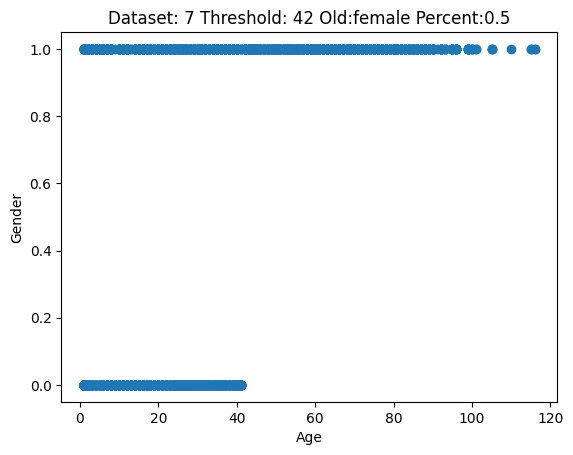

4000 999
2503 5426
Male Population: 4000/4999; Female Population: 999/4999


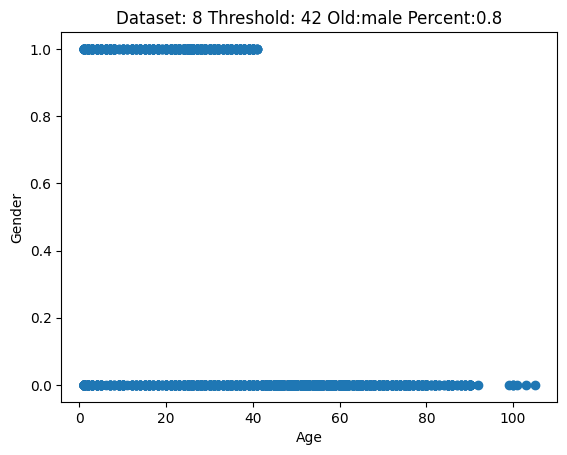

2000 3000
3103 2505
Male Population: 2000/5000; Female Population: 3000/5000


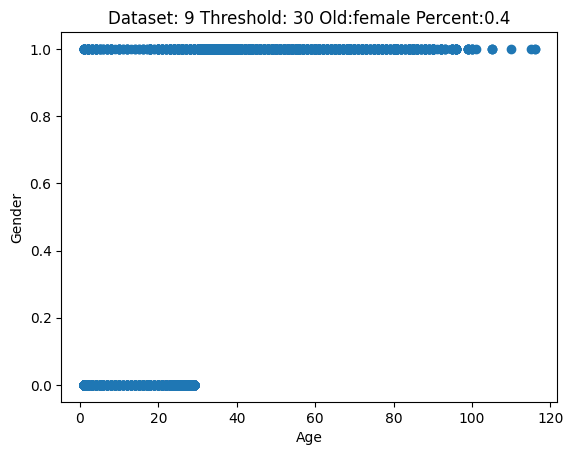

In [10]:
#Creating Datasets using Gen1 Dataframe
threshs = [25, 20, 23, 23, 25, 27, 39, 42, 42, 30]
olds = ["male", "female", "male", "female", "male", "female", 'male', 'female', 'male', 'female']
percents = [0.5, 0.5, 0.5, 0.7, 0.8, 0.2, 0.3, 0.5, 0.8, 0.4]
dfs = []

for i in range(len(threshs)):
    df = dataframe(male_df, female_df, thresh=threshs[i], old=olds[i], percent=percents[i])
    df.to_csv(f"./Datasets/Gen1/train_df{i}.csv")
    dfs.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Threshold: {threshs[i]} Old:{olds[i]} Percent:{percents[i]}")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.savefig(f"./Datasets/Gen1/Dataset{i}.png")
    plt.show()

## Dataset Generation 2

In [11]:
#Creating Dataframes using normal distribution
def dataframe_gen2(male_df, female_df, percent, male_mean, female_mean, male_var, female_var, total_datapts=5000):
    MALE_POP = int(percent * total_datapts)
    FEMALE_POP = int((1-percent) * total_datapts)
    print(MALE_POP, FEMALE_POP)

    male_age = np.sort(male_df.age)
    male_fx = np.exp(-1*(male_age - male_mean)**2 / (2*male_var)) / np.sqrt(2*np.pi*male_var)
    male_sample_probs = male_fx 

    female_age = np.sort(female_df.age)
    female_fx = np.exp(-1*(female_age - female_mean)**2 / (2*female_var)) / np.sqrt(2*np.pi*female_var)
    female_sample_probs = female_fx

    female_df_sorted = female_df.sort_values("age")
    male_df_sorted = male_df.sort_values("age")
    female_datapts = female_df_sorted.sample(n=FEMALE_POP, weights=female_sample_probs, replace=False)
    male_datapts = male_df_sorted.sample(n=MALE_POP, weights=male_sample_probs, replace=False)

    df = [male_datapts, female_datapts]
    df = pd.concat(df)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

3000 2000
24.582666666666668
44.048
image         5000
age             64
gender           2
ethinicity       5
dtype: int64


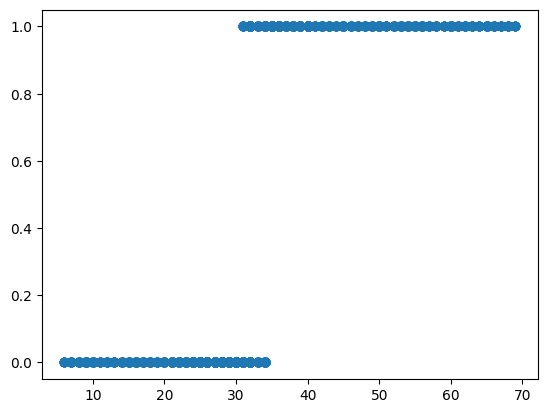

In [12]:
# Testing Dataset Gen2
dataset_1 = dataframe_gen2(male_df, female_df, percent=0.6, male_mean=20, female_mean=50, male_var=1, female_var=1)
dataset_1_male = dataset_1[dataset_1["gender"]==0]
dataset_1_female = dataset_1[dataset_1["gender"]==1]
print(dataset_1_male.age.values.mean())
print(dataset_1_female.age.values.mean())

print(dataset_1.nunique())
plt.scatter(dataset_1.age.values, dataset_1.gender.values)
plt.show()

4000 999


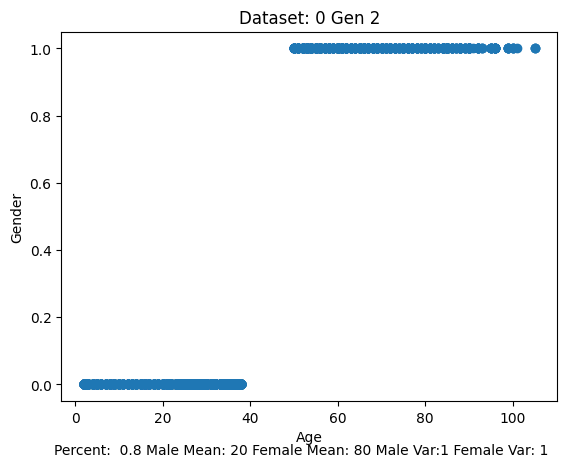

2500 2500


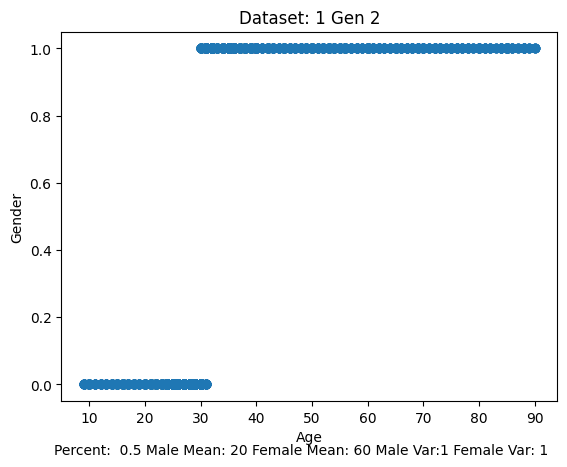

3000 2000


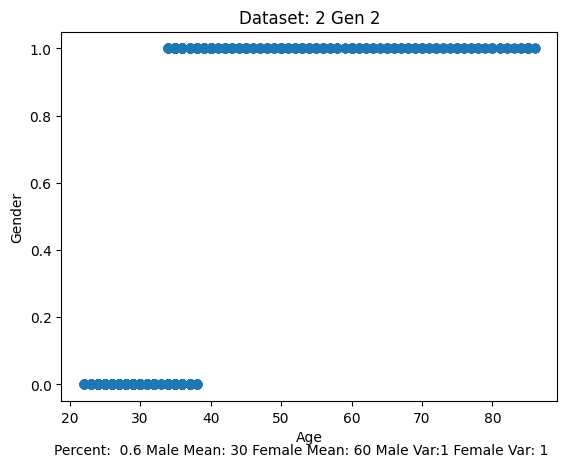

2500 2500


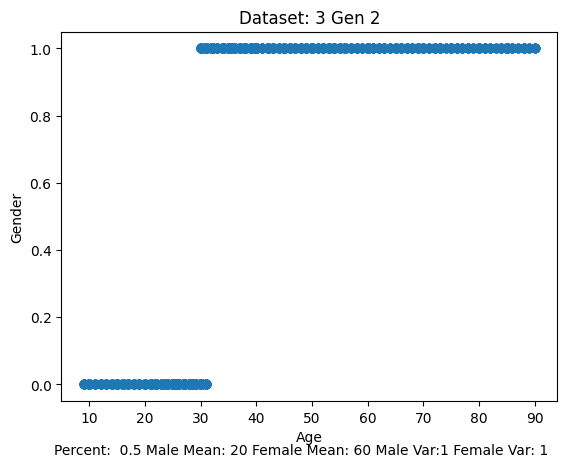

2000 3000


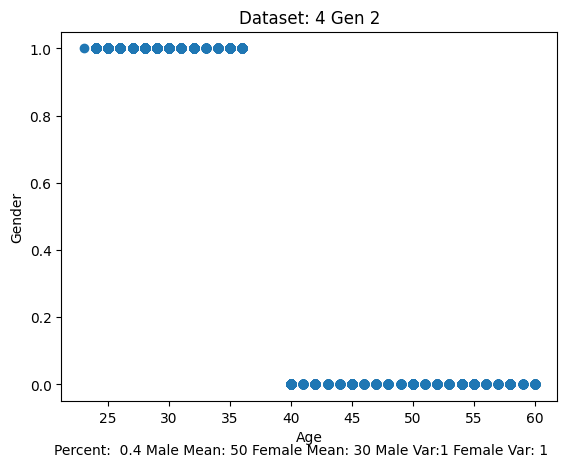

2000 3000


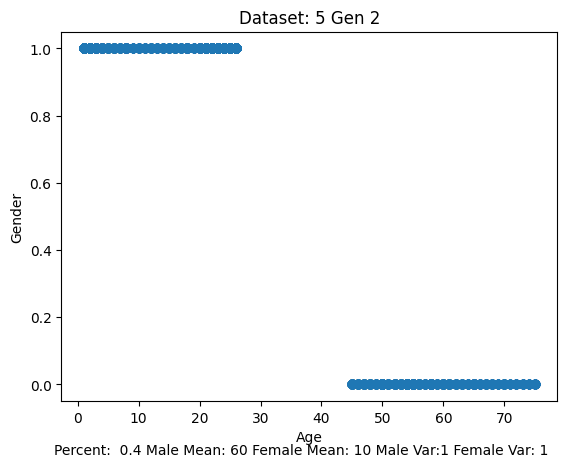

4000 999


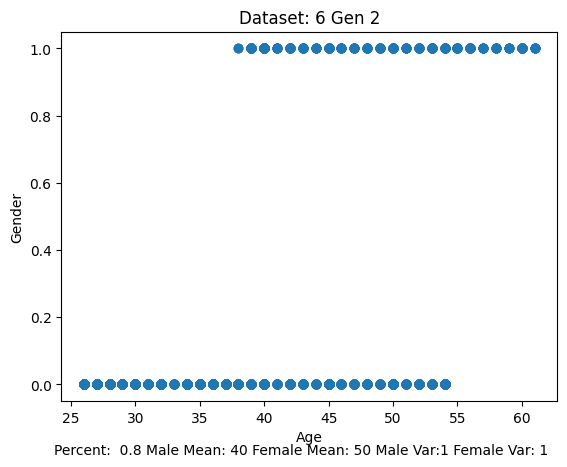

4000 999


1000 4000


3000 2000


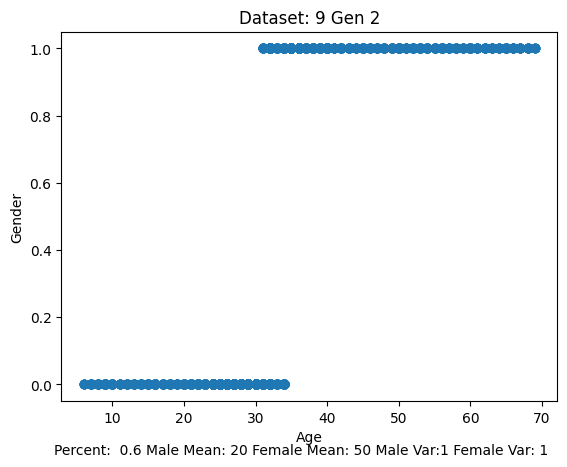

In [13]:
#Creating Dataframes using Gen2
percents = [0.8, 0.5, 0.6, 0.5, 0.4, 0.4, 0.8, 0.8, 0.2, 0.6]
male_means = [20, 20, 30, 20, 50, 60, 40, 30, 40, 20]
female_means = [80, 60, 60, 60, 30, 10, 50, 80, 50, 50]
male_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
female_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

dfs_gen2 = []
for i in range(len(percents)):
    df = dataframe_gen2(male_df, female_df, percent=percents[i], male_mean=male_means[i], female_mean=female_means[i], male_var=male_vars[i], female_var=female_vars[i])
    df.to_csv(f"./Datasets/Gen2/train_df{i}.csv")
    dfs_gen2.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Gen 2")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.figtext(0.5, 0.0001, f"Percent:  {percents[i]} Male Mean: {male_means[i]} Female Mean: {female_means[i]} Male Var:{male_vars[i]} Female Var: {female_vars[i]}", wrap=True, horizontalalignment='center', fontsize=10)
    plt.savefig(f"./Datasets/Gen2/Dataset{i}.png")
    plt.show()

## Datasets and Dataloaders

In [14]:
## acquiring the datasets
dfs_gen2 = []
for i in range(10):
    dfs_gen2.append(pd.read_csv(f"./Datasets/Gen2/train_df{i}.csv"))

In [15]:
# Datasets and Dataloaders
##Datasets
NUM_TRAIN_DATASETS = len(dfs_gen2)
BATCH_SIZE = 128

custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

test_dataset = UTKFaceDataset(dataframe = test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)

val_dataset = UTKFaceDataset(dataframe = val_df,
                             image_dir = DIR_PATH,
                             transform = custom_transform)

TEST_SIZE = len(test_dataset)

train_datasets = []
train_dataloaders = []
for i in range(NUM_TRAIN_DATASETS):
  train_dataset = UTKFaceDataset(dataframe = dfs_gen2[i],
                                 image_dir= DIR_PATH,
                                 transform = custom_transform)

  train_dataloader = DataLoader(dataset = train_dataset,
                                batch_size = BATCH_SIZE,
                                shuffle = True)

  train_dataloaders.append(train_dataloader)
  train_datasets.append(train_dataset)

##Dataloaders
test_dataloader = DataLoader(dataset = test_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = True)

In [16]:
# Training Dataset and Dataloader
comp_train_dataset = UTKFaceDataset(dataframe=train_df,
                                   image_dir = DIR_PATH,
                                   transform = custom_transform)
comp_train_dataloader = DataLoader(dataset = comp_train_dataset,
                                   batch_size = BATCH_SIZE,
                                  shuffle = True)

## Dataset Visualization

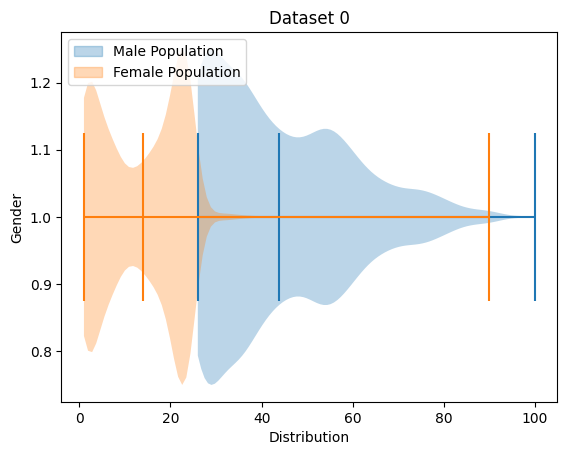

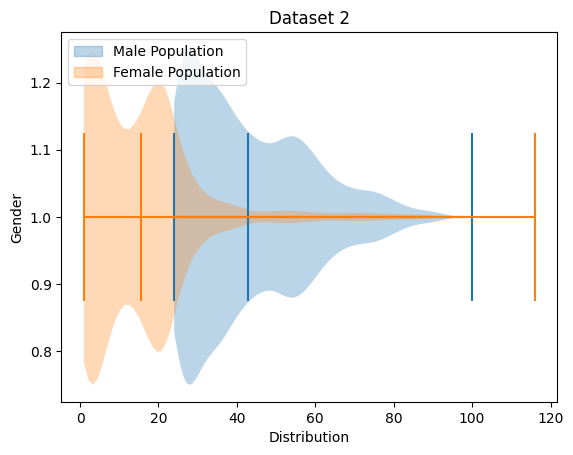

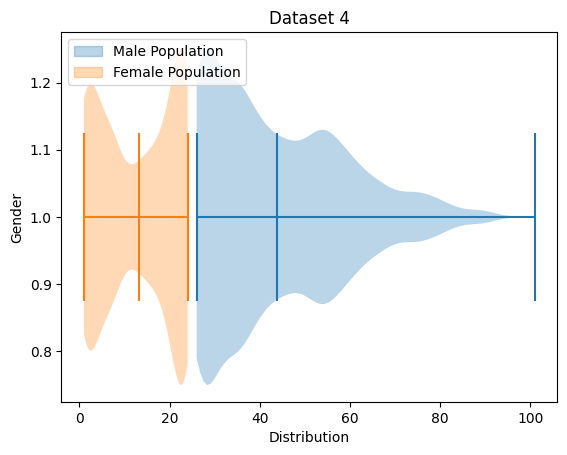

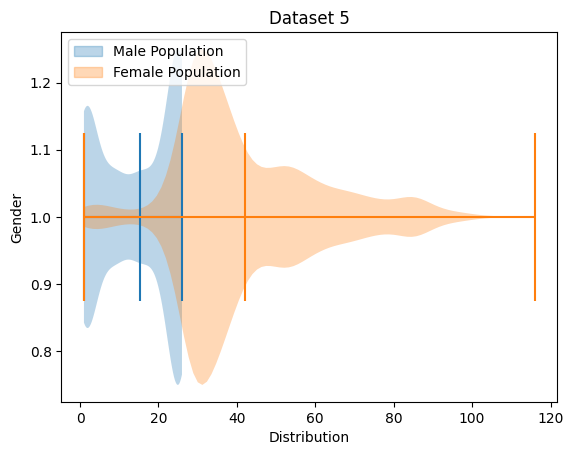

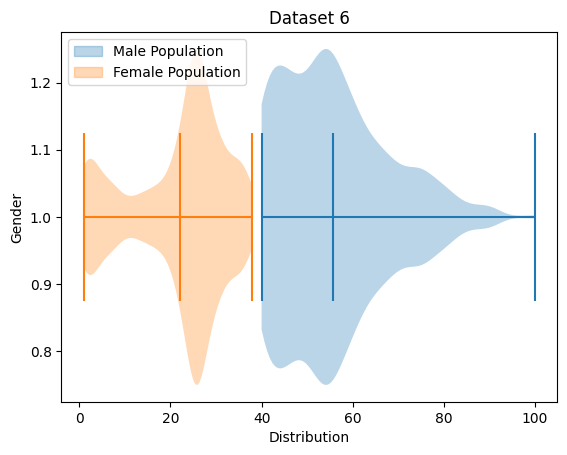

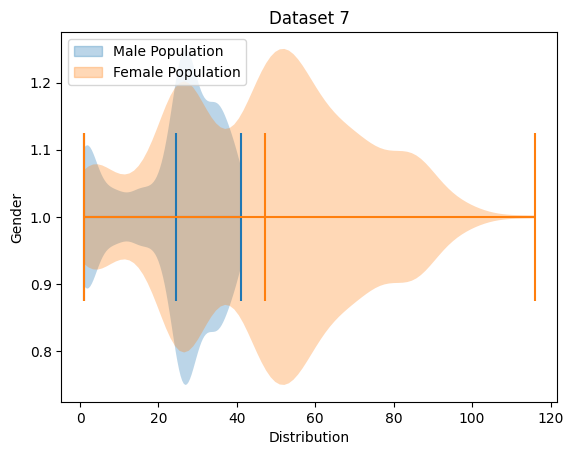

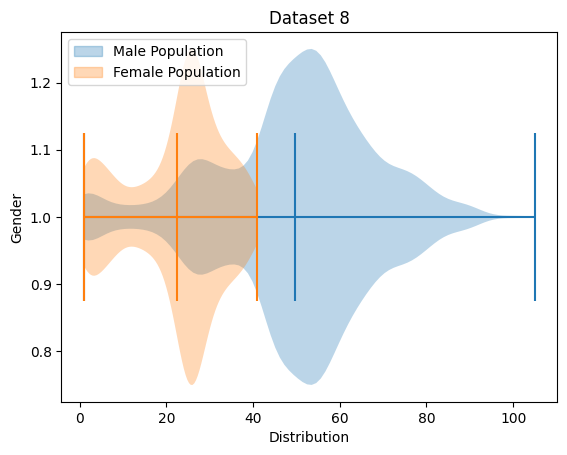

In [17]:
## Dataset Gen1 
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color = color), label))

for i in range(len(dfs)):
    labels  = []
    df = dfs[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop = True)
    
    add_label(plt.violinplot(male_df.age, vert = False, showmeans = True), "Male Population")
    add_label(plt.violinplot(female_df.age, vert = False, showmeans = True), "Female Population")
    plt.xlabel("Distribution")
    plt.ylabel("Gender")
    plt.legend(*zip(*labels), loc = 2)
    plt.title(f"Dataset {i}")
    plt.savefig(f"./Datasets/Gen1/dataset_dist{i}.png")
    plt.show()

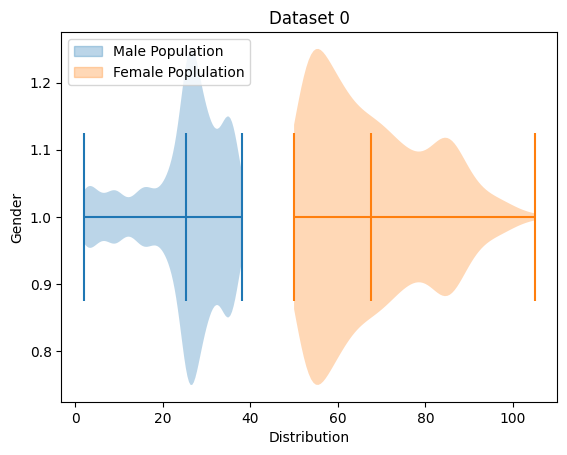

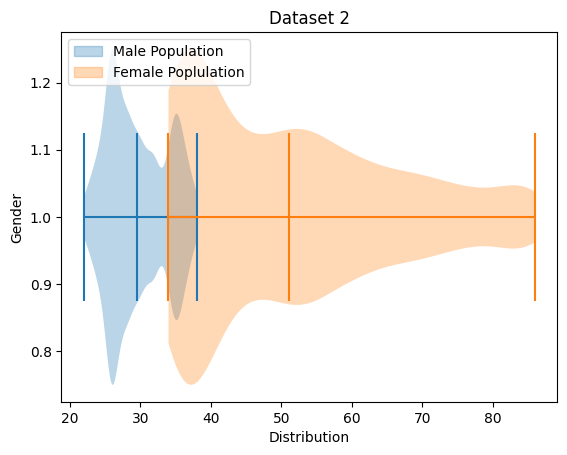

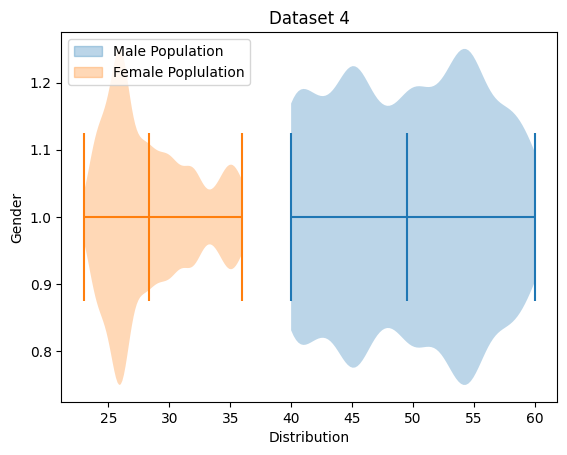

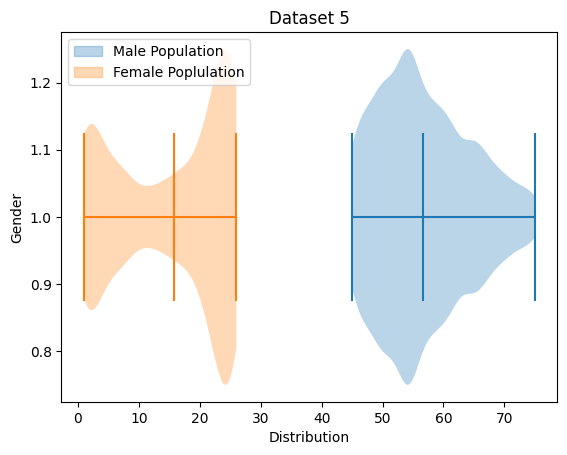

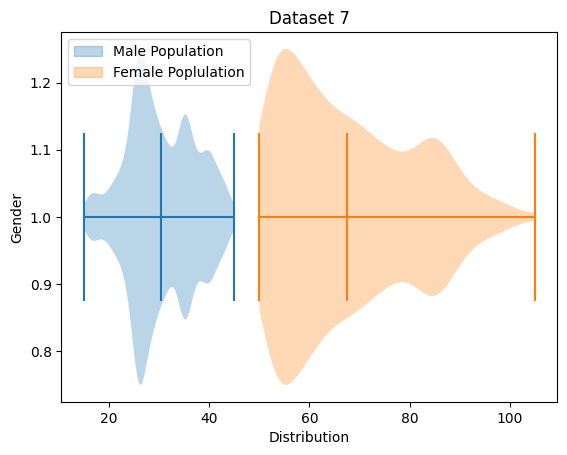

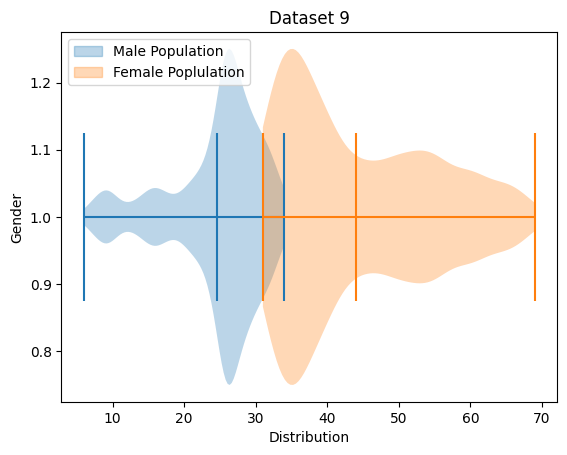

In [18]:
# Dataset Gen 2
for i in range(len(dfs_gen2)):
    labels = []
    df = dfs_gen2[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop = True)
    
    add_label(plt.violinplot(male_df.age, vert = False, showmeans = True), "Male Population")
    add_label(plt.violinplot(female_df.age, vert = False, showmeans = True), "Female Poplulation")
    plt.xlabel("Distribution")
    plt.ylabel("Gender")
    plt.legend(*zip(*labels), loc = 2)
    plt.title(f"Dataset {i}")
    plt.savefig(f"./Datasets/Gen2/dataset_dist{i}.png")
    plt.show()

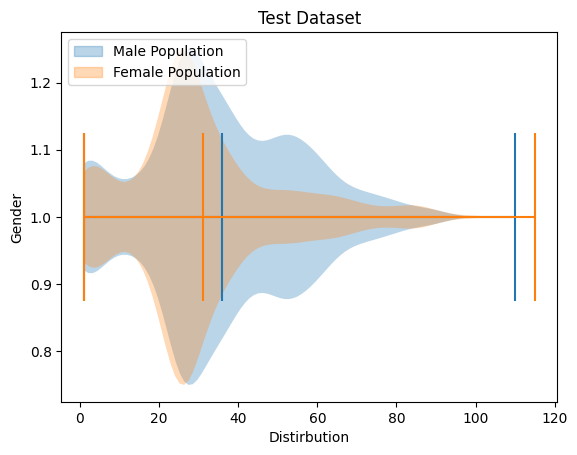

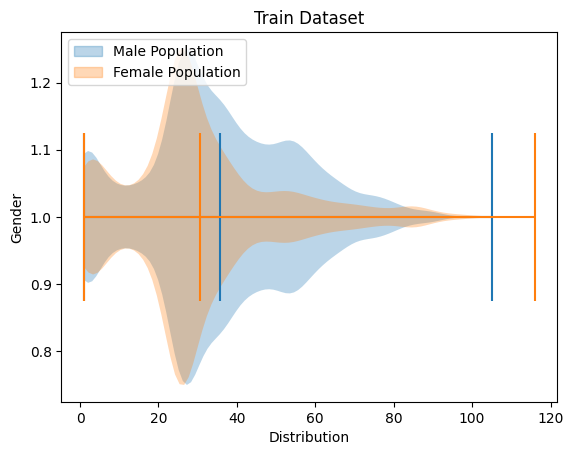

In [19]:
#Plotting distribution of test dataset
labels = []
male_test_df = test_df[test_df.gender == 0].age.values
female_test_df = test_df[test_df.gender == 1].age.values
add_label(plt.violinplot(male_test_df, vert = False, showmeans = True), "Male Population")
add_label(plt.violinplot(female_test_df, vert = False, showmeans = True), "Female Population")
plt.xlabel("Distirbution")
plt.ylabel("Gender")
plt.title("Test Dataset")
plt.legend(*zip(*labels), loc = 2)
plt.savefig("./Datasets/test_distribution.png")
plt.show()

labels = []
male_train_df = train_df[train_df.gender == 0].age.values
female_train_df = train_df[train_df.gender == 1].age.values
add_label(plt.violinplot(male_train_df, vert=False, showmeans = True), "Male Population")
add_label(plt.violinplot(female_train_df, vert = False, showmeans= True), "Female Population")
plt.xlabel("Distribution")
plt.ylabel("Gender")
plt.legend(*zip(*labels), loc = 2)
plt.title("Train Dataset")
plt.savefig("./Datasets/train_distribution.png")
plt.show()

## Bias analysis of Different datasets

In [20]:
## KL Divergence between different training and full training datasets
def prob_gen(df, column = 'age'):
    values = df[column]
    count, division = np.histogram(values, bins = max(ages), range = (min(ages), max(ages)))
    count += 1
    probs = count / count.sum()
    return probs
    
def KLDivergence(df1, df2):
    prob1 = prob_gen(df1)
    prob2 = prob_gen(df2)

    return sum(prob1[i]*np.log(prob1[i] / prob2[i]) for i in range(len(prob1)))

In [21]:
dist_distances = []
datasets = [f"Training {i}" for i in range(len(dfs_gen2))]
datasets.insert(0, "Full Dataset")
datasets.insert(1, "No Bias")

dist_full = KLDivergence(train_df, data_df)
dist_nb = KLDivergence(train_df_nb, data_df)
dist_distances.append(dist_full)
dist_distances.append(dist_nb)

for df in dfs_gen2:
    dist_distance = KLDivergence(df, data_df)
    dist_distances.append(dist_distance)
    
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({"font.size":10})
plt.bar(datasets, dist_distances, width = 0.4)
plt.xlabel("Datasets")
plt.ylabel("KL Divergence Values")
plt.title("Distances between Datasets and Full Dataset")
plt.show()

NameError: name 'train_df_nb' is not defined

In [ ]:
## plotting correlation values between age and gender
corr_values = []
corr_full = train_df.corr(numeric_only = True).loc['age', 'gender']
corr_values.append(corr_full)
corr_nb = train_df_nb.corr(numeric_only = True).loc['age', 'gender']
corr_values.append(corr_nb)

for df in dfs_gen2:
    corr = df.corr(numeric_only = True).loc['age', 'gender']
    corr_values.append(corr)

corr_values = np.array(corr_values)
corr_abs = np.abs(corr_values)
corr_sign = np.sign(corr_values)

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({"font.size":10})
plt.bar(datasets, corr_abs, width = 0.4)
plt.xlabel("Datasets")
plt.ylabel('Correlation')
plt.title("Age - Gender Correlation")
plt.show()

### Correlation Analysis

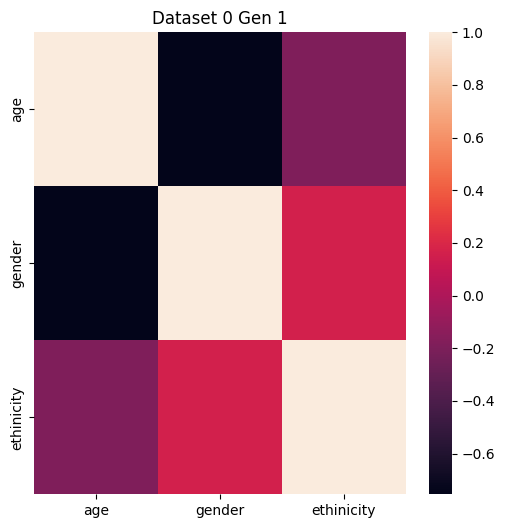

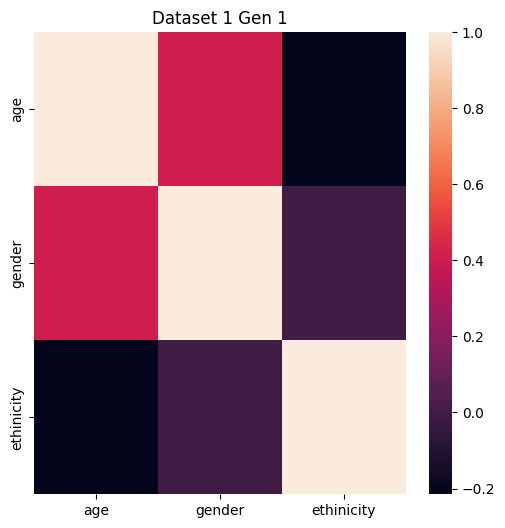

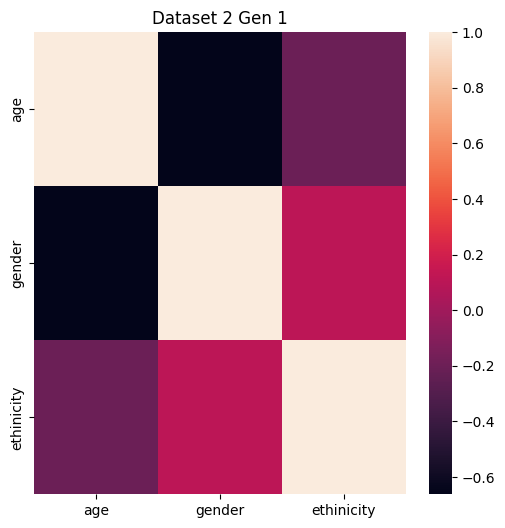

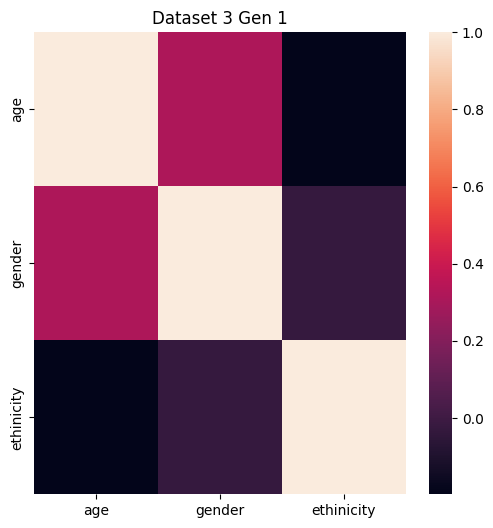

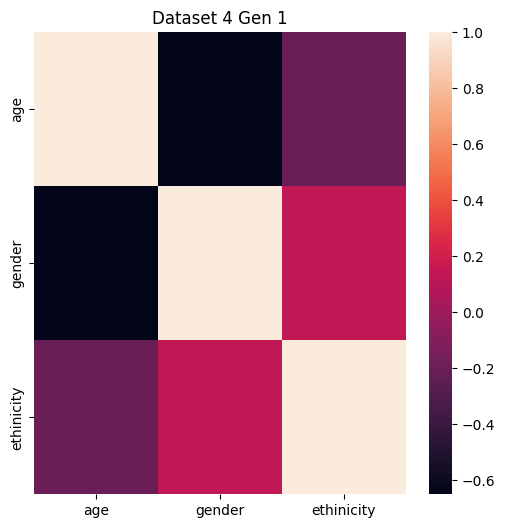

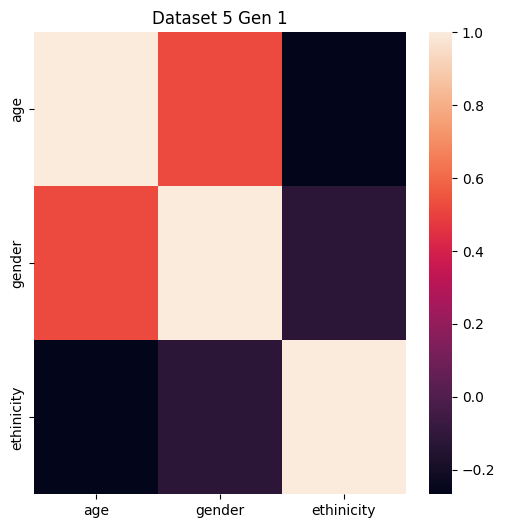

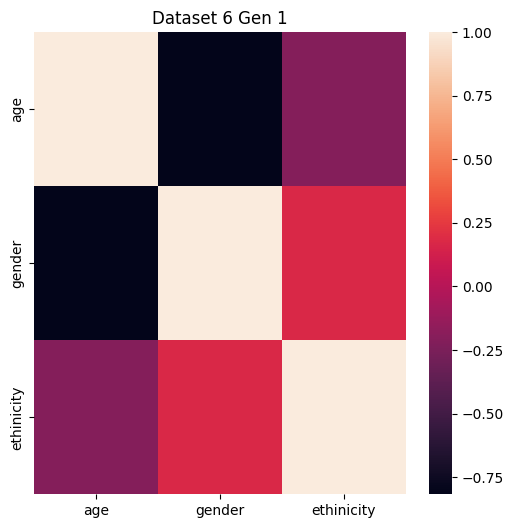

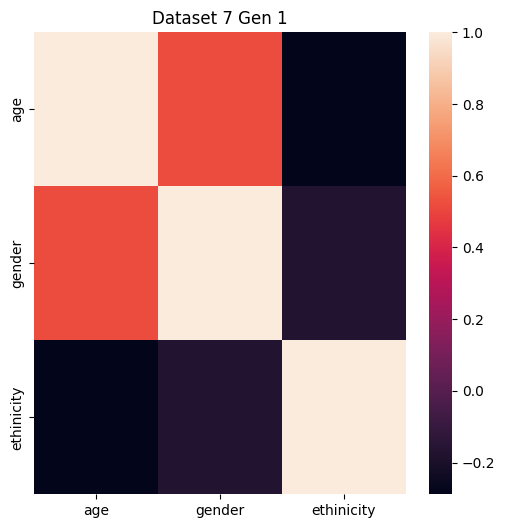

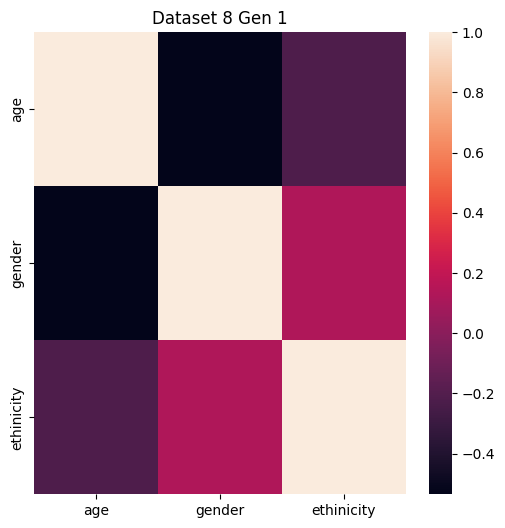

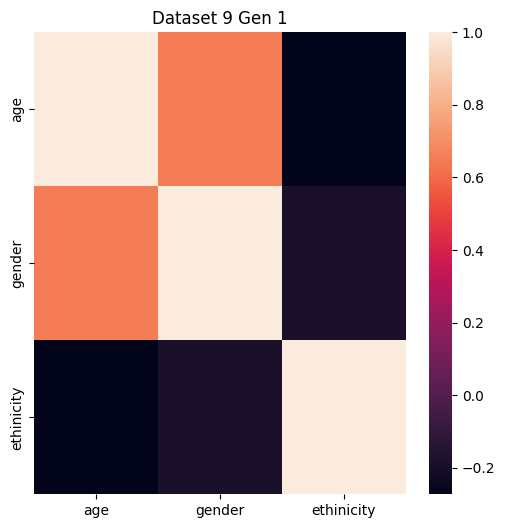

In [22]:
plt.rcParams["figure.figsize"] = (6,6)
for i in range(len(dfs)):
    df = dfs[i]
    sns_plot = sns.heatmap(df.drop("image", axis = 1).corr()).set(title = f"Dataset {i} Gen 1")
    plt.savefig(f"./Datasets/Gen1/Correlations/Dataset{i}.png")
    plt.show()

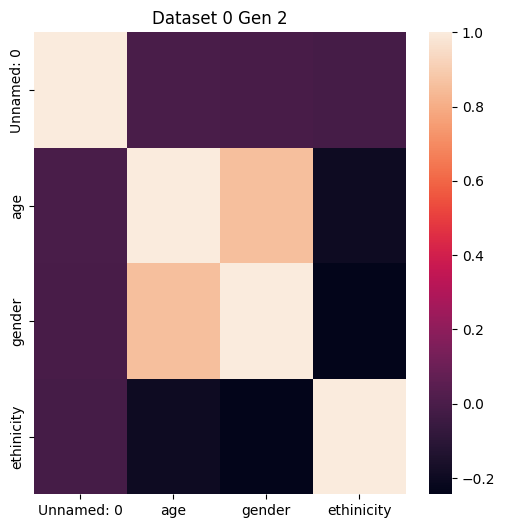

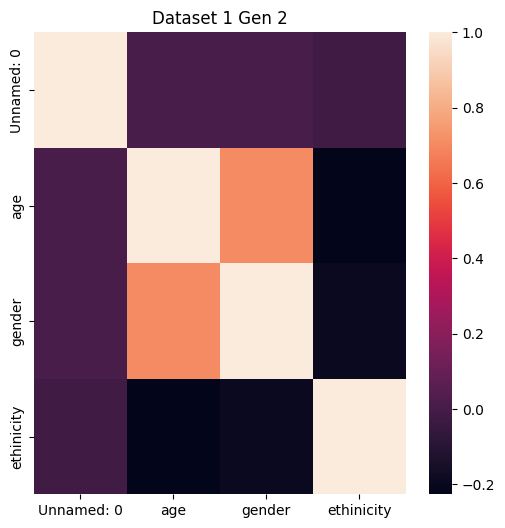

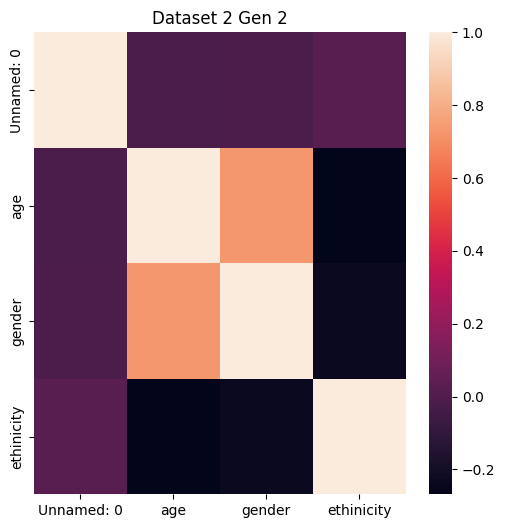

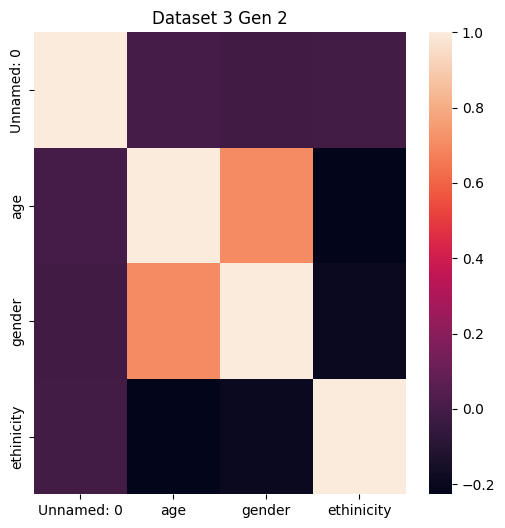

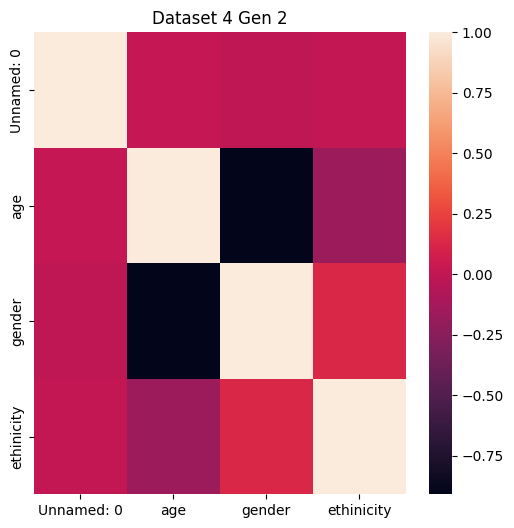

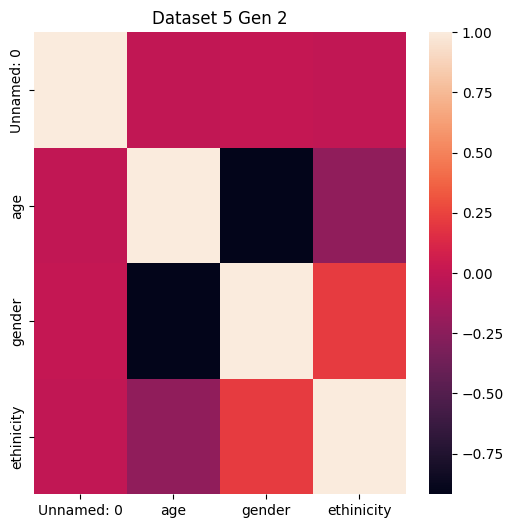

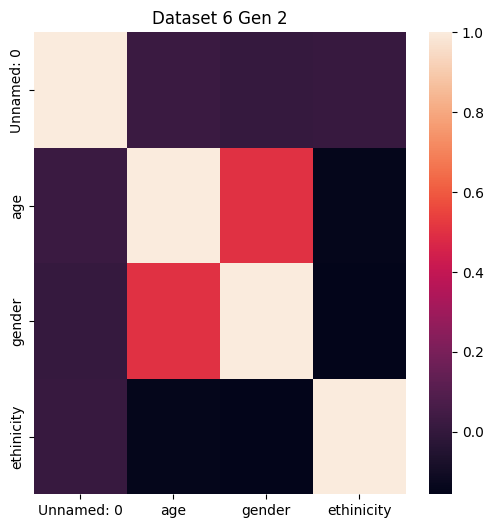

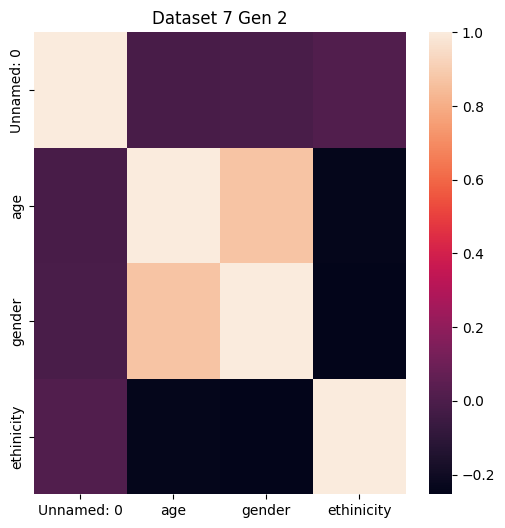

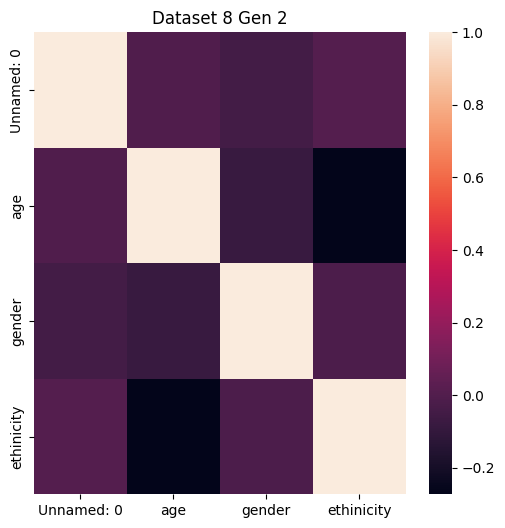

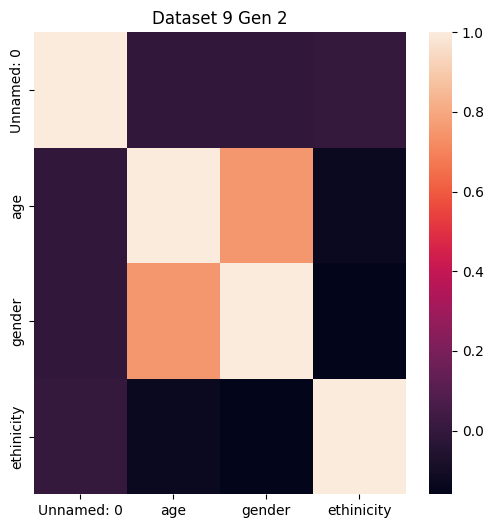

In [23]:
for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    sns_plot = sns.heatmap(df.drop("image", axis= 1).corr()).set(title = f"Dataset {i} Gen 2")
    plt.savefig(f"./Datasets/Gen2/Correlations/Dataset{i}.png")
    plt.show()

## Bayesian Loss Limit

Calculating the errors of a Bayesian Regression Model which just uses Gender make predictions

Training Dataset0, Test Loss: 1092.4584838764613
Training Dataset1, Test Loss: 597.0321819037645
Training Dataset2, Test Loss: 603.7046124533149
Training Dataset3, Test Loss: 597.5105508690909
Training Dataset4, Test Loss: 485.6845300964384
Training Dataset5, Test Loss: 722.2775386245843
Training Dataset6, Test Loss: 540.1811195491607
Training Dataset7, Test Loss: 1049.055338561481
Training Dataset8, Test Loss: 410.6444870300542
Training Dataset9, Test Loss: 535.0255984796779
Full Trainig Dataset: 387.754931361136


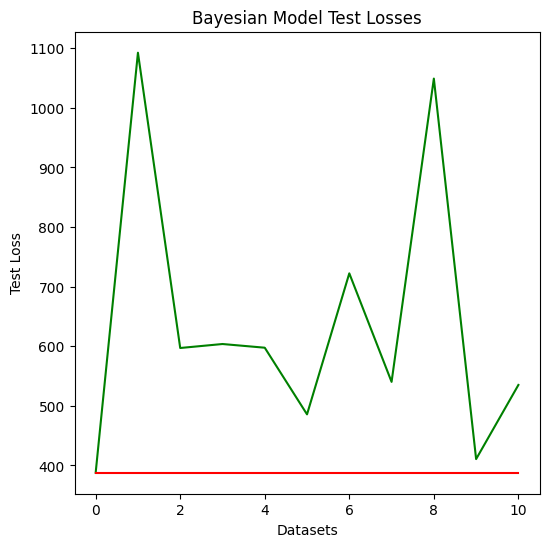

In [24]:
import sklearn
from sklearn import linear_model

test_losses_bayesian = []

for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    
    x = df.gender.values
    x = x.reshape(-1,1)
    y = df.age.values

    #Bayesian Regression Model
    reg = linear_model.BayesianRidge()
    reg.fit(x, y)

    #Error Calculations
    x_test = test_df.gender.values
    x_test = x_test.reshape(-1,1)
    y_test = test_df.age.values

    y_pred = reg.predict(x_test)
    Loss = (np.square(y_test - y_pred)).mean()
    test_losses_bayesian.append(Loss)

    print(f"Training Dataset{i}, Test Loss: {Loss}")

#Bayesian on full dataset
x,y = train_df.gender.values, train_df.age.values
x = x.reshape(-1,1)
reg = linear_model.BayesianRidge()
reg.fit(x, y)

y_pred=reg.predict(x_test)
full_loss = (np.square(y_test - y_pred)).mean()
print("Full Trainig Dataset: {}".format(full_loss))
test_losses_bayesian.insert(0, full_loss)

#plotting the test loss of bayesian model in different datasets
plt.plot(range(len(test_losses_bayesian)), test_losses_bayesian, color='green')
plt.plot(range(len(test_losses_bayesian)), [full_loss]*len(test_losses_bayesian), color='red')
plt.title("Bayesian Model Test Losses")
plt.xlabel("Datasets")
plt.ylabel("Test Loss")
plt.savefig("./Outputs/Bayesian_losses.png")
plt.show()

## CNN Model - Resnet34 Architecture

In [25]:
# ResNet 34 model for Age Prediction
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## Resnet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

## ResNet 34 model
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [26]:
## Model and Hyperparameters
model = resnet34(1, False).to(device) 

In [27]:
#Training the model
def train(model, train_dataloader, val_dataloader, lr = 0.0005, weight_decay = 0, epochs = 200, verbose = False):
  if verbose:
    print("Training the Model........")

  optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

  losses = []
  val_losses = []
  model.train()

  for epoch in tqdm(range(epochs)):
    tloss = 0
    loss_num = 0

    for batch_idx, data in enumerate(train_dataloader):
      x, y, _ = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      optimizer.zero_grad()
      out = model(x)
      loss = F.mse_loss(out, y)
      loss.backward()
      optimizer.step()

      tloss += loss.detach().cpu()
      loss_num += 1

    with torch.no_grad():
      vloss = 0
      vloss_num = 0

      for batch_idx, data in enumerate(val_dataloader):
        x,y,_ = data
        x = x.to(torch.float32).to(device)
        y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

        out = model(x)
        loss = F.mse_loss(out, y)

        vloss += loss.detach().cpu()
        vloss_num += 1

    if verbose:
      print(f"Epoch: {epoch}/{epochs} Training loss: {tloss / loss_num} Validation loss: {vloss / vloss_num}")

    losses.append(float(tloss / loss_num))
    val_losses.append(float(vloss / vloss_num))

  return model, losses, val_losses

# Evaluating the model
def eval_model(model, test_dataloader):
  test_loss = 0
  test_loss_num =0

  with torch.no_grad():
    for batch_idx, data in enumerate(test_dataloader):
      x,y,_ = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      out = model(x)
      loss = F.mse_loss(out, y, reduction = 'sum')
        
      test_loss_num += x.shape[0]
      test_loss += loss.detach().cpu()
        
  return float(test_loss / test_loss_num)

In [28]:
# Plotting the loss curves
epochs = 100
# Plotting function
def plot_loss_curves(train_losses, val_losses, test_loss, epochs, model_name = "resnet"):
    plt.plot(range(epochs), train_losses, color = 'blue', label = 'Training Loss')
    plt.plot(range(epochs), val_losses, color = 'red', label = 'Validation loss')
    plt.plot(range(epochs), [test_loss] * epochs, color = 'green', label = "Test Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} loss curves")
    plt.show()

In [26]:
model, train_losses, val_losses = train(model, train_dataloader=train_dataloaders[0], val_dataloader=val_dataloader, verbose = False, epochs=100)
test_loss = eval_model(model, test_dataloader)

  0%|                                                                                                                                                                     | 0/100 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [27]:
#plotting
plot_loss_curves(train_losses, val_losses, test_loss, 100)

In [34]:
pretrained_model, train_pretrained_loss, val_pretrained_loss = train(pretrained_model, train_dataloaders[0], val_dataloader, verbose = False, epochs = 100)
test_pretrained_loss = eval_model(model, test_dataloader)
plot_loss_curves(train_pretrained_loss, val_pretrained_loss, test_pretrained_loss, epochs = 100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:08<00:00, 17.49s/it]


Test Loss: 68.67193603515625


In [38]:
full_model = Resnet34(1).to(device)
full_model, full_losses, full_vlosses = train(model, comp_train_dataloader, val_dataloader, epochs = 100, verbose = False)
full_test_loss = eval_model(model, test_dataloader)
torch.save(full_model.state_dict(), "./Models/full_model.pth")

/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:06:35<00:00, 39.96s/it]


Test Loss: 66.07447814941406


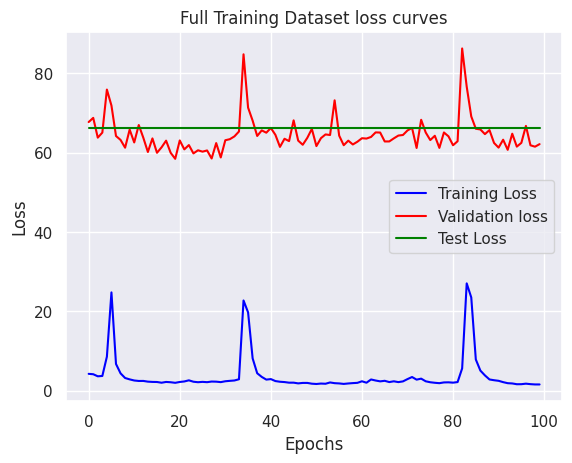

In [39]:
#plotting loss curves for the entire training dataset
plot_loss_curves(full_losses, full_vlosses, full_test_loss, epochs, model_name="Full Training Dataset")

In [41]:
# Training models on different Training Datasets
tlosses = []
vlosses = []
tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = Resnet34(1).to(device)
    model, train_losses, val_losses = train(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100)
    test_loss = eval_model(model, test_dataloader)

    tlosses.append(train_losses)
    vlosses.append(val_losses)
    tst_losses.append(test_loss)

    # torch.save(model.state_dict(), f"./Models/Gen2_models/model{i}.pth")
    # print(f"Model saved to ./Models/Gen2_models/model{i}.pth")

Training dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:03<00:00, 33.04s/it]


Test Loss: 160.4609832763672
Training dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [50:15<00:00, 30.16s/it]


Test Loss: 139.20773315429688
Training dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:05<00:00, 28.26s/it]


Test Loss: 306.47833251953125
Training dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:21<00:00, 28.42s/it]


Test Loss: 154.9225616455078
Training dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [35:01<00:00, 21.01s/it]


Test Loss: 225.24331665039062
Training dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [34:46<00:00, 20.87s/it]


Test Loss: 189.50743103027344
Training dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [36:06<00:00, 21.66s/it]


Test Loss: 299.649658203125
Training dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [36:36<00:00, 21.96s/it]


Test Loss: 215.7359619140625
Training dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [36:37<00:00, 21.98s/it]


Test Loss: 234.2543487548828
Training dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [35:46<00:00, 21.46s/it]


Test Loss: 180.0095672607422


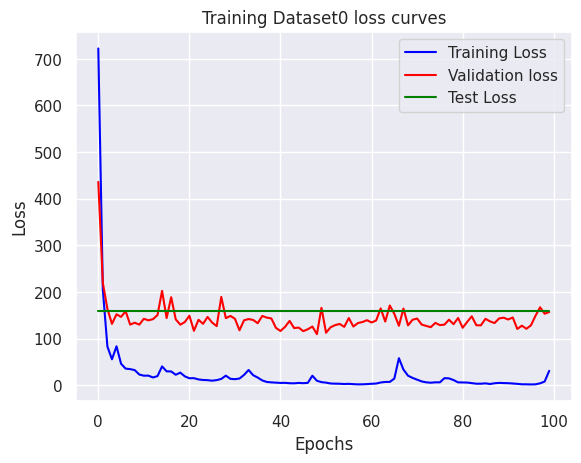

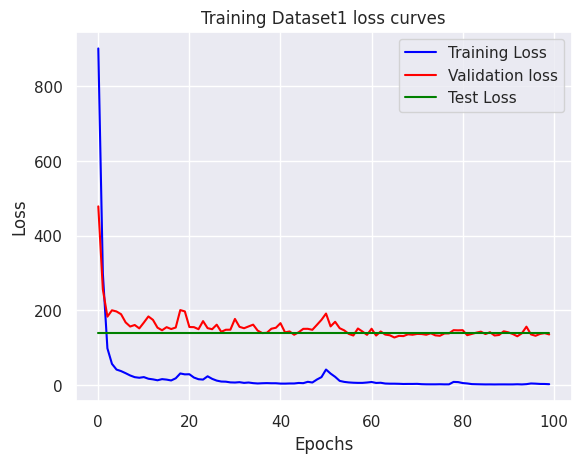

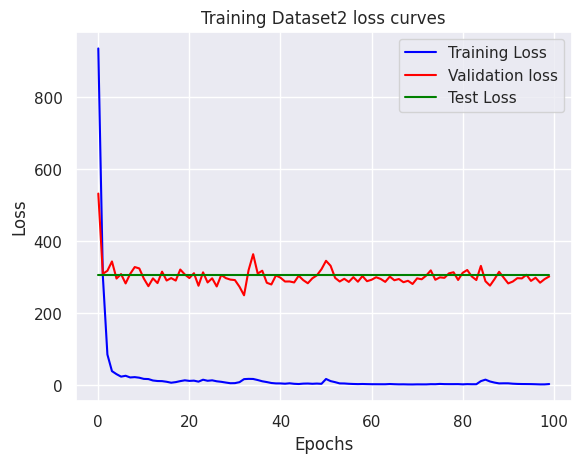

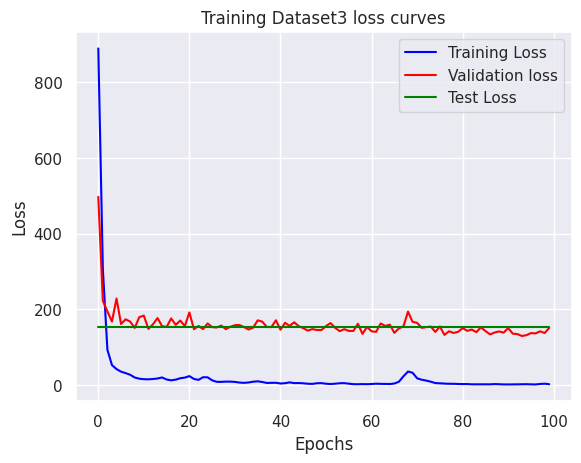

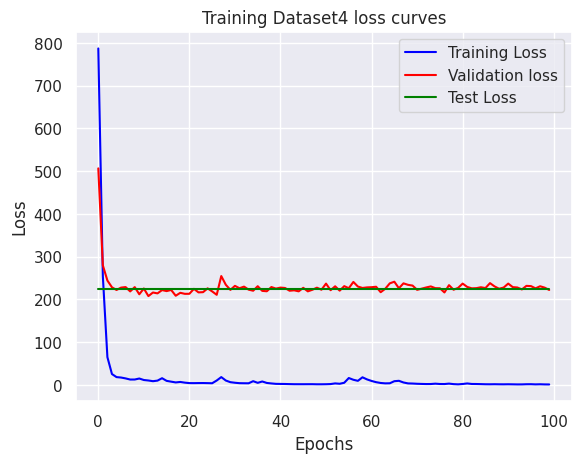

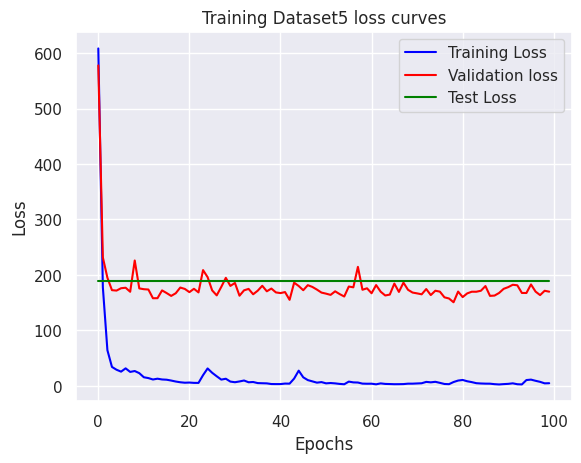

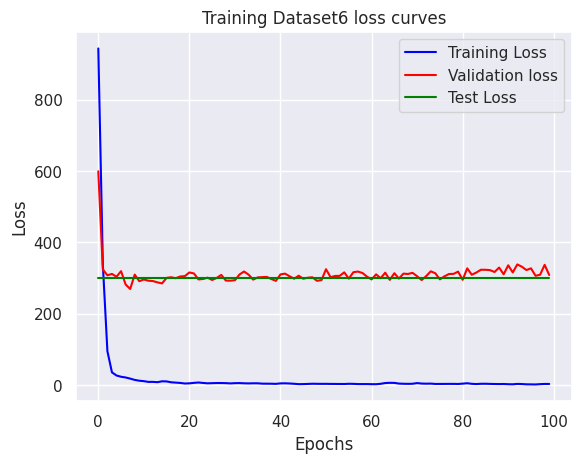

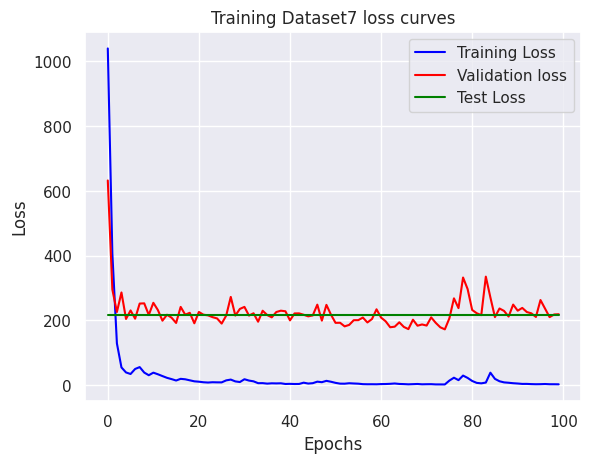

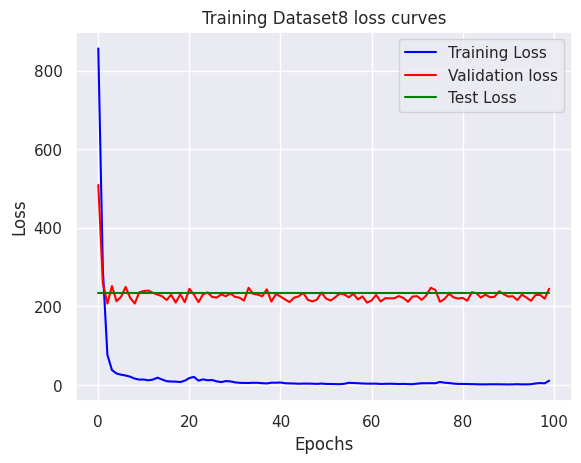

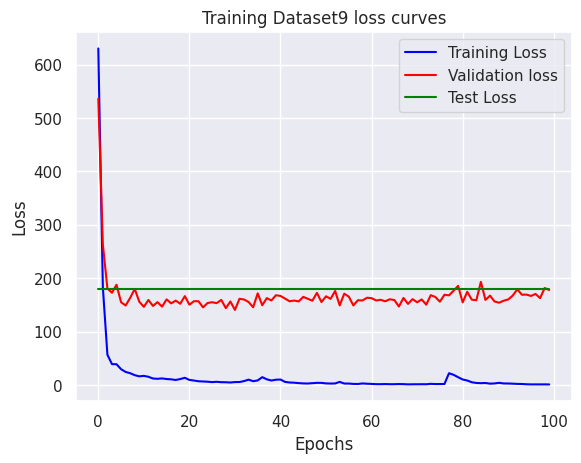

In [42]:
#plotting graphs:
for i in range(len(tlosses)):
    plot_loss_curves(tlosses[i], vlosses[i], tst_losses[i], epochs, model_name=f"Training Dataset{i}")

## Feature Sieve Regression
### 1) Forgetting loss: Margin Loss

In [29]:
class Feature_Sieve_Margin(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Margin, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, 1)
        # self.aux_out = nn.Linear(128, 1)


        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([ self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        # aux = self.aux_out(aux)
        
        
        return logits, aux

def fs_margin(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Margin(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [30]:
fs_mar_model = fs_margin(1, False).to(device)

In [31]:
## Forget Loss: Margin Loss
def learn_main(model, optim_main, x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux(model, optim_main, optim_aux, x, y, alpha_aux = 1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * F.mse_loss(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()
    return loss

def forget_aux(model, optim_forget, x, y, margin):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    mse_loss = F.mse_loss(aux,y)
    thresh = torch.tensor(-margin).to(torch.float32).to(device)
    loss = torch.max(thresh, -mse_loss)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()
    return loss

In [32]:
def train_fs_mar(model, train_dataloader, val_dataloader, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training model...............")
        
    train_losses= []
    val_losses = []
    aux_losses = []
    forget_losses = []

    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        # training Part of the code
        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                auxloss = learn_aux(model, optim_main, optim_aux, x, y)
            if forget_iters and steps % forget_iters == 0:
                forget_loss = forget_aux(model, optim_forget, x, y, margin)
                forget_losses.append(forget_loss.detach().cpu())

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                aux_losses.append(auxloss.detach().cpu())
                
                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

        # Validation part of the code
        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch+1}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses, forget_losses

def eval_FSModel(model, test_dataloader):
    tst_loss = 0
    test_nu = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloader):
            x,y, _ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            out = model(x)[0]
            loss = F.mse_loss(out, y, reduction = 'sum')

            tst_loss += loss.detach().cpu()
            test_nu += x.shape[0]

    return float(tst_loss / test_nu)

In [ ]:
# Hyperparameter Tuning
margins = [2, 50, 100]
forget_lrs = [1e-5, 1e-4, 1e-3]
forget_iters = [2, 50, 100]

test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))

for i in range(len(margins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            model = fs_margin(1, False).to(device)
            model, train_loss, val_loss = train_fs_mar(model, train_dataloaders[0], val_dataloader, margin = margins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 10, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)

            test_losses[i,j,k] = test_loss

best_margin, best_forget_lr, best_forget_iter = np.unravel_index(np.argmax(test_losses), test_losses.shape)
print(f"Best Margin : {margins[best_margin]} Best Forget LR: {forget_lrs[best_forget_lr]} Best Forget Iter: {forget_iters[best_forget_iter]}")

In [30]:
# Training models on different Training Datasets
fs_tlosses = []
fs_vlosses = []
fs_tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = fs_margin(1, False).to(device)
    model, train_losses, val_losses, _ = train_fs_mar(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100, margin=best_margin, forget_iters=best_forget_iter, lrs=[5e-4, 5e-4, best_forget_lr])
    test_loss = eval_FSModel(model, test_dataloader)

    fs_tlosses.append(train_losses)
    fs_vlosses.append(val_losses)
    fs_tst_losses.append(test_loss)

    torch.save(model.state_dict(), f"./Models/fs_mar_model{i}.pth")
    print(f"Model saved to ./Models/fs_mar_model{i}.pth")

Training dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:47<00:00, 26.88s/it]


Test Loss: 162.33738708496094
Model saved to ./Models/fs_mar_model0.pth
Training dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:37<00:00, 27.37s/it]


Test Loss: 172.19313049316406
Model saved to ./Models/fs_mar_model1.pth
Training dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:25<00:00, 26.66s/it]


Test Loss: 352.29833984375
Model saved to ./Models/fs_mar_model2.pth
Training dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:48<00:00, 26.89s/it]


Test Loss: 211.13082885742188
Model saved to ./Models/fs_mar_model3.pth
Training dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:23<00:00, 27.23s/it]


Test Loss: 256.6214599609375
Model saved to ./Models/fs_mar_model4.pth
Training dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:21<00:00, 27.21s/it]


Test Loss: 250.77903747558594
Model saved to ./Models/fs_mar_model5.pth
Training dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:01<00:00, 27.01s/it]


Test Loss: 227.75367736816406
Model saved to ./Models/fs_mar_model6.pth
Training dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:37<00:00, 27.38s/it]


Test Loss: 304.69744873046875
Model saved to ./Models/fs_mar_model7.pth
Training dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:33<00:00, 27.33s/it]


Test Loss: 257.0054626464844
Model saved to ./Models/fs_mar_model8.pth
Training dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:31<00:00, 27.32s/it]


Test Loss: 225.3866729736328
Model saved to ./Models/fs_mar_model9.pth


### 2) Cross Entropy Forgetting Loss:

In [33]:
#Cross entropy model
class Feature_Sieve_CE(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_CE, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 128, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        x = self.layer1(sh)

        #forward of the main network
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = F.softmax(self.aux_fc(aux), dim=-1)

        return logits, aux

def fs_ce(num_classes, num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_CE(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model
    

In [34]:
## Forgetting Loss: Cross Entropy
def learn_main_ce(FS, optim_main, x, y):
    FS.train()
    optim_main.zero_grad()
    out = FS(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    FS.eval()

def learn_aux_ce(FS, optim_main, optim_aux, x, y, bins, alpha_aux=1):
    FS.train()
    optim_main.zero_grad()
    aux = FS(x)[1]
    y = torch.bucketize(y,bins, right=False).reshape(-1)
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    FS.eval()
    return loss

def forget_aux_ce(FS, optim_forget, x, num_bins):
    FS.train()
    optim_forget.zero_grad()
    aux = FS(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux) * 1/num_bins)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    FS.eval()
    return loss

In [35]:
#Functions
def train_fs_ce(model, train_dataloader, val_dataloader, age, num_bins = 20, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=20, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training Model............")
        
    train_losses= []
    val_losses = []
    aux_losses = []
    forget_losses = []

    bin_counts, bin_edges = np.histogram(age, bins = num_bins -1 )
    bins = torch.tensor(bin_edges).to(device)
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        # Training part of the code
        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ce(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                aux_loss = learn_aux_ce(model, optim_main, optim_aux, x, y, bins)
            if forget_iters and steps % forget_iters == 0:
                forget_loss = forget_aux_ce(model, optim_forget, x, num_bins)
                forget_losses.append(forget_loss.detach().cpu())

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

            aux_losses.append(aux_loss.detach().cpu())

        # Validation part of the code
        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses, forget_losses

Training Model............


  1%|█▌                                                                                                                                                           | 1/100 [00:27<45:13, 27.41s/it]

Epochs: 0/100 Training Loss: 827.5842895507812 Validation Loss: 521.51611328125


  2%|███▏                                                                                                                                                         | 2/100 [00:54<44:43, 27.39s/it]

Epochs: 1/100 Training Loss: 295.16534423828125 Validation Loss: 236.9951629638672


  3%|████▋                                                                                                                                                        | 3/100 [01:22<44:37, 27.60s/it]

Epochs: 2/100 Training Loss: 174.6689910888672 Validation Loss: 215.3685302734375


  4%|██████▎                                                                                                                                                      | 4/100 [01:51<44:47, 27.99s/it]

Epochs: 3/100 Training Loss: 172.5572509765625 Validation Loss: 186.7392578125


  5%|███████▊                                                                                                                                                     | 5/100 [02:20<44:53, 28.36s/it]

Epochs: 4/100 Training Loss: 145.8343505859375 Validation Loss: 226.47134399414062


  6%|█████████▍                                                                                                                                                   | 6/100 [02:51<45:55, 29.32s/it]

Epochs: 5/100 Training Loss: 173.39181518554688 Validation Loss: 251.2313690185547


  7%|██████████▉                                                                                                                                                  | 7/100 [03:25<47:42, 30.78s/it]

Epochs: 6/100 Training Loss: 106.14424896240234 Validation Loss: 163.76942443847656


  8%|████████████▌                                                                                                                                                | 8/100 [03:58<48:34, 31.68s/it]

Epochs: 7/100 Training Loss: 99.66930389404297 Validation Loss: 204.63441467285156


  9%|██████████████▏                                                                                                                                              | 9/100 [04:32<48:46, 32.16s/it]

Epochs: 8/100 Training Loss: 105.59336853027344 Validation Loss: 286.1537170410156


 10%|███████████████▌                                                                                                                                            | 10/100 [05:05<48:50, 32.56s/it]

Epochs: 9/100 Training Loss: 100.3307113647461 Validation Loss: 146.09190368652344


 11%|█████████████████▏                                                                                                                                          | 11/100 [05:39<48:49, 32.92s/it]

Epochs: 10/100 Training Loss: 101.86698150634766 Validation Loss: 206.67417907714844


 12%|██████████████████▋                                                                                                                                         | 12/100 [06:12<48:26, 33.03s/it]

Epochs: 11/100 Training Loss: 56.23571014404297 Validation Loss: 181.4991455078125


 13%|████████████████████▎                                                                                                                                       | 13/100 [06:46<48:29, 33.44s/it]

Epochs: 12/100 Training Loss: 159.64218139648438 Validation Loss: 1026.485107421875


 14%|█████████████████████▊                                                                                                                                      | 14/100 [07:19<47:35, 33.21s/it]

Epochs: 13/100 Training Loss: 64.56996154785156 Validation Loss: 370.6675720214844


 15%|███████████████████████▍                                                                                                                                    | 15/100 [07:52<46:46, 33.02s/it]

Epochs: 14/100 Training Loss: 48.27073287963867 Validation Loss: 213.63235473632812


 16%|████████████████████████▉                                                                                                                                   | 16/100 [08:26<46:42, 33.37s/it]

Epochs: 15/100 Training Loss: 83.059814453125 Validation Loss: 271.97265625


 17%|██████████████████████████▌                                                                                                                                 | 17/100 [08:59<45:58, 33.23s/it]

Epochs: 16/100 Training Loss: 46.791072845458984 Validation Loss: 168.80145263671875


 18%|████████████████████████████                                                                                                                                | 18/100 [09:31<44:55, 32.87s/it]

Epochs: 17/100 Training Loss: 55.213218688964844 Validation Loss: 264.7220764160156


 19%|█████████████████████████████▋                                                                                                                              | 19/100 [10:04<44:27, 32.93s/it]

Epochs: 18/100 Training Loss: 125.64678955078125 Validation Loss: 159.53811645507812


 20%|███████████████████████████████▏                                                                                                                            | 20/100 [10:39<44:40, 33.51s/it]

Epochs: 19/100 Training Loss: 39.541908264160156 Validation Loss: 196.4532470703125


 21%|████████████████████████████████▊                                                                                                                           | 21/100 [11:11<43:30, 33.04s/it]

Epochs: 20/100 Training Loss: 37.84379959106445 Validation Loss: 150.0245819091797


 22%|██████████████████████████████████▎                                                                                                                         | 22/100 [11:43<42:41, 32.84s/it]

Epochs: 21/100 Training Loss: 28.009654998779297 Validation Loss: 170.6394500732422


 23%|███████████████████████████████████▉                                                                                                                        | 23/100 [12:18<42:57, 33.47s/it]

Epochs: 22/100 Training Loss: 36.2221565246582 Validation Loss: 180.01181030273438


 24%|█████████████████████████████████████▍                                                                                                                      | 24/100 [12:50<42:01, 33.18s/it]

Epochs: 23/100 Training Loss: 26.173389434814453 Validation Loss: 144.81185913085938


 25%|███████████████████████████████████████                                                                                                                     | 25/100 [13:24<41:46, 33.42s/it]

Epochs: 24/100 Training Loss: 30.618831634521484 Validation Loss: 181.89100646972656


 26%|████████████████████████████████████████▌                                                                                                                   | 26/100 [13:58<41:08, 33.35s/it]

Epochs: 25/100 Training Loss: 26.06795883178711 Validation Loss: 176.2346649169922


 27%|██████████████████████████████████████████                                                                                                                  | 27/100 [14:33<41:15, 33.91s/it]

Epochs: 26/100 Training Loss: 45.39636993408203 Validation Loss: 173.91114807128906


 28%|███████████████████████████████████████████▋                                                                                                                | 28/100 [15:08<41:07, 34.27s/it]

Epochs: 27/100 Training Loss: 78.6139144897461 Validation Loss: 197.8458251953125


 29%|█████████████████████████████████████████████▏                                                                                                              | 29/100 [15:40<39:54, 33.72s/it]

Epochs: 28/100 Training Loss: 35.259681701660156 Validation Loss: 172.2644500732422


 30%|██████████████████████████████████████████████▊                                                                                                             | 30/100 [16:16<39:50, 34.15s/it]

Epochs: 29/100 Training Loss: 30.04803466796875 Validation Loss: 158.15545654296875


 31%|████████████████████████████████████████████████▎                                                                                                           | 31/100 [16:48<38:41, 33.64s/it]

Epochs: 30/100 Training Loss: 54.76483154296875 Validation Loss: 148.9989013671875


 32%|█████████████████████████████████████████████████▉                                                                                                          | 32/100 [17:22<38:09, 33.67s/it]

Epochs: 31/100 Training Loss: 78.79093170166016 Validation Loss: 180.35983276367188


 33%|███████████████████████████████████████████████████▍                                                                                                        | 33/100 [17:56<37:42, 33.77s/it]

Epochs: 32/100 Training Loss: 66.89480590820312 Validation Loss: 168.1258544921875


 34%|█████████████████████████████████████████████████████                                                                                                       | 34/100 [18:28<36:37, 33.30s/it]

Epochs: 33/100 Training Loss: 27.50237464904785 Validation Loss: 180.0670166015625


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 35/100 [19:03<36:29, 33.69s/it]

Epochs: 34/100 Training Loss: 36.05628204345703 Validation Loss: 169.83995056152344


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 36/100 [19:36<35:53, 33.64s/it]

Epochs: 35/100 Training Loss: 82.13446807861328 Validation Loss: 150.9318389892578


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 37/100 [20:10<35:24, 33.73s/it]

Epochs: 36/100 Training Loss: 46.24989700317383 Validation Loss: 187.5949249267578


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 38/100 [20:43<34:46, 33.65s/it]

Epochs: 37/100 Training Loss: 101.11001586914062 Validation Loss: 151.7360382080078


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 39/100 [21:17<34:05, 33.54s/it]

Epochs: 38/100 Training Loss: 20.778854370117188 Validation Loss: 150.6208953857422


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 40/100 [21:51<33:39, 33.66s/it]

Epochs: 39/100 Training Loss: 127.49308013916016 Validation Loss: 161.46502685546875


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 41/100 [22:25<33:09, 33.73s/it]

Epochs: 40/100 Training Loss: 70.88154602050781 Validation Loss: 162.5419921875


 42%|█████████████████████████████████████████████████████████████████▌                                                                                          | 42/100 [22:59<32:43, 33.86s/it]

Epochs: 41/100 Training Loss: 28.0424861907959 Validation Loss: 236.3531494140625


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 43/100 [23:33<32:12, 33.91s/it]

Epochs: 42/100 Training Loss: 18.776321411132812 Validation Loss: 165.50685119628906


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 44/100 [24:06<31:29, 33.74s/it]

Epochs: 43/100 Training Loss: 91.66858673095703 Validation Loss: 163.1114959716797


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 45/100 [24:40<31:03, 33.88s/it]

Epochs: 44/100 Training Loss: 41.73631286621094 Validation Loss: 222.46762084960938


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [25:12<30:01, 33.36s/it]

Epochs: 45/100 Training Loss: 16.874984741210938 Validation Loss: 143.52047729492188


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                  | 47/100 [25:47<29:40, 33.59s/it]

Epochs: 46/100 Training Loss: 14.175973892211914 Validation Loss: 160.6997528076172


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 48/100 [26:22<29:32, 34.09s/it]

Epochs: 47/100 Training Loss: 17.61351203918457 Validation Loss: 157.39520263671875


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 49/100 [26:56<29:05, 34.23s/it]

Epochs: 48/100 Training Loss: 14.2526216506958 Validation Loss: 134.07485961914062


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 50/100 [27:32<28:46, 34.52s/it]

Epochs: 49/100 Training Loss: 12.378290176391602 Validation Loss: 153.84019470214844


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/100 [28:04<27:34, 33.76s/it]

Epochs: 50/100 Training Loss: 8.60246753692627 Validation Loss: 139.12205505371094


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 52/100 [28:37<26:56, 33.68s/it]

Epochs: 51/100 Training Loss: 8.377202033996582 Validation Loss: 153.8565673828125


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 53/100 [29:10<26:10, 33.40s/it]

Epochs: 52/100 Training Loss: 8.486122131347656 Validation Loss: 127.05093383789062


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 54/100 [29:45<25:54, 33.80s/it]

Epochs: 53/100 Training Loss: 10.699882507324219 Validation Loss: 127.97359466552734


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 55/100 [30:16<24:54, 33.20s/it]

Epochs: 54/100 Training Loss: 10.390143394470215 Validation Loss: 135.22853088378906


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 56/100 [30:52<24:54, 33.96s/it]

Epochs: 55/100 Training Loss: 8.247485160827637 Validation Loss: 132.92974853515625


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57/100 [31:25<24:08, 33.68s/it]

Epochs: 56/100 Training Loss: 9.204575538635254 Validation Loss: 147.47598266601562


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 58/100 [32:01<23:58, 34.24s/it]

Epochs: 57/100 Training Loss: 8.626449584960938 Validation Loss: 160.663818359375


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 59/100 [32:35<23:23, 34.23s/it]

Epochs: 58/100 Training Loss: 10.418980598449707 Validation Loss: 136.44390869140625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 60/100 [33:07<22:29, 33.74s/it]

Epochs: 59/100 Training Loss: 9.354941368103027 Validation Loss: 147.81423950195312


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 61/100 [33:43<22:13, 34.18s/it]

Epochs: 60/100 Training Loss: 7.785813331604004 Validation Loss: 141.4354248046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 62/100 [34:16<21:28, 33.90s/it]

Epochs: 61/100 Training Loss: 5.2731709480285645 Validation Loss: 150.47401428222656


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 63/100 [34:49<20:47, 33.73s/it]

Epochs: 62/100 Training Loss: 5.334841728210449 Validation Loss: 137.31097412109375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/100 [35:24<20:22, 33.97s/it]

Epochs: 63/100 Training Loss: 4.831803321838379 Validation Loss: 142.83030700683594


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 65/100 [35:58<19:55, 34.17s/it]

Epochs: 64/100 Training Loss: 4.420369625091553 Validation Loss: 135.524658203125


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 66/100 [36:31<19:09, 33.80s/it]

Epochs: 65/100 Training Loss: 4.656691551208496 Validation Loss: 161.70985412597656


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 67/100 [37:06<18:48, 34.19s/it]

Epochs: 66/100 Training Loss: 43.7232551574707 Validation Loss: 171.92071533203125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 68/100 [37:40<18:04, 33.90s/it]

Epochs: 67/100 Training Loss: 134.79641723632812 Validation Loss: 253.07470703125


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 69/100 [38:13<17:28, 33.82s/it]

Epochs: 68/100 Training Loss: 105.05876159667969 Validation Loss: 743.5848999023438


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70/100 [38:48<16:58, 33.94s/it]

Epochs: 69/100 Training Loss: 100.22724914550781 Validation Loss: 201.5155487060547


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 71/100 [39:23<16:41, 34.54s/it]

Epochs: 70/100 Training Loss: 70.99446105957031 Validation Loss: 196.88807678222656


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 72/100 [39:57<15:58, 34.24s/it]

Epochs: 71/100 Training Loss: 48.481971740722656 Validation Loss: 188.8062286376953


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 73/100 [40:31<15:25, 34.27s/it]

Epochs: 72/100 Training Loss: 19.984880447387695 Validation Loss: 161.65219116210938


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 74/100 [41:07<14:58, 34.57s/it]

Epochs: 73/100 Training Loss: 13.419352531433105 Validation Loss: 144.66456604003906


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 75/100 [41:38<14:03, 33.72s/it]

Epochs: 74/100 Training Loss: 11.210236549377441 Validation Loss: 149.3433074951172


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 76/100 [42:13<13:33, 33.90s/it]

Epochs: 75/100 Training Loss: 14.461878776550293 Validation Loss: 144.2133331298828


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 77/100 [42:46<12:57, 33.79s/it]

Epochs: 76/100 Training Loss: 7.939141273498535 Validation Loss: 159.59677124023438


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 78/100 [43:19<12:16, 33.46s/it]

Epochs: 77/100 Training Loss: 9.790718078613281 Validation Loss: 142.3200225830078


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 79/100 [43:53<11:49, 33.76s/it]

Epochs: 78/100 Training Loss: 5.87026309967041 Validation Loss: 141.29066467285156


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 80/100 [44:28<11:21, 34.06s/it]

Epochs: 79/100 Training Loss: 5.20678186416626 Validation Loss: 137.5656280517578


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 81/100 [45:01<10:39, 33.68s/it]

Epochs: 80/100 Training Loss: 5.966711044311523 Validation Loss: 146.90794372558594


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 82/100 [45:35<10:07, 33.77s/it]

Epochs: 81/100 Training Loss: 5.427988529205322 Validation Loss: 140.78054809570312


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 83/100 [46:09<09:36, 33.94s/it]

Epochs: 82/100 Training Loss: 5.408186912536621 Validation Loss: 143.4456787109375


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 84/100 [46:42<08:58, 33.68s/it]

Epochs: 83/100 Training Loss: 5.061482906341553 Validation Loss: 132.4809112548828


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 85/100 [47:17<08:29, 34.00s/it]

Epochs: 84/100 Training Loss: 6.1964287757873535 Validation Loss: 141.28929138183594


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/100 [47:52<08:02, 34.43s/it]

Epochs: 85/100 Training Loss: 5.1917524337768555 Validation Loss: 154.6790008544922


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 87/100 [48:26<07:23, 34.10s/it]

Epochs: 86/100 Training Loss: 5.163937568664551 Validation Loss: 148.96319580078125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 88/100 [49:01<06:52, 34.37s/it]

Epochs: 87/100 Training Loss: 5.491643905639648 Validation Loss: 140.40663146972656


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 89/100 [49:35<06:15, 34.17s/it]

Epochs: 88/100 Training Loss: 4.332306861877441 Validation Loss: 141.1698760986328


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 90/100 [50:09<05:42, 34.22s/it]

Epochs: 89/100 Training Loss: 4.476858615875244 Validation Loss: 149.94427490234375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 91/100 [50:42<05:05, 33.95s/it]

Epochs: 90/100 Training Loss: 4.621644496917725 Validation Loss: 168.26455688476562


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 92/100 [51:16<04:32, 34.06s/it]

Epochs: 91/100 Training Loss: 113.12613677978516 Validation Loss: 256.6640930175781


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 93/100 [51:50<03:57, 33.99s/it]

Epochs: 92/100 Training Loss: 102.06559753417969 Validation Loss: 181.83416748046875


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 94/100 [52:23<03:21, 33.59s/it]

Epochs: 93/100 Training Loss: 65.6714096069336 Validation Loss: 158.49765014648438


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 95/100 [52:57<02:49, 33.83s/it]

Epochs: 94/100 Training Loss: 20.408634185791016 Validation Loss: 154.94692993164062


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [53:32<02:16, 34.16s/it]

Epochs: 95/100 Training Loss: 45.225914001464844 Validation Loss: 148.90017700195312


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 97/100 [54:04<01:40, 33.46s/it]

Epochs: 96/100 Training Loss: 26.38450050354004 Validation Loss: 205.6100616455078


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [54:39<01:07, 33.81s/it]

Epochs: 97/100 Training Loss: 13.403050422668457 Validation Loss: 126.92296600341797


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [55:12<00:33, 33.70s/it]

Epochs: 98/100 Training Loss: 10.558806419372559 Validation Loss: 156.74058532714844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:48<00:00, 33.48s/it]

Epochs: 99/100 Training Loss: 7.3060150146484375 Validation Loss: 132.5943603515625


Test Loss: 149.87060546875


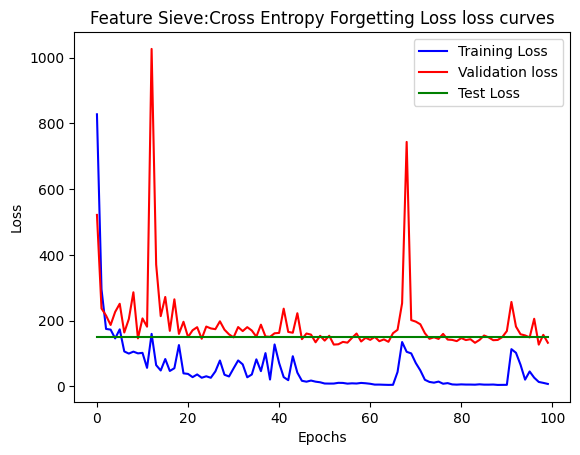

In [33]:
#Training
epochs = 100
num_bins = 20
ages = data_df['age'].values

fs_ce_model = fs_ce(1, num_bins, False).to(device)
fs_ce_model, fs_ce_tloss, fs_ce_vloss ,_ = train_fs_ce(fs_ce_model, train_dataloaders[0], val_dataloader, ages, num_bins = num_bins, verbose = True)
fs_ce_test_loss = eval_FSModel(fs_ce_model, test_dataloader)

plot_loss_curves(fs_ce_tloss, fs_ce_vloss, fs_ce_test_loss, epochs = epochs, model_name = "Feature Sieve:Cross Entropy Forgetting Loss")

In [46]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

num_bin = 20

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages,  num_bins=num_bin, forget_iters=forget_iters[i], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses = []
for i in range(len(forget_lrs)):
    print(f"Forget Lr: {forget_lrs[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bin, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget Lr: {best_forget_lr}")

test_losses=[]
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ce(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bins[i], forget_iters=best_forget_iter, lrs=[0.0005,0.0005, best_forget_lr], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.09s/it]


Test Loss: 188.9726104736328
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.36s/it]


Test Loss: 209.47503662109375
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.64s/it]


Test Loss: 295.4831237792969
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.43s/it]


Test Loss: 273.8879089355469
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.85s/it]


Test Loss: 340.2899475097656
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.39s/it]


Test Loss: 1260.3504638671875
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.83s/it]


Test Loss: 203.2891387939453
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.96s/it]


Test Loss: 270.7403564453125
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.17s/it]


Test Loss: 218.1846923828125
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.13s/it]


Test Loss: 1014.4155883789062
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.03s/it]


Test Loss: 265.92352294921875
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.09s/it]


Test Loss: 561.5079956054688
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.62s/it]


Test Loss: 199.1851806640625
Best Forget Iter: 2
Forget Lr: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.30s/it]


Test Loss: 304.4369812011719
Forget Lr: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.79s/it]


Test Loss: 196.960693359375
Forget Lr: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.16s/it]


Test Loss: 477.94732666015625
Forget Lr: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.42s/it]


Test Loss: 593.125244140625
Forget Lr: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:01<00:00, 36.36s/it]


Test Loss: 227.2938690185547
Forget Lr: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.64s/it]


Test Loss: 226.6198272705078
Forget Lr: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.53s/it]


Test Loss: 204.45501708984375
Forget Lr: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.89s/it]


Test Loss: 189.7186737060547
Best Forget Lr: 0.1
Num Bins: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.12s/it]


Test Loss: 301.1495361328125
Num Bins: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.43s/it]


Test Loss: 224.38694763183594
Num Bins: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.22s/it]


Test Loss: 321.97607421875
Num Bins: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.02s/it]


Test Loss: 211.0284423828125
Num Bins: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.63s/it]


Test Loss: 247.28042602539062
Num Bins: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.28s/it]


Test Loss: 235.97201538085938
Num Bins: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.46s/it]


Test Loss: 307.9757385253906
Num Bins: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.26s/it]


Test Loss: 287.79913330078125
Num Bins: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.05s/it]


Test Loss: 339.7842712402344
Num Bins: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.55s/it]


Test Loss: 204.39402770996094
Num Bins: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.84s/it]


Test Loss: 243.2328338623047
Num Bins: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.97s/it]


Test Loss: 270.8900451660156
Best Num Bins: 80


In [47]:
fs_ce_tloss = []
fs_ce_vloss = []
fs_ce_test_loss = []

best_num_bins = 3
best_forget_iters = 50 
best_forget_lr = 0.001

for i in range(len(train_dataloaders)):
    print(f"Training Dataset {i}")
    model = fs_ce(1, best_num_bins, False).to(device)
    model, fs_ce_loss, fs_ce_val_loss = train_fs_ce(model, train_dataloaders[i], val_dataloader, ages, num_bins = best_num_bins, forget_iters=best_forget_iters, lrs=[0.0005, 0.0005, best_forget_lr], verbose = False)
    fs_ce_tst_loss = eval_FSModel(model, test_dataloader)

    fs_ce_tloss.append(fs_ce_loss)
    fs_ce_vloss.append(fs_ce_val_loss)
    fs_ce_test_loss.append(fs_ce_tst_loss)

    torch.save(model.state_dict(), f"./Models/fs_ce_model{i}.pth")
    print(f"Logged model into: ./Models/fs_ce_model{i}.pth")

Training Dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [52:04<00:00, 31.24s/it]


Test Loss: 174.06626892089844
Logged model into: ./Models/fs_ce_model0.pth
Training Dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:18<00:00, 32.58s/it]


Test Loss: 224.8866729736328
Logged model into: ./Models/fs_ce_model1.pth
Training Dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:20<00:00, 33.21s/it]


Test Loss: 304.33721923828125
Logged model into: ./Models/fs_ce_model2.pth
Training Dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:30<00:00, 33.31s/it]


Test Loss: 219.54811096191406
Logged model into: ./Models/fs_ce_model3.pth
Training Dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:24<00:00, 33.25s/it]


Test Loss: 266.0223388671875
Logged model into: ./Models/fs_ce_model4.pth
Training Dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:56<00:00, 33.56s/it]


Test Loss: 235.9572296142578
Logged model into: ./Models/fs_ce_model5.pth
Training Dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:48<00:00, 33.48s/it]


Test Loss: 234.09063720703125
Logged model into: ./Models/fs_ce_model6.pth
Training Dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:12<00:00, 33.73s/it]


Test Loss: 368.1534423828125
Logged model into: ./Models/fs_ce_model7.pth
Training Dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:55<00:00, 33.56s/it]


Test Loss: 278.2205810546875
Logged model into: ./Models/fs_ce_model8.pth
Training Dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:08<00:00, 33.68s/it]


Test Loss: 207.40386962890625
Logged model into: ./Models/fs_ce_model9.pth


### 3) Ordinal Forgetting Loss

In [36]:
# Ordinal Model
class Feature_Sieve_Ord(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Ord, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        
        return logits, aux

def fs_ord(num_classes,num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Ord(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model

In [37]:
# Multilabel Loss function
multi_label_loss = nn.BCEWithLogitsLoss()

def learn_main_ordinal(model, optim_main,x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord, alpha_aux=1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * multi_label_loss(aux, y_ord)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()
    return loss

def forget_aux_ordinal(model, optim_forget, x,y, num_bins):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    aux_preds = torch.sum(F.sigmoid(aux), dim =-1) * 116 / num_bins
    loss = F.mse_loss(aux_preds.reshape(-1,1), y)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()
    return loss

In [38]:
#Functions
def train_fs_ord(model, train_dataloader, val_dataloader, num_bins=20, epochs = 100, aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    train_losses= []
    val_losses = []
    aux_losses = []
    forget_losses = []
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            y_ord = y.reshape(-1).numpy()
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            #Ordinal label generation
            y_ord = np.greater_equal.outer(y_ord, np.arange(num_bins)*116/num_bins).astype(float)
            y_ord = torch.tensor(y_ord).reshape(y_ord.shape[0], -1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ordinal(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                aux_loss = learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord)
            if forget_iters and steps % forget_iters == 0:
                forget_loss = forget_aux_ordinal(model, optim_forget, x, y, num_bins)
                forget_losses.append(forget_loss.detach().cpu())

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

            aux_losses.append(aux_loss.detach().cpu())

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses, forget_losses

In [35]:
fs_ord_model = fs_ord(1, 20, False).to(device)
fs_ord_model, fs_ord_tloss, fs_ord_vloss,_ = train_fs_ord(fs_ord_model, train_dataloaders[0], val_dataloader, num_bins = 20, verbose = False)
fs_ord_tst_loss = eval_FSModel(fs_ord_model, test_dataloader)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:10<00:00, 28.31s/it]


Test Loss: 176.63095092773438


In [31]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ord(1,20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=forget_iters[i], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses=[]
for i in range(len(forget_lrs)):
    print(f"Forget LR: {forget_lrs[i]}")
    model = fs_ord(1, 20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget LR: {best_forget_lr}")

test_losses = []
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ord(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=num_bins[i], forget_iters=best_forget_iter, epochs=5, lrs=[0.0005,0.0005,best_forget_lr], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.64s/it]


Test Loss: 1567.7342529296875
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.38s/it]


Test Loss: 949.28662109375
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it]


Test Loss: 293.83392333984375
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.26s/it]


Test Loss: 186.01007080078125
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.19s/it]


Test Loss: 250.61827087402344
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.53s/it]


Test Loss: 206.6374969482422
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.35s/it]


Test Loss: 266.7720642089844
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.07s/it]


Test Loss: 279.9361267089844
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.13s/it]


Test Loss: 248.24282836914062
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.87s/it]


Test Loss: 397.17138671875
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.86s/it]


Test Loss: 849.2794799804688
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.57s/it]


Test Loss: 326.846435546875
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.43s/it]


Test Loss: 189.51080322265625
Best Forget Iter: 20
Forget LR: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.28s/it]


Test Loss: 345.2628479003906
Forget LR: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.79s/it]


Test Loss: 172.997802734375
Forget LR: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.53s/it]


Test Loss: 167.3886260986328
Forget LR: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.03s/it]


Test Loss: 225.93434143066406
Forget LR: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


Test Loss: 299.410888671875
Forget LR: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.71s/it]


Test Loss: 233.41815185546875
Forget LR: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.25s/it]


Test Loss: 286.5182189941406
Forget LR: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.29s/it]


Test Loss: 396.6966552734375
Best Forget LR: 0.0001
Num Bins: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]


Test Loss: 198.12777709960938
Num Bins: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.03s/it]


Test Loss: 272.1819152832031
Num Bins: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.27s/it]


Test Loss: 300.36065673828125
Num Bins: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.00s/it]


Test Loss: 450.013427734375
Num Bins: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.15s/it]


Test Loss: 331.4488220214844
Num Bins: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.04s/it]


Test Loss: 196.8692626953125
Num Bins: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.10s/it]


Test Loss: 256.56707763671875
Num Bins: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.50s/it]


Test Loss: 245.00143432617188
Num Bins: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.47s/it]


Test Loss: 206.03347778320312
Num Bins: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


Test Loss: 224.94801330566406
Num Bins: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.16s/it]


Test Loss: 205.9883270263672
Num Bins: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.51s/it]


Test Loss: 188.63841247558594
Best Num Bins: 100


In [32]:
# On Different Datasets
fs_ord_tlosses = []
fs_ord_vlosses = []
fs_ord_test_losses = []

best_forget_iter = 90
best_forget_lr = 0.0001
best_num_bins = 100

for i in range(len(train_dataloaders)):
    print(f"Training Dataset :{i}")
    fs_ord_model = fs_ord(1, best_num_bins, False).to(device)
    fs_ord_model, fs_ord_tloss, fs_ord_vloss = train_fs_ord(fs_ord_model, train_dataloaders[i], val_dataloader, num_bins = best_num_bins, forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr],epochs=100, verbose = False)
    fs_ord_test_loss = eval_FSModel(fs_ord_model, test_dataloader)

    fs_ord_tlosses.append(fs_ord_tloss)
    fs_ord_vlosses.append(fs_ord_vloss)
    fs_ord_test_losses.append(fs_ord_test_loss)
    
    torch.save(fs_ord_model.state_dict(), f"./Models/fs_ord_model{i}.pth")
    print(f"Logged Model to ./Models/fs_ord_model{i}.pth")

Training Dataset :0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:02<00:00, 28.23s/it]


Test Loss: 167.37442016601562
Logged Model to ./Models/fs_ord_model0.pth
Training Dataset :1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:12<00:00, 28.32s/it]


Test Loss: 176.6057891845703
Logged Model to ./Models/fs_ord_model1.pth
Training Dataset :2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:06<00:00, 28.27s/it]


Test Loss: 326.765380859375
Logged Model to ./Models/fs_ord_model2.pth
Training Dataset :3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:58<00:00, 28.18s/it]


Test Loss: 212.7412872314453
Logged Model to ./Models/fs_ord_model3.pth
Training Dataset :4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:19<00:00, 28.39s/it]


Test Loss: 256.0242614746094
Logged Model to ./Models/fs_ord_model4.pth
Training Dataset :5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:14<00:00, 28.34s/it]


Test Loss: 234.5452117919922
Logged Model to ./Models/fs_ord_model5.pth
Training Dataset :6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:07<00:00, 28.28s/it]


Test Loss: 238.74819946289062
Logged Model to ./Models/fs_ord_model6.pth
Training Dataset :7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:01<00:00, 28.22s/it]


Test Loss: 300.202880859375
Logged Model to ./Models/fs_ord_model7.pth
Training Dataset :8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:24<00:00, 28.44s/it]


Test Loss: 299.679443359375
Logged Model to ./Models/fs_ord_model8.pth
Training Dataset :9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:15<00:00, 28.36s/it]


Test Loss: 201.1782684326172
Logged Model to ./Models/fs_ord_model9.pth


## Models on Dataset without Bias

Length of the Train Dataset with no bias: 5000


/tmp/ipykernel_469618/1316461109.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_train_df_nb = train_df_nb[train_df.gender == 0].age.values
/tmp/ipykernel_469618/1316461109.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_train_df_nb = train_df_nb[train_df.gender == 1].age.values


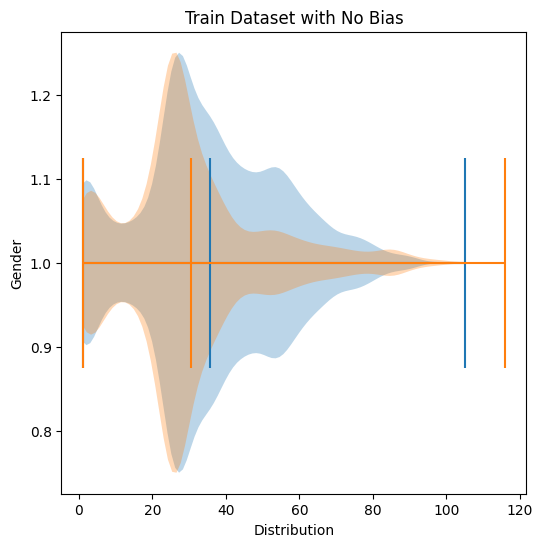

In [39]:
train_df_nb = train_df.sample(n=5000).reset_index(drop = True)
no_bias_dataset = UTKFaceDataset(dataframe = train_df_nb,
                                image_dir = DIR_PATH,
                                transform = custom_transform)

print(f"Length of the Train Dataset with no bias: {len(no_bias_dataset)}")

no_bias_dataloader = DataLoader(dataset = no_bias_dataset,
                               shuffle = True,
                               batch_size = BATCH_SIZE)

male_train_df_nb = train_df_nb[train_df.gender == 0].age.values
female_train_df_nb = train_df_nb[train_df.gender == 1].age.values
plt.violinplot(male_train_df, vert=False, showmeans = True)
plt.violinplot(female_train_df, vert = False, showmeans= True)
plt.xlabel("Distribution")
plt.ylabel("Gender")
plt.title("Train Dataset with No Bias")
plt.savefig("./Datasets/Train_Dataset_no_bias.png")
plt.show()

In [40]:
## Bayesian model
x = train_df_nb.gender.values
x = x.reshape(-1,1)
y = train_df_nb.age.values

#Bayesian Regression Model
reg = linear_model.BayesianRidge()
reg.fit(x, y)

#Error Calculations
x_test = test_df.gender.values
x_test = x_test.reshape(-1,1)
y_test = test_df.age.values

y_pred = reg.predict(x_test)
Loss = (np.square(y_test - y_pred)).mean() 
print(f"Test Loss of Bayesian Model: {Loss}")

test_losses_bayesian.insert(1, Loss)

Test Loss of Bayesian Model: 387.65352247080494


## Checking for forgetting losses in Feature Sieve Models

In [41]:
def plot_aux_losses(aux_losses, model_name, forget_iters = 50):
    aux_losses = torch.tensor(aux_losses)
    plt.plot(range(aux_losses.shape[0]), aux_losses, color = "blue")
    plt.vlines(np.arange(0, aux_losses.shape[0], forget_iters), ymin = 0, ymax = aux_losses[np.arange(0,aux_losses.shape[0], forget_iters)], color = "red")
    plt.xlabel("Epochs")
    plt.ylabel("Auxiliary loss")
    plt.title(model_name)
    plt.savefig(f"./{model_name}.png")
    plt.show()

## Groups

In [42]:
male_test_df = test_df[test_df['gender'] == 0].reset_index(drop = True)
female_test_df = test_df[test_df['gender'] == 1].reset_index(drop = True)

## Groups for male 
male_old_test_df = male_test_df[male_test_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop=True)
male_yng_test_df = male_test_df[male_test_df['age']< (min(ages)+ max(ages))//2].reset_index(drop = True)

## Groups for female
female_old_test_df = female_test_df[female_test_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop = True)
female_yng_test_df = female_test_df[female_test_df['age'] < (min(ages) + max(ages)) // 2].reset_index(drop=True)

print(f"Shape of group: male and old: {male_old_test_df.shape}")
print(f"Shape of group: male and young: {male_yng_test_df.shape}")
print(f"Shape of group: male and old: {female_old_test_df.shape}")
print(f"Shape of group: female and young: {female_yng_test_df.shape}")
print(f"Shape of entire Test set: {test_df.shape}")

Shape of group: male and old: (376, 4)
Shape of group: male and young: (2052, 4)
Shape of group: male and old: (263, 4)
Shape of group: female and young: (2050, 4)
Shape of entire Test set: (4741, 4)


In [43]:
#Datasets and DataLoaders
male_old_dataset = UTKFaceDataset(dataframe = male_old_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
male_yng_dataset = UTKFaceDataset(dataframe = male_yng_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
female_old_dataset = UTKFaceDataset(dataframe = female_old_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
female_yng_dataset = UTKFaceDataset(dataframe = female_yng_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)

male_old_dataloader = DataLoader(dataset = male_old_dataset,
                             shuffle = True,
                             batch_size = BATCH_SIZE)
male_yng_dataloader = DataLoader(dataset = male_yng_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)
female_old_dataloader = DataLoader(dataset = female_old_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)
female_yng_dataloader = DataLoader(dataset = female_yng_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)

In [44]:
group_dataloaders = { "m yng": male_yng_dataloader, "m old": male_old_dataloader, "f yng": female_yng_dataloader, "f old": female_old_dataloader}

def group_eval_cnn(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_model(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
        
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ /count), groups

def group_eval_fs(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_FSModel(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
            
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ / count), groups

In [45]:
male_old_counts = []
male_yng_counts = []
female_yng_counts = []
female_old_counts = []
total_counts = []

training_dfs = [train_df, train_df_nb] + dfs_gen2
train_group_dataloaders = []

for df in training_dfs:
    m_df = df[df['gender'] == 0].reset_index(drop = True)
    f_df = df[df['gender'] == 1].reset_index(drop = True)
    
    ## Groups for male 
    m_old_df = m_df[m_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop=True)
    m_yng_df = m_df[m_df['age']< (min(ages)+ max(ages))//2].reset_index(drop = True)
    
    ## Groups for female
    f_old_df = f_df[f_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop = True)
    f_yng_df = f_df[f_df['age'] < (min(ages) + max(ages)) // 2].reset_index(drop=True)

    if m_old_df.shape[0] > 0:
        m_old_dataset = UTKFaceDataset(dataframe = m_old_df,
                                  image_dir = DIR_PATH,
                                  transform = custom_transform)
    m_yng_dataset = UTKFaceDataset(dataframe = m_yng_df,
                                  image_dir = DIR_PATH,
                                  transform = custom_transform)
    if f_old_df.shape[0] > 0:
        f_old_dataset = UTKFaceDataset(dataframe = f_old_df,
                                      image_dir = DIR_PATH,
                                      transform = custom_transform)
    f_yng_dataset = UTKFaceDataset(dataframe = f_yng_df,
                                  image_dir = DIR_PATH,
                                  transform = custom_transform)

    if m_old_df.shape[0]> 0:
        m_old_dataloader = DataLoader(dataset = m_old_dataset,
                                     shuffle = True,
                                     batch_size = BATCH_SIZE)
    else:
        m_old_dataloader = None
    m_yng_dataloader = DataLoader(dataset = m_yng_dataset,
                                 shuffle = True,
                                 batch_size =  BATCH_SIZE)
    if f_old_df.shape[0]:
        f_old_dataloader = DataLoader(dataset = f_old_dataset,
                                     shuffle = True,
                                     batch_size =  BATCH_SIZE)
    else:
        f_old_dataloader = None
    f_yng_dataloader = DataLoader(dataset = f_yng_dataset,
                                 shuffle = True,
                                 batch_size =  BATCH_SIZE)

    train_group_dataloaders.append({"m yng": m_yng_dataloader, 'm old': m_old_dataloader, 'f yng': f_yng_dataloader, 'f old': f_old_dataloader})

    male_yng_counts.append(m_yng_df.shape[0])
    male_old_counts.append(m_old_df.shape[0])
    female_yng_counts.append(f_yng_df.shape[0])
    female_old_counts.append(f_old_df.shape[0])
    total_counts.append(df.shape[0])

In [46]:
names = ['Complete Dataset', "No Bias Dataset"] + [f"Training Dataset {i}" for i in range(len(dfs_gen2))]
data = np.array([male_yng_counts, male_old_counts, female_yng_counts, female_old_counts, total_counts]).T
meta_df = pd.DataFrame(data, columns = ['Male Young Counts', "Male Old Counts", "Female Young Counts", "Female Old Counts", "Total Counts"])
meta_df = pd.concat([pd.DataFrame(names, columns = ['Dataset']), meta_df], axis = 1).set_index("Dataset")
meta_df.to_csv("./Outputs/meta_df.csv")
meta_df

Male Young Counts  Male Old Counts  Female Young Counts  \
Dataset                                                                       
Complete Dataset                 6349             1099                 6078   
No Bias Dataset                  2191              419                 2138   
Training Dataset 0               4000                0                  306   
Training Dataset 1               2500                0                 1868   
Training Dataset 2               3000                0                 1403   
Training Dataset 3               2500                0                 1866   
Training Dataset 4               1752              248                 3000   
Training Dataset 5               1162              838                 3000   
Training Dataset 6               4000                0                  869   
Training Dataset 7               4000                0                  306   
Training Dataset 8               1000                0                 3591   
Training Dataset 9               3000                0                 1714   

                    Female Old Counts  Total Counts  
Dataset                                              
Complete Dataset                  697         14223  
No Bias Dataset                   252          5000  
Training Dataset 0                693          4999  
Training Dataset 1                632          5000  
Training Dataset 2                597          5000  
Training Dataset 3                634          5000  
Training Dataset 4                  0          5000  
Training Dataset 5                  0          5000  
Training Dataset 6                130          4999  
Training Dataset 7                693          4999  
Training Dataset 8                409          5000  
Training Dataset 9                286          5000

In [47]:
def bar_plot(names, dict_values, xlabel, ylabel, title):
  x = np.arange(len(names))
  width = 0.1
  multiplier = 0
  plt.rcParams["figure.figsize"] = (20,10)
  fig, ax = plt.subplots(layout="constrained")

  for model_type, test_loss in dict_values.items():
      offset = width*multiplier
      rects = ax.bar(x + offset, test_loss, width, label=model_type)
      # ax.bar_label(rects, padding=3)
      multiplier += 1

  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabel)
  ax.set_xticks(x+ width, names)
  ax.legend(loc="upper left")
  plt.title(title)
  plt.show()

In [48]:
names = ["Complete Dataset" , "No bias Dataset"] + [f'Training Dataset {i + 1}' for i in range(len(dfs_gen2))]
dict_ = {"Male Young": male_yng_counts, 
        "Male Old": male_old_counts,
        "Female Young": female_yng_counts,
        "Female Old": female_old_counts,
        "Total": total_counts}
bar_plot(names, dict_, "Datasets", "Counts", "Counts of Different Groups")

In [49]:
train_dataloaders = [comp_train_dataloader, no_bias_dataloader] + train_dataloaders

## Using Pretrained Models
#### 1) Resnet34

In [50]:
class Resnet34(nn.Module):
    def __init__(self, num_classes):
        super(Resnet34, self).__init__()
        resnet = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in resnet.parameters():
            param.requires_grad = True
            
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [51]:
model = Resnet34(1).to(device)
model, train_loss, val_loss = train(model, train_dataloaders[2], val_dataloader, epochs = 5, verbose = False)
test_loss = eval_model(model, test_dataloader)
print(f"Test Loss: {test_loss}")
group_tst_loss = group_eval_cnn(model, group_dataloaders)

  0%|                                                                     | 0/5 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|█████████████████████████████████████████████████████████████| 5/5 [01:34<00:00,

Test Loss: 136.91741943359375
Group test Loss: 855.7321701049805


In [52]:
lrs = [25e-4, 225e-5, 2e-3, 175e-5, 15e-4, 125e-5, 1e-3, 75e-5,  5e-4, 25e-5]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

test_losses = np.zeros((len(lrs), len(wds)))
grp_test_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        print(f"[{i *len(wds) + j +1}/{len(lrs) * len(wds)}] Lr: {lrs[i]} WD:{wds[j]}")
        model = Resnet34(1).to(device)
        model, train_loss, val_loss = train(model, train_dataloaders[2], val_dataloader, epochs = 5, verbose = False, lr = lrs[i], weight_decay = wds[j])
        test_loss = eval_model(model, test_dataloader)
        print(f"Test Loss: {test_loss}")
        group_tst_loss = group_eval_cnn(model, group_dataloaders)

        test_losses[i,j] = test_loss
        grp_test_losses[i,j] = group_tst_loss[0]

best_lr, best_wd = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_lr, best_grp_wd = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best LR: {lrs[best_lr]} Best WD: {wds[best_wd]}")
print(f"Group wise hyperparameters: \n Best LR: {lrs[best_grp_lr]} Best WD: {wds[best_grp_wd]}")

[1/60] Lr: 0.0025 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.50s/it]


Test Loss: 144.56826782226562
Group test Loss: 845.4605083465576
[2/60] Lr: 0.0025 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.69s/it]


Test Loss: 179.94589233398438
Group test Loss: 854.124153137207
[3/60] Lr: 0.0025 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.68s/it]


Test Loss: 194.14337158203125
Group test Loss: 880.4774780273438
[4/60] Lr: 0.0025 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


Test Loss: 168.667724609375
Group test Loss: 834.6145858764648
[5/60] Lr: 0.0025 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


Test Loss: 144.0090789794922
Group test Loss: 830.0330047607422
[6/60] Lr: 0.0025 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.60s/it]


Test Loss: 163.95394897460938
Group test Loss: 848.9247436523438
[7/60] Lr: 0.00225 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.62s/it]


Test Loss: 137.5528564453125
Group test Loss: 879.6861839294434
[8/60] Lr: 0.00225 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.65s/it]


Test Loss: 153.40634155273438
Group test Loss: 883.2619895935059
[9/60] Lr: 0.00225 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.80s/it]


Test Loss: 140.8196258544922
Group test Loss: 805.8655090332031
[10/60] Lr: 0.00225 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.65s/it]


Test Loss: 158.33334350585938
Group test Loss: 827.2728729248047
[11/60] Lr: 0.00225 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.69s/it]


Test Loss: 160.31590270996094
Group test Loss: 868.3686065673828
[12/60] Lr: 0.00225 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.65s/it]


Test Loss: 162.83775329589844
Group test Loss: 865.9613227844238
[13/60] Lr: 0.002 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.70s/it]


Test Loss: 124.02937316894531
Group test Loss: 822.8335304260254
[14/60] Lr: 0.002 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.62s/it]


Test Loss: 141.759521484375
Group test Loss: 863.2244262695312
[15/60] Lr: 0.002 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.69s/it]


Test Loss: 166.70166015625
Group test Loss: 880.3672218322754
[16/60] Lr: 0.002 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.61s/it]


Test Loss: 156.57394409179688
Group test Loss: 857.6876068115234
[17/60] Lr: 0.002 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.56s/it]


Test Loss: 145.1718292236328
Group test Loss: 868.1209144592285
[18/60] Lr: 0.002 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.69s/it]


Test Loss: 158.18589782714844
Group test Loss: 905.7313995361328
[19/60] Lr: 0.00175 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.68s/it]


Test Loss: 148.56005859375
Group test Loss: 844.0750465393066
[20/60] Lr: 0.00175 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.63s/it]


Test Loss: 200.21995544433594
Group test Loss: 843.3538093566895
[21/60] Lr: 0.00175 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.70s/it]


Test Loss: 150.9064178466797
Group test Loss: 886.8695487976074
[22/60] Lr: 0.00175 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.62s/it]


Test Loss: 162.9263153076172
Group test Loss: 860.4717330932617
[23/60] Lr: 0.00175 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


Test Loss: 139.82237243652344
Group test Loss: 895.2039833068848
[24/60] Lr: 0.00175 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


Test Loss: 146.6497802734375
Group test Loss: 839.5450553894043
[25/60] Lr: 0.0015 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.84s/it]


Test Loss: 149.57545471191406
Group test Loss: 883.6001453399658
[26/60] Lr: 0.0015 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.67s/it]


Test Loss: 138.56358337402344
Group test Loss: 832.874397277832
[27/60] Lr: 0.0015 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.67s/it]


Test Loss: 180.2029571533203
Group test Loss: 917.599422454834
[28/60] Lr: 0.0015 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.75s/it]


Test Loss: 164.86758422851562
Group test Loss: 841.2708168029785
[29/60] Lr: 0.0015 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.74s/it]


Test Loss: 151.8762969970703
Group test Loss: 907.3907623291016
[30/60] Lr: 0.0015 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.70s/it]


Test Loss: 141.82308959960938
Group test Loss: 898.7193565368652
[31/60] Lr: 0.00125 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.67s/it]


Test Loss: 160.0863800048828
Group test Loss: 855.2361259460449
[32/60] Lr: 0.00125 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.63s/it]


Test Loss: 156.45828247070312
Group test Loss: 855.0961837768555
[33/60] Lr: 0.00125 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.71s/it]


Test Loss: 130.5357666015625
Group test Loss: 842.8153915405273
[34/60] Lr: 0.00125 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


Test Loss: 194.22789001464844
Group test Loss: 897.1746940612793
[35/60] Lr: 0.00125 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.58s/it]


Test Loss: 142.90518188476562
Group test Loss: 861.1965713500977
[36/60] Lr: 0.00125 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.70s/it]


Test Loss: 144.3592529296875
Group test Loss: 897.3802680969238
[37/60] Lr: 0.001 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.00s/it]


Test Loss: 133.79676818847656
Group test Loss: 854.764591217041
[38/60] Lr: 0.001 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.87s/it]


Test Loss: 148.0867156982422
Group test Loss: 846.1284446716309
[39/60] Lr: 0.001 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.81s/it]


Test Loss: 139.80323791503906
Group test Loss: 900.6877822875977
[40/60] Lr: 0.001 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.70s/it]


Test Loss: 131.41748046875
Group test Loss: 845.8734970092773
[41/60] Lr: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.60s/it]


Test Loss: 148.29986572265625
Group test Loss: 890.4417304992676
[42/60] Lr: 0.001 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.61s/it]


Test Loss: 225.17483520507812
Group test Loss: 938.4592514038086
[43/60] Lr: 0.00075 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.69s/it]


Test Loss: 161.7402801513672
Group test Loss: 891.9369735717773
[44/60] Lr: 0.00075 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.62s/it]


Test Loss: 129.93402099609375
Group test Loss: 853.0125350952148
[45/60] Lr: 0.00075 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.59s/it]


Test Loss: 162.74209594726562
Group test Loss: 897.4902153015137
[46/60] Lr: 0.00075 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.63s/it]


Test Loss: 169.7708740234375
Group test Loss: 879.4884071350098
[47/60] Lr: 0.00075 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.69s/it]


Test Loss: 124.86514282226562
Group test Loss: 856.0653991699219
[48/60] Lr: 0.00075 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.83s/it]


Test Loss: 143.402099609375
Group test Loss: 850.4365653991699
[49/60] Lr: 0.0005 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.64s/it]


Test Loss: 128.02285766601562
Group test Loss: 844.2361469268799
[50/60] Lr: 0.0005 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.64s/it]


Test Loss: 140.21022033691406
Group test Loss: 887.2542152404785
[51/60] Lr: 0.0005 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


Test Loss: 162.22311401367188
Group test Loss: 884.5573806762695
[52/60] Lr: 0.0005 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


Test Loss: 121.43672180175781
Group test Loss: 854.8957633972168
[53/60] Lr: 0.0005 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.58s/it]


Test Loss: 145.99810791015625
Group test Loss: 879.3178215026855
[54/60] Lr: 0.0005 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.64s/it]


Test Loss: 132.6282196044922
Group test Loss: 870.3132839202881
[55/60] Lr: 0.00025 WD:1e-05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.67s/it]


Test Loss: 164.0421905517578
Group test Loss: 1056.8170280456543
[56/60] Lr: 0.00025 WD:0.0005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.57s/it]


Test Loss: 242.90188598632812
Group test Loss: 1109.2563552856445
[57/60] Lr: 0.00025 WD:0.0001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.64s/it]


Test Loss: 200.54617309570312
Group test Loss: 1089.737232208252
[58/60] Lr: 0.00025 WD:0.005


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.59s/it]


Test Loss: 169.41677856445312
Group test Loss: 1072.8127193450928
[59/60] Lr: 0.00025 WD:0.001


100%|█████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.59s/it]


Test Loss: 157.44142150878906
Group test Loss: 1079.196762084961
[60/60] Lr: 0.00025 WD:0.05


100%|█████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.75s/it]


Test Loss: 155.48890686035156
Group test Loss: 1035.553819656372
Best LR: 0.0005 Best WD: 0.005
Group wise hyperparameters: 
 Best LR: 0.00225 Best WD: 0.0001


In [53]:
# Training models on different Training Datasets
tlosses = []
vlosses = []
tst_losses = []
grp_tst_losses = []
grp_tst_losses_t = []
grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

grp_wise_losses_t = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
##### 
# Setting hyperparameters for reproducing results
lrs = [25e-4, 225e-5, 2e-3, 175e-5, 15e-4, 125e-5, 1e-3, 75e-5,  5e-4, 25e-5]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

best_lr = lrs.index(0.00225)
best_wd = wds.index(0.0001)
#####
for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = Resnet34(1).to(device)
    model, train_losses, val_losses = train(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 10, lr = lrs[best_lr], weight_decay = wds[best_wd])
    test_loss = eval_model(model, test_dataloader)
    print(f"Test dataset loss: {test_loss}")
    group_loss, groups = group_eval_cnn(model, group_dataloaders)
    group_loss_t, groups_train = group_eval_cnn(model, train_group_dataloaders[i])
    

    tlosses.append(train_losses)
    vlosses.append(val_losses)
    tst_losses.append(test_loss)
    grp_tst_losses.append(group_loss)
    grp_tst_losses_t.append(group_loss_t)

    grp_wise_losses['m yng'].append(groups['m yng'])
    grp_wise_losses['m old'].append(groups['m old'])
    grp_wise_losses['f yng'].append(groups['f yng'])
    grp_wise_losses['f old'].append(groups['f old'])

    grp_wise_losses_t['m yng'].append(groups_train['m yng'])
    grp_wise_losses_t['m old'].append(groups_train['m old'])
    grp_wise_losses_t['f yng'].append(groups_train['f yng'])
    grp_wise_losses_t['f old'].append(groups_train['f old'])

    torch.save(model.state_dict(), f"./Models/Gen2_models/model{i}.pth")
    print(f"Model saved to ./Models/Gen2_models/model{i}.pth")

[1/12] Complete Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [06:41<00:00, 40.17s/it]


Test dataset loss: 62.399696350097656
Group test Loss: 755.8267707824707
Group test Loss: 747.784631729126
Model saved to ./Models/Gen2_models/model0.pth
[2/12] No Bias Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [03:06<00:00, 18.65s/it]


Test dataset loss: 81.64839172363281
Group test Loss: 925.8920860290527
Group test Loss: 913.1579246520996
Model saved to ./Models/Gen2_models/model1.pth
[3/12] Training dataset 1


100%|███████████████████████████████████████████████████████████| 10/10 [03:06<00:00, 18.67s/it]


Test dataset loss: 158.27586364746094
Group test Loss: 829.8448295593262
Group test Loss: 793.5034535725912
Model saved to ./Models/Gen2_models/model2.pth
[4/12] Training dataset 2


100%|███████████████████████████████████████████████████████████| 10/10 [03:06<00:00, 18.67s/it]


Test dataset loss: 180.3577880859375
Group test Loss: 785.4989318847656
Group test Loss: 572.9566599527994
Model saved to ./Models/Gen2_models/model3.pth
[5/12] Training dataset 3


100%|███████████████████████████████████████████████████████████| 10/10 [03:07<00:00, 18.72s/it]


Test dataset loss: 319.6398620605469
Group test Loss: 740.0748748779297
Group test Loss: 423.3187739054362
Model saved to ./Models/Gen2_models/model4.pth
[6/12] Training dataset 4


100%|███████████████████████████████████████████████████████████| 10/10 [03:07<00:00, 18.71s/it]


Test dataset loss: 151.53997802734375
Group test Loss: 794.2414169311523
Group test Loss: 572.7049433390299
Model saved to ./Models/Gen2_models/model5.pth
[7/12] Training dataset 5


100%|███████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.90s/it]


Test dataset loss: 269.28887939453125
Group test Loss: 679.4316940307617
Group test Loss: 228.5266367594401
Model saved to ./Models/Gen2_models/model6.pth
[8/12] Training dataset 6


100%|███████████████████████████████████████████████████████████| 10/10 [03:06<00:00, 18.68s/it]


Test dataset loss: 204.67373657226562
Group test Loss: 966.8576774597168
Group test Loss: 695.8361612955729
Model saved to ./Models/Gen2_models/model7.pth
[9/12] Training dataset 7


100%|███████████████████████████████████████████████████████████| 10/10 [03:19<00:00, 19.91s/it]


Test dataset loss: 309.239990234375
Group test Loss: 663.4747848510742
Group test Loss: 162.0155029296875
Model saved to ./Models/Gen2_models/model8.pth
[10/12] Training dataset 8


100%|███████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.26s/it]


Test dataset loss: 252.9310760498047
Group test Loss: 794.2225112915039
Group test Loss: 643.638437906901
Model saved to ./Models/Gen2_models/model9.pth
[11/12] Training dataset 9


100%|███████████████████████████████████████████████████████████| 10/10 [03:28<00:00, 20.89s/it]


Test dataset loss: 257.0464782714844
Group test Loss: 736.2954483032227
Group test Loss: 302.4603322347005
Model saved to ./Models/Gen2_models/model10.pth
[12/12] Training dataset 10


100%|███████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.22s/it]


Test dataset loss: 172.05564880371094
Group test Loss: 809.7691593170166
Group test Loss: 357.51224009195965
Model saved to ./Models/Gen2_models/model11.pth


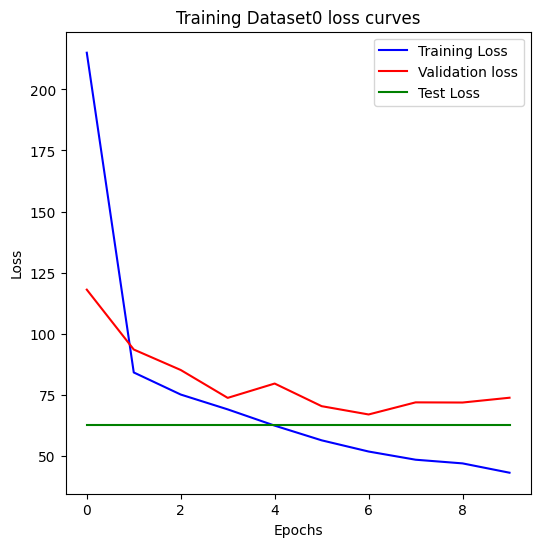

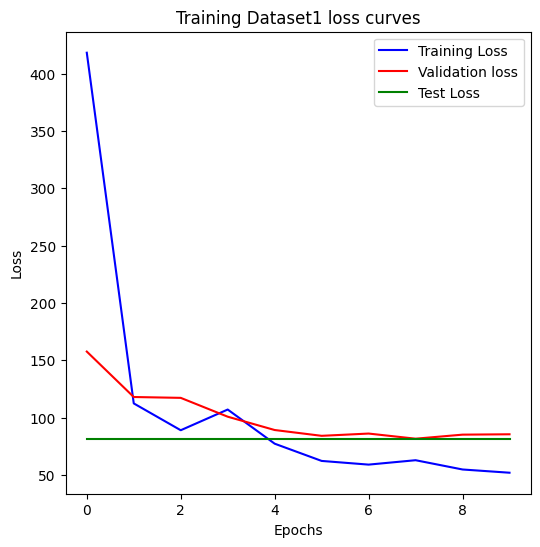

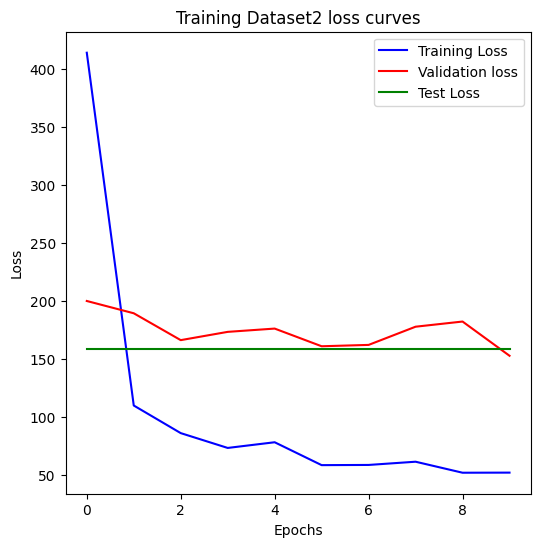

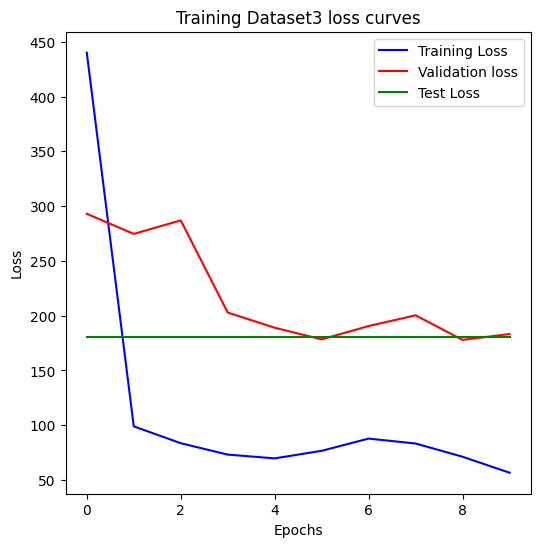

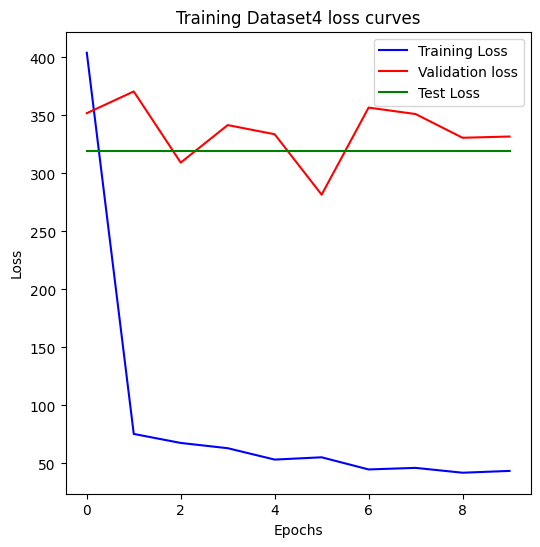

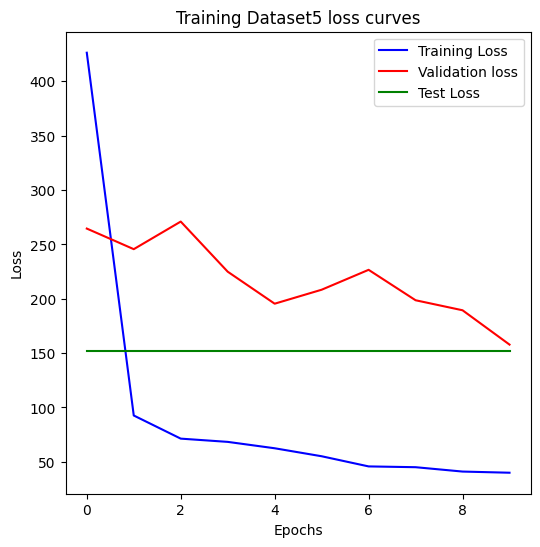

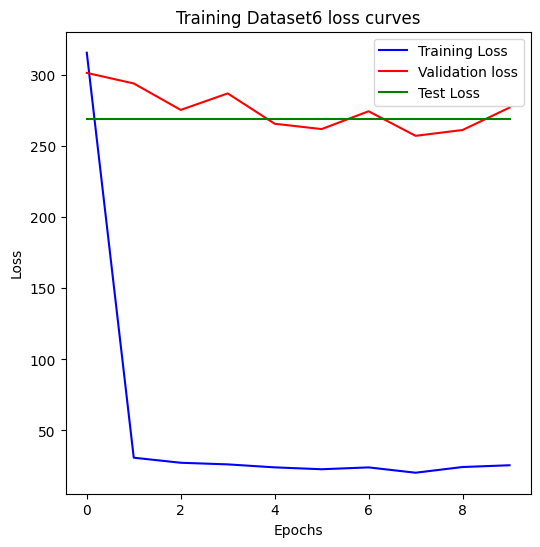

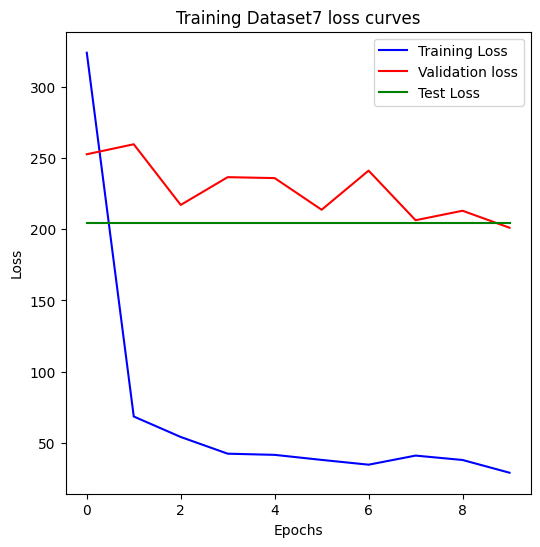

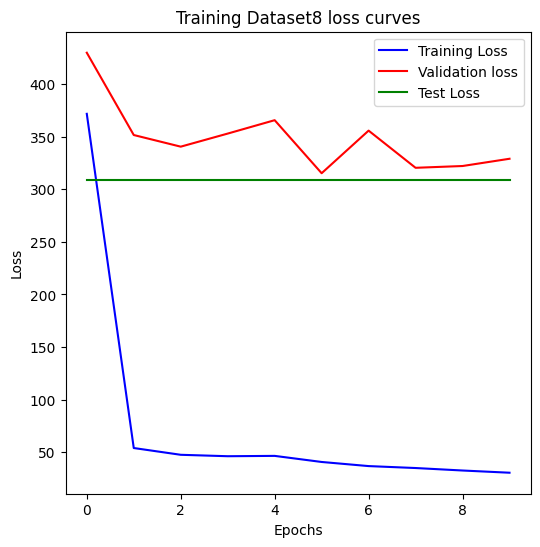

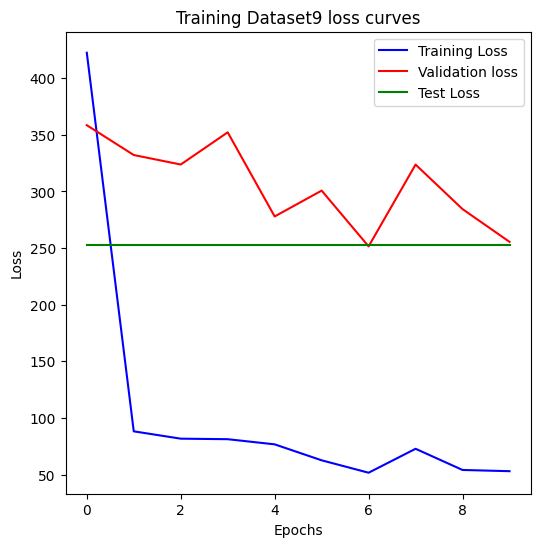

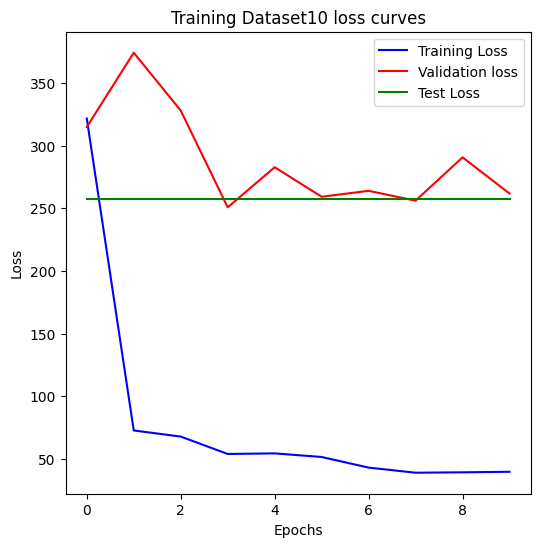

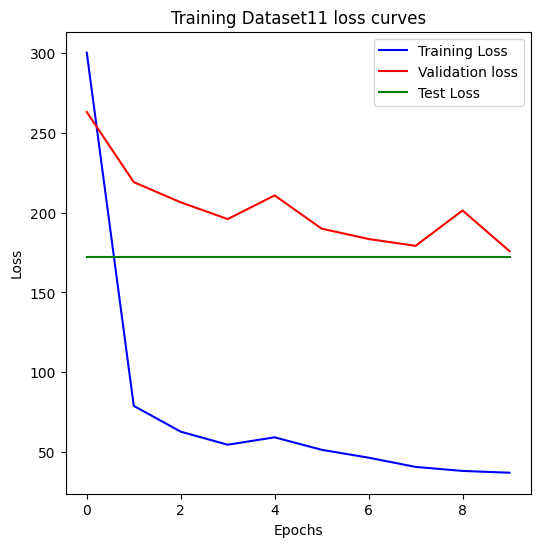

In [54]:
#plotting graphs:
plt.rcParams['figure.figsize'] = (6, 6)
for i in range(len(tlosses)):
    plot_loss_curves(tlosses[i], vlosses[i], tst_losses[i], epochs=10, model_name=f"Training Dataset{i}")

#### 2) Margin Forgetting Loss model

In [55]:
class SiFer_margin(nn.Module):
    def __init__(self, block, num_classes, aux_pos = 1, aux_kernels = [128, 128], layers = [3, 4]):
        super(SiFer_margin, self).__init__()
        self.num_classes = num_classes
        self.aux_pos = aux_pos + 4
        # main network
        network = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in network.parameters():
            param.requires_grad = True
        
        self.layers = nn.ModuleList(list(network.children())[:-1])
        self.layers.append(nn.Linear(512, num_classes))

        # Auxiliary Network
        self.aux_layers = nn.ModuleList([])
        
        self.inplanes = 128
        for kernel_id in range(len(aux_kernels)):
            self.aux_layers.append(self.__make_layer(block, aux_kernels[kernel_id], layers[kernel_id], stride = 2))
            
        self.aux_layers.append(nn.AvgPool2d(7, stride=1, padding=2))
        self.aux_layers.append(nn.Linear(512, num_classes))

        # parameters dict
        self.params = nn.ModuleDict({
            "main" : self.layers,
            "aux"  : self.aux_layers,
            'forget': self.layers[:self.aux_pos]
        })
        
    def forward(self, x):
        # forward for the main network
        outputs_main = []
        
        for layer in self.layers[:-1]:
            x = layer(x)
            outputs_main.append(x)

        x = x.view(x.shape[0], -1)
        x = self.layers[-1](x)
        outputs_main.append(x)

        # forward for the aux network
        aux = outputs_main[self.aux_pos]
        for aux_layer in self.aux_layers[:-1]:
            aux = aux_layer(aux)

        aux = aux.view(aux.shape[0], -1)
        aux = self.aux_layers[-1](aux)
        return x, aux

    def __make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

100%|███████████████████████████████████████████████████████████| 10/10 [04:10<00:00, 25.08s/it]


Test Loss: 141.82675170898438
Group test Loss: 169.89050102233887


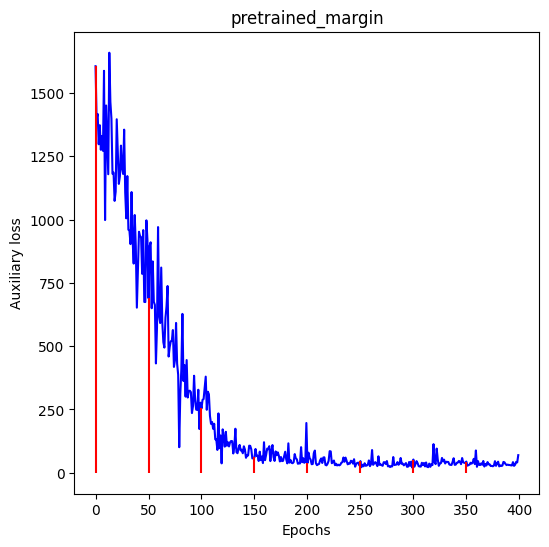

In [56]:
sifer_margin = SiFer_margin(BasicBlock, 1, aux_kernels = [64, 128], layers = [5, 4]).to(device)
sifer_margin, train_losses, val_losses, aux_losses, forget_losses = train_fs_mar(sifer_margin, train_dataloaders[2], val_dataloader, epochs = 10, verbose = False, forget_iters = 50)
test_loss = eval_FSModel(sifer_margin, test_dataloader)
print(f"Test Loss: {test_loss}")
group_eval_fs(sifer_margin, group_dataloaders)

plt.rcParams['figure.figsize'] = (6,6)
plot_aux_losses(aux_losses, model_name = "pretrained_margin", forget_iters = 50)
# plt.plot(range(len(forget_losses)), forget_losses)
plt.show()

In [57]:
# Hyperparameter Tuning
margins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))

for i in range(len(margins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1} / {len(margins) * len(forget_lrs)* len(forget_iters)}] Margin {margins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_margin(BasicBlock, 1, aux_kernels = [128, 128], layers = [5, 4]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_mar(model, train_dataloaders[2], val_dataloader, margin = margins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 5, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)
            print(f"Test Loss: {test_loss}")
            grp_loss = group_eval_fs(model, group_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = grp_loss[0]

best_margin, best_forget_lr, best_forget_iter = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_margin, best_grp_forget_lr, best_grp_forget_iter = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best Margin : {margins[best_margin]} Best Forget LR: {forget_lrs[best_forget_lr]} Best Forget Iter: {forget_iters[best_forget_iter]}")
print(f"Group hyperparameters: \n Best margin: {margins[best_grp_margin]} Best Forget Lr: {forget_lrs[best_grp_forget_lr]} Best Forget Iter: {forget_iters[best_grp_forget_iter]}")

[1 / 96] Margin 2 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.86s/it]


Test Loss: 143.60427856445312
Group test Loss: 183.80153274536133
[2 / 96] Margin 2 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.40s/it]


Test Loss: 233.38504028320312
Group test Loss: 212.21966934204102
[3 / 96] Margin 2 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.75s/it]


Test Loss: 154.63189697265625
Group test Loss: 210.023344039917
[4 / 96] Margin 2 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.34s/it]


Test Loss: 132.1781005859375
Group test Loss: 206.03141975402832
[5 / 96] Margin 2 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.76s/it]


Test Loss: 199.14791870117188
Group test Loss: 372.76466178894043
[6 / 96] Margin 2 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.37s/it]


Test Loss: 119.36326599121094
Group test Loss: 176.63812446594238
[7 / 96] Margin 2 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.82s/it]


Test Loss: 130.82131958007812
Group test Loss: 194.10008811950684
[8 / 96] Margin 2 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.44s/it]


Test Loss: 124.99956512451172
Group test Loss: 179.3809642791748
[9 / 96] Margin 2 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.93s/it]


Test Loss: 128.83706665039062
Group test Loss: 243.4861660003662
[10 / 96] Margin 2 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.39s/it]


Test Loss: 131.19708251953125
Group test Loss: 189.79863357543945
[11 / 96] Margin 2 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 141.76710510253906
Group test Loss: 199.93228340148926
[12 / 96] Margin 2 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.36s/it]


Test Loss: 133.58230590820312
Group test Loss: 201.9495449066162
[13 / 96] Margin 10 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.41s/it]


Test Loss: 238.94342041015625
Group test Loss: 285.8484134674072
[14 / 96] Margin 10 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.79s/it]


Test Loss: 169.09564208984375
Group test Loss: 339.0289764404297
[15 / 96] Margin 10 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.20s/it]


Test Loss: 148.4530792236328
Group test Loss: 181.5728530883789
[16 / 96] Margin 10 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 136.59461975097656
Group test Loss: 188.89517211914062
[17 / 96] Margin 10 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.91s/it]


Test Loss: 154.73635864257812
Group test Loss: 261.7144031524658
[18 / 96] Margin 10 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.39s/it]


Test Loss: 159.67918395996094
Group test Loss: 185.1752815246582
[19 / 96] Margin 10 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.99s/it]


Test Loss: 121.14895629882812
Group test Loss: 193.97335243225098
[20 / 96] Margin 10 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.72s/it]


Test Loss: 204.4906463623047
Group test Loss: 264.5593719482422
[21 / 96] Margin 10 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.98s/it]


Test Loss: 125.57332611083984
Group test Loss: 167.12396049499512
[22 / 96] Margin 10 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 128.7951202392578
Group test Loss: 208.18307495117188
[23 / 96] Margin 10 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 123.07292938232422
Group test Loss: 190.31232070922852
[24 / 96] Margin 10 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.73s/it]


Test Loss: 144.7039794921875
Group test Loss: 230.82147407531738
[25 / 96] Margin 25 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.02s/it]


Test Loss: 152.79368591308594
Group test Loss: 201.25678253173828
[26 / 96] Margin 25 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 137.30828857421875
Group test Loss: 214.20531272888184
[27 / 96] Margin 25 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.34s/it]


Test Loss: 150.18553161621094
Group test Loss: 323.2294692993164
[28 / 96] Margin 25 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.54s/it]


Test Loss: 163.35508728027344
Group test Loss: 177.63274383544922
[29 / 96] Margin 25 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.93s/it]


Test Loss: 132.25155639648438
Group test Loss: 207.59608840942383
[30 / 96] Margin 25 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.49s/it]


Test Loss: 119.94572448730469
Group test Loss: 207.35587310791016
[31 / 96] Margin 25 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.90s/it]


Test Loss: 206.7915802001953
Group test Loss: 199.01325798034668
[32 / 96] Margin 25 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.56s/it]


Test Loss: 151.75137329101562
Group test Loss: 236.29844665527344
[33 / 96] Margin 25 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.92s/it]


Test Loss: 187.6521453857422
Group test Loss: 243.32288932800293
[34 / 96] Margin 25 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.52s/it]


Test Loss: 138.77801513671875
Group test Loss: 301.72363662719727
[35 / 96] Margin 25 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.96s/it]


Test Loss: 138.42184448242188
Group test Loss: 199.1529598236084
[36 / 96] Margin 25 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.62s/it]


Test Loss: 146.77667236328125
Group test Loss: 197.54824256896973
[37 / 96] Margin 30 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.95s/it]


Test Loss: 141.7898712158203
Group test Loss: 230.01763343811035
[38 / 96] Margin 30 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 156.67398071289062
Group test Loss: 180.88706398010254
[39 / 96] Margin 30 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.03s/it]


Test Loss: 167.03195190429688
Group test Loss: 215.89150428771973
[40 / 96] Margin 30 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 138.81175231933594
Group test Loss: 218.3030185699463
[41 / 96] Margin 30 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 357.9441223144531
Group test Loss: 873.2641448974609
[42 / 96] Margin 30 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.58s/it]


Test Loss: 204.1239013671875
Group test Loss: 284.8857879638672
[43 / 96] Margin 30 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.93s/it]


Test Loss: 224.56668090820312
Group test Loss: 278.3137741088867
[44 / 96] Margin 30 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.77s/it]


Test Loss: 150.8841552734375
Group test Loss: 235.51309204101562
[45 / 96] Margin 30 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.92s/it]


Test Loss: 520.9636840820312
Group test Loss: 1334.3058280944824
[46 / 96] Margin 30 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.55s/it]


Test Loss: 171.034912109375
Group test Loss: 195.49691200256348
[47 / 96] Margin 30 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 27.00s/it]


Test Loss: 947.2916259765625
Group test Loss: 2133.1549072265625
[48 / 96] Margin 30 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.56s/it]


Test Loss: 486.693115234375
Group test Loss: 894.4767379760742
[49 / 96] Margin 50 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.99s/it]


Test Loss: 357.0783996582031
Group test Loss: 648.6309776306152
[50 / 96] Margin 50 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 144.5564422607422
Group test Loss: 303.4234027862549
[51 / 96] Margin 50 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.99s/it]


Test Loss: 169.82847595214844
Group test Loss: 176.1087417602539
[52 / 96] Margin 50 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.76s/it]


Test Loss: 173.22393798828125
Group test Loss: 194.64965629577637
[53 / 96] Margin 50 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 187.13693237304688
Group test Loss: 322.87615966796875
[54 / 96] Margin 50 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 233.64031982421875
Group test Loss: 311.49440002441406
[55 / 96] Margin 50 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.00s/it]


Test Loss: 175.3616180419922
Group test Loss: 342.7604503631592
[56 / 96] Margin 50 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.55s/it]


Test Loss: 147.74520874023438
Group test Loss: 190.5699062347412
[57 / 96] Margin 50 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.97s/it]


Test Loss: 285.836669921875
Group test Loss: 613.7353172302246
[58 / 96] Margin 50 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.61s/it]


Test Loss: 359.4163818359375
Group test Loss: 872.5695114135742
[59 / 96] Margin 50 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 248.30838012695312
Group test Loss: 522.7796936035156
[60 / 96] Margin 50 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 178.98358154296875
Group test Loss: 330.0285015106201
[61 / 96] Margin 75 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.88s/it]


Test Loss: 278.01910400390625
Group test Loss: 240.97287368774414
[62 / 96] Margin 75 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 213.69126892089844
Group test Loss: 264.58829498291016
[63 / 96] Margin 75 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.92s/it]


Test Loss: 151.6388702392578
Group test Loss: 187.93208503723145
[64 / 96] Margin 75 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.45s/it]


Test Loss: 130.96273803710938
Group test Loss: 172.98135375976562
[65 / 96] Margin 75 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 300.6097106933594
Group test Loss: 762.2455024719238
[66 / 96] Margin 75 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.47s/it]


Test Loss: 203.49122619628906
Group test Loss: 354.26194763183594
[67 / 96] Margin 75 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.80s/it]


Test Loss: 179.64382934570312
Group test Loss: 231.60871505737305
[68 / 96] Margin 75 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.44s/it]


Test Loss: 144.32949829101562
Group test Loss: 277.120813369751
[69 / 96] Margin 75 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.80s/it]


Test Loss: 275.8950500488281
Group test Loss: 524.972225189209
[70 / 96] Margin 75 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.48s/it]


Test Loss: 281.09674072265625
Group test Loss: 558.6310539245605
[71 / 96] Margin 75 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.76s/it]


Test Loss: 247.63861083984375
Group test Loss: 388.98449325561523
[72 / 96] Margin 75 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.48s/it]


Test Loss: 252.4298095703125
Group test Loss: 446.414119720459
[73 / 96] Margin 90 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.90s/it]


Test Loss: 162.74420166015625
Group test Loss: 273.53332710266113
[74 / 96] Margin 90 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.47s/it]


Test Loss: 172.13250732421875
Group test Loss: 321.7841396331787
[75 / 96] Margin 90 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 155.9467010498047
Group test Loss: 250.05706024169922
[76 / 96] Margin 90 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 171.41952514648438
Group test Loss: 228.68087577819824
[77 / 96] Margin 90 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.85s/it]


Test Loss: 285.359619140625
Group test Loss: 582.6698112487793
[78 / 96] Margin 90 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.30s/it]


Test Loss: 291.7861328125
Group test Loss: 363.9735679626465
[79 / 96] Margin 90 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.85s/it]


Test Loss: 208.6333770751953
Group test Loss: 244.60480117797852
[80 / 96] Margin 90 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.32s/it]


Test Loss: 175.12681579589844
Group test Loss: 317.14832878112793
[81 / 96] Margin 90 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.82s/it]


Test Loss: 372.0198059082031
Group test Loss: 575.7280807495117
[82 / 96] Margin 90 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.44s/it]


Test Loss: 320.0758056640625
Group test Loss: 674.9577369689941
[83 / 96] Margin 90 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 326.9647216796875
Group test Loss: 767.8339462280273
[84 / 96] Margin 90 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.43s/it]


Test Loss: 259.44976806640625
Group test Loss: 588.8704242706299
[85 / 96] Margin 100 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.83s/it]


Test Loss: 320.647216796875
Group test Loss: 642.3909225463867
[86 / 96] Margin 100 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.37s/it]


Test Loss: 124.40463256835938
Group test Loss: 201.5344696044922
[87 / 96] Margin 100 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 131.0898895263672
Group test Loss: 188.02089881896973
[88 / 96] Margin 100 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.50s/it]


Test Loss: 131.86337280273438
Group test Loss: 224.57399368286133
[89 / 96] Margin 100 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.94s/it]


Test Loss: 255.95799255371094
Group test Loss: 497.53417205810547
[90 / 96] Margin 100 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 298.9653015136719
Group test Loss: 523.7024269104004
[91 / 96] Margin 100 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.80s/it]


Test Loss: 191.51885986328125
Group test Loss: 286.6248588562012
[92 / 96] Margin 100 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.63s/it]


Test Loss: 125.98514556884766
Group test Loss: 193.27760696411133
[93 / 96] Margin 100 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.80s/it]


Test Loss: 343.29144287109375
Group test Loss: 479.24861907958984
[94 / 96] Margin 100 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.38s/it]


Test Loss: 256.61279296875
Group test Loss: 447.8794937133789
[95 / 96] Margin 100 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.85s/it]


Test Loss: 577.2435302734375
Group test Loss: 1281.7145919799805
[96 / 96] Margin 100 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.40s/it]


Test Loss: 257.6718444824219
Group test Loss: 631.9090461730957
Best Margin : 2 Best Forget LR: 0.005 Best Forget Iter: 5
Group hyperparameters: 
 Best margin: 10 Best Forget Lr: 0.05 Best Forget Iter: 2


In [58]:
fs_tlosses = []
fs_vlosses = []
fs_tst_losses = []
fs_grp_tst_losses = []
fs_grp_tst_losses_t = []
fs_grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

fs_grp_wise_losses_t =  {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
#####
margins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_margin = margins.index(2)
best_forget_iter = forget_iters.index(5)
best_forget_lr = forget_lrs.index(0.0005)
#####

for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = SiFer_margin(BasicBlock, 1,aux_kernels = [128, 128], layers = [3, 4]).to(device)
    model, train_losses, val_losses, _, _ = train_fs_mar(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 10, margin=margins[best_margin], forget_iters=forget_iters[best_forget_iter], lrs=[5e-4, 5e-4, forget_lrs[best_forget_lr]])
    test_loss = eval_FSModel(model, test_dataloader)
    print(f"Test Loss: {test_loss}")
    group_loss, groups = group_eval_fs(model, group_dataloaders)
    group_loss_t, groups_t = group_eval_fs(model, train_group_dataloaders[i])

    fs_tlosses.append(train_losses)
    fs_vlosses.append(val_losses)
    fs_tst_losses.append(test_loss)
    fs_grp_tst_losses.append(group_loss)
    fs_grp_tst_losses_t.append(group_loss_t)

    fs_grp_wise_losses['m yng'].append(groups['m yng'])
    fs_grp_wise_losses['m old'].append(groups['m old'])
    fs_grp_wise_losses['f yng'].append(groups['f yng'])
    fs_grp_wise_losses['f old'].append(groups['f old'])

    
    fs_grp_wise_losses_t['m yng'].append(groups_t['m yng'])
    fs_grp_wise_losses_t['m old'].append(groups_t['m old'])
    fs_grp_wise_losses_t['f yng'].append(groups_t['f yng'])
    fs_grp_wise_losses_t['f old'].append(groups_t['f old'])
    
    torch.save(model.state_dict(), f"./Models/fs_mar_model{i}.pth")
    print(f"Model saved to ./Models/fs_mar_model{i}.pth")

[1/12] Complete Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [09:52<00:00, 59.20s/it]


Test Loss: 55.732513427734375
Group test Loss: 89.38609600067139
Group test Loss: 24.9928777217865
Model saved to ./Models/fs_mar_model0.pth
[2/12] No Bias Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.36s/it]


Test Loss: 70.05477142333984
Group test Loss: 107.66907691955566
Group test Loss: 29.74925136566162
Model saved to ./Models/fs_mar_model1.pth
[3/12] Training dataset 1


100%|███████████████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.21s/it]


Test Loss: 112.24266815185547
Group test Loss: 163.10928344726562
Group test Loss: 14.412343343098959
Model saved to ./Models/fs_mar_model2.pth
[4/12] Training dataset 2


100%|███████████████████████████████████████████████████████████| 10/10 [04:14<00:00, 25.42s/it]


Test Loss: 133.59994506835938
Group test Loss: 215.2570571899414
Group test Loss: 25.702434539794922
Model saved to ./Models/fs_mar_model3.pth
[5/12] Training dataset 3


100%|███████████████████████████████████████████████████████████| 10/10 [04:15<00:00, 25.56s/it]


Test Loss: 359.98876953125
Group test Loss: 336.8688278198242
Group test Loss: 44.3098570505778
Model saved to ./Models/fs_mar_model4.pth
[6/12] Training dataset 4


100%|███████████████████████████████████████████████████████████| 10/10 [04:17<00:00, 25.75s/it]


Test Loss: 152.0775909423828
Group test Loss: 184.66167831420898
Group test Loss: 27.514540036519367
Model saved to ./Models/fs_mar_model5.pth
[7/12] Training dataset 5


100%|███████████████████████████████████████████████████████████| 10/10 [04:19<00:00, 25.93s/it]


Test Loss: 222.41302490234375
Group test Loss: 447.92172622680664
Group test Loss: 29.359639485677082
Model saved to ./Models/fs_mar_model6.pth
[8/12] Training dataset 6


100%|███████████████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.14s/it]


Test Loss: 200.34800720214844
Group test Loss: 504.24202728271484
Group test Loss: 39.043624560038246
Model saved to ./Models/fs_mar_model7.pth
[9/12] Training dataset 7


100%|███████████████████████████████████████████████████████████| 10/10 [04:18<00:00, 25.88s/it]


Test Loss: 284.2642822265625
Group test Loss: 371.1515884399414
Group test Loss: 19.103179613749187
Model saved to ./Models/fs_mar_model8.pth
[10/12] Training dataset 8


100%|███████████████████████████████████████████████████████████| 10/10 [04:20<00:00, 26.03s/it]


Test Loss: 169.63177490234375
Group test Loss: 213.6606559753418
Group test Loss: 38.85620625813802
Model saved to ./Models/fs_mar_model9.pth
[11/12] Training dataset 9


100%|███████████████████████████████████████████████████████████| 10/10 [04:22<00:00, 26.28s/it]


Test Loss: 219.0985870361328
Group test Loss: 248.49895477294922
Group test Loss: 13.539167404174805
Model saved to ./Models/fs_mar_model10.pth
[12/12] Training dataset 10


100%|███████████████████████████████████████████████████████████| 10/10 [04:22<00:00, 26.25s/it]


Test Loss: 152.7039794921875
Group test Loss: 304.2158603668213
Group test Loss: 11.188859939575195
Model saved to ./Models/fs_mar_model11.pth


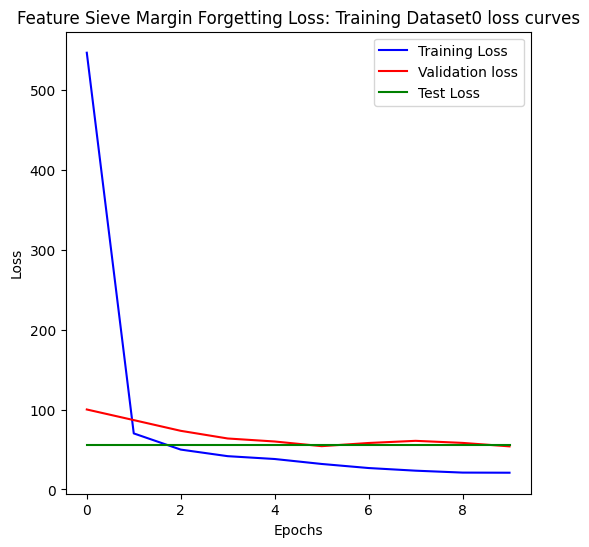

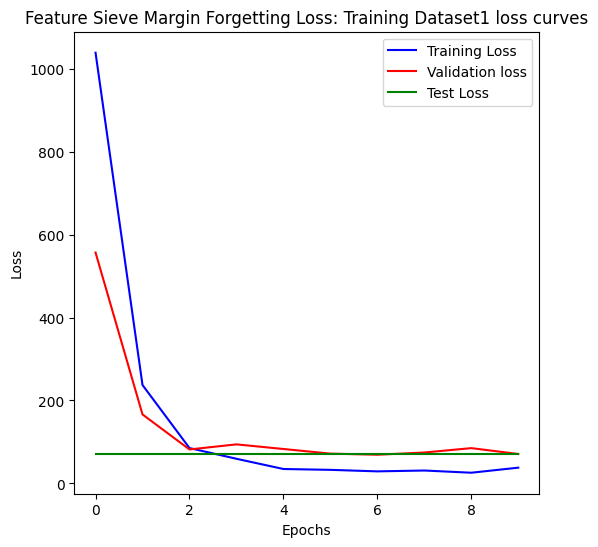

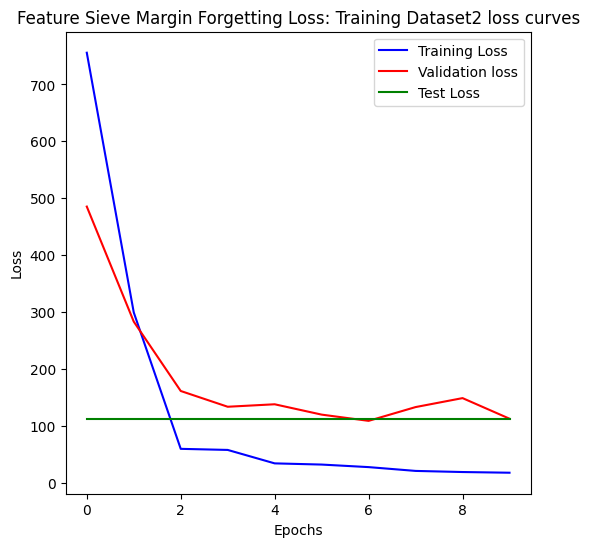

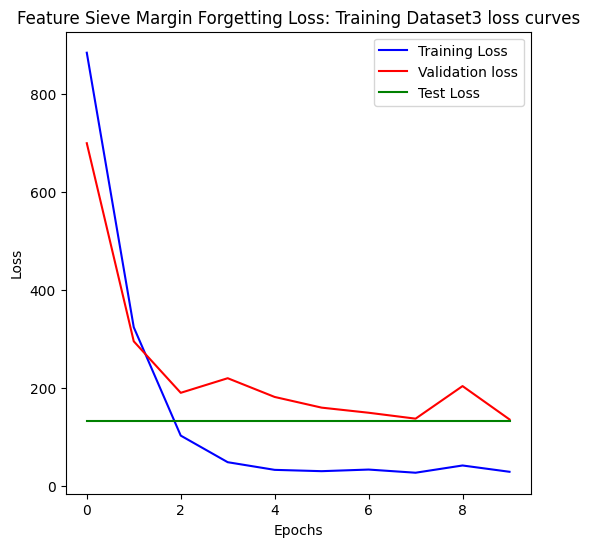

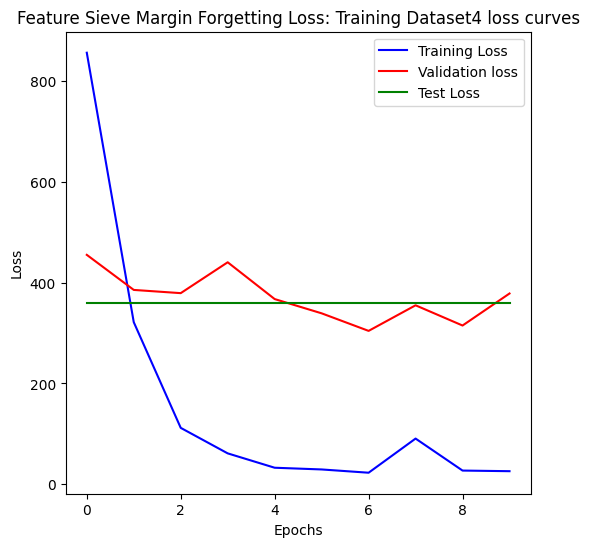

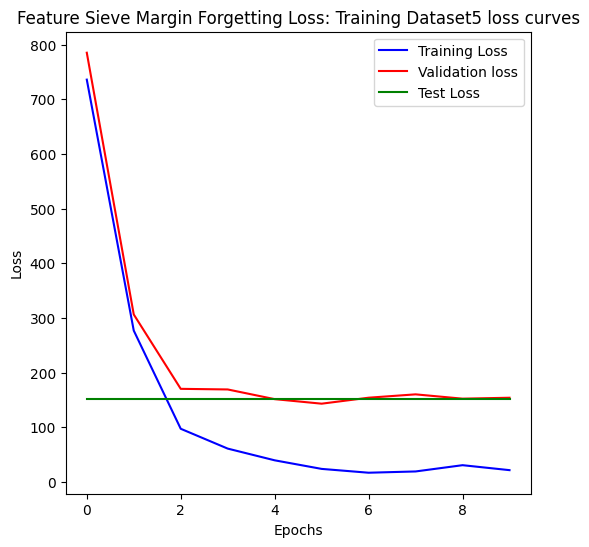

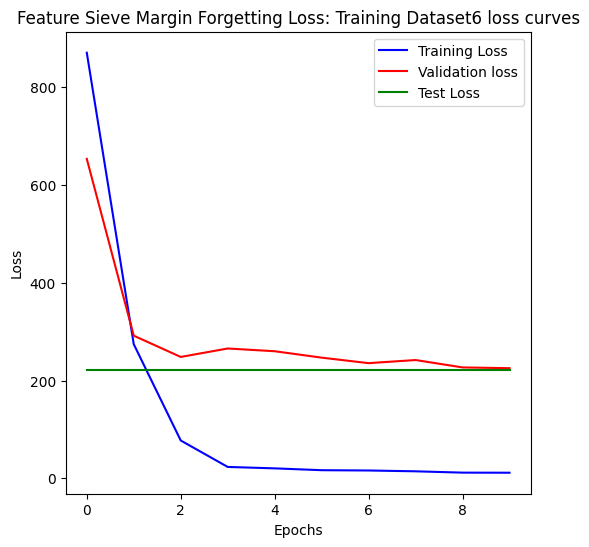

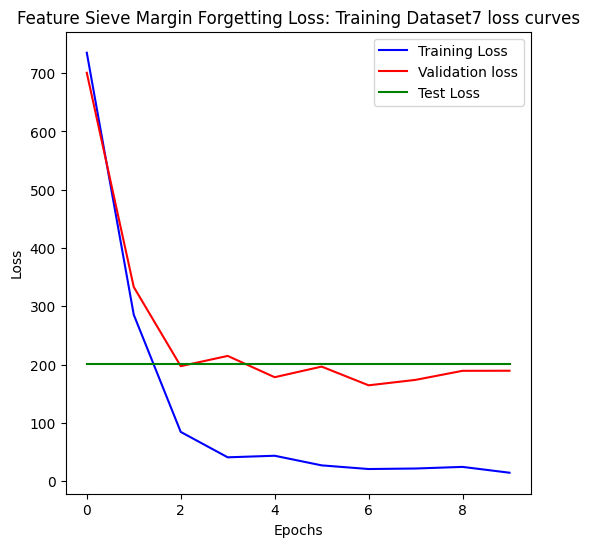

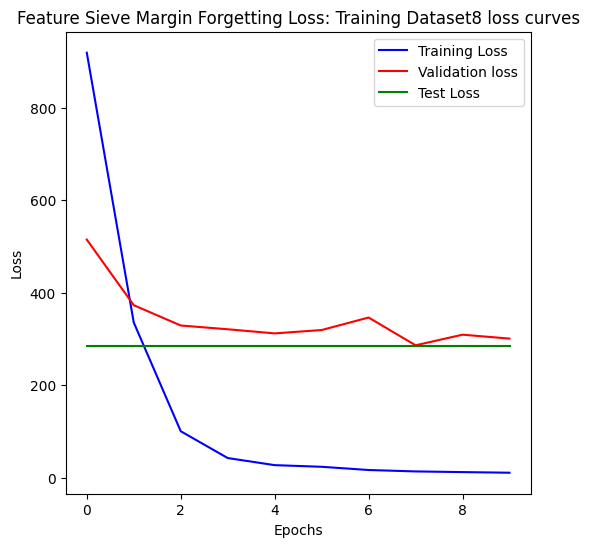

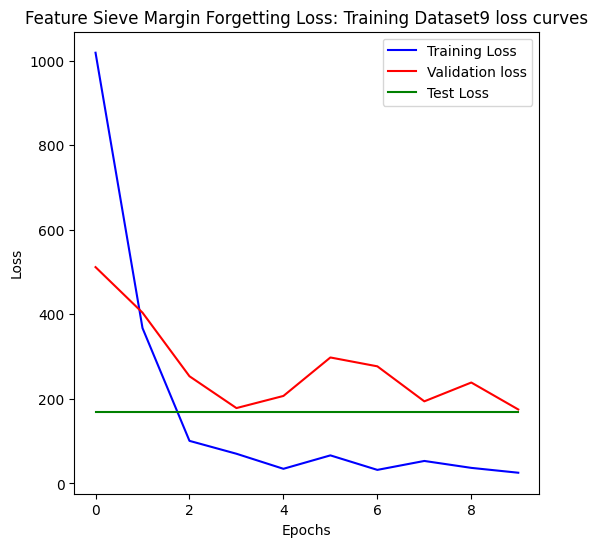

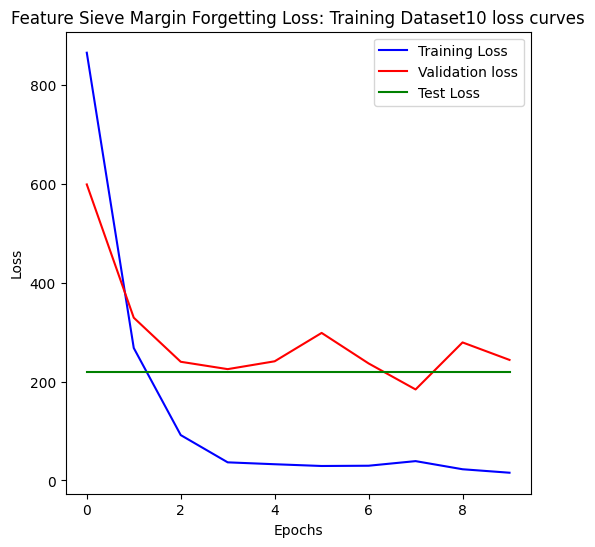

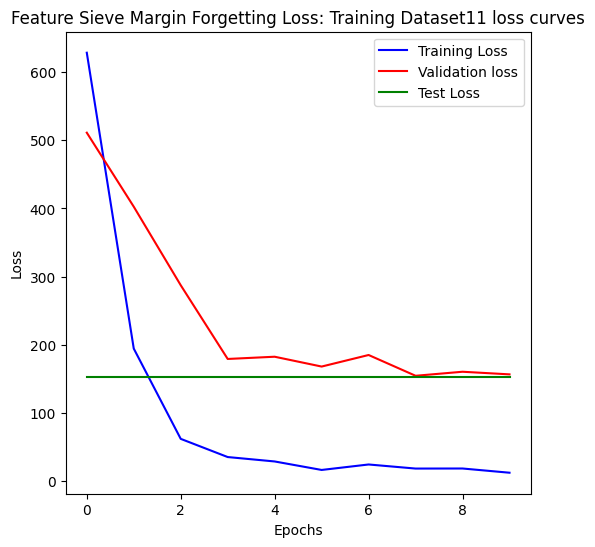

In [59]:
# plotting loss curves
plt.rcParams['figure.figsize'] = (6,6)
for i in range(len(fs_tlosses)):
    plot_loss_curves(fs_tlosses[i], fs_vlosses[i], fs_tst_losses[i], epochs = 10, model_name=f"Feature Sieve Margin Forgetting Loss: Training Dataset{i}")

#### 3) Cross Entropy Forgetting loss

In [60]:
class SiFer_ce(nn.Module):
    def __init__(self, block, num_classes, aux_pos = 1, aux_kernels = [128, 128], layers = [3, 4], num_bins = 20):
        super(SiFer_ce, self).__init__()
        self.num_classes = num_classes
        self.aux_pos = aux_pos + 4
        # main network
        network = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in network.parameters():
            param.requires_grad = True
            
        self.layers = nn.ModuleList(list(network.children())[:-1])
        self.layers.append(nn.Linear(512, num_classes))

        # Auxiliary Network
        self.aux_layers = nn.ModuleList([])
        
        self.inplanes = 128
        for kernel_id in range(len(aux_kernels)):
            self.aux_layers.append(self.__make_layer(block, aux_kernels[kernel_id], layers[kernel_id], stride = 2))
            
        self.aux_layers.append(nn.AvgPool2d(7, stride=1, padding=2))
        self.aux_layers.append(nn.Linear(512, num_bins))

        # parameters dict
        self.params = nn.ModuleDict({
            "main" : self.layers,
            "aux"  : self.aux_layers,
            'forget': self.layers[:self.aux_pos]
        })
        
    def forward(self, x):
        # forward for the main network
        outputs_main = []
        
        for layer in self.layers[:-1]:
            x = layer(x)
            outputs_main.append(x)

        x = x.view(x.shape[0], -1)
        x = self.layers[-1](x)
        outputs_main.append(x)

        # forward for the aux network
        aux = outputs_main[self.aux_pos]
        for aux_layer in self.aux_layers[:-1]:
            aux = aux_layer(aux)

        aux = aux.view(aux.shape[0], -1)
        aux = self.aux_layers[-1](aux)
        return x, aux

    def __make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

100%|███████████████████████████████████████████████████████████| 10/10 [04:20<00:00, 26.07s/it]


Test Loss: 133.96890258789062
Group test Loss: 171.17341232299805


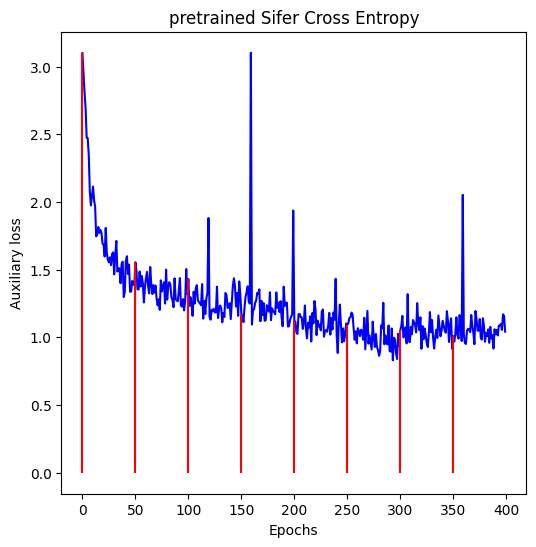

In [61]:
sifer_ce = SiFer_ce(BasicBlock, 1, aux_kernels=[128, 128], layers = [5,4]).to(device)
sifer_ce, train_losses, val_losses, aux_losses, forget_losses = train_fs_ce(sifer_ce, train_dataloaders[2], val_dataloader, ages, verbose = False, epochs = 10, forget_iters = 50)
test_loss = eval_FSModel(sifer_ce, test_dataloader)
print(f"Test Loss: {test_loss}")
group_eval_fs(sifer_ce, group_dataloaders)

plt.rcParams['figure.figsize'] = (6,6)
plot_aux_losses(aux_losses, model_name = "pretrained Sifer Cross Entropy", forget_iters = 50)

In [63]:
#Hyperparameter tuning
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}) Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ce(BasicBlock, 1, num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ce(model, train_dataloaders[2], val_dataloader, ages, num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 5, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ = group_eval_fs(model, group_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins, best_forget_lr_ce, best_forget_iter_ce = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_grp, best_forget_lr_ce_grp, best_forget_iter_ce_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins]} Best Forget LR: {forget_lrs[best_forget_lr_ce]} Best Forget Iter: {forget_iters[best_forget_iter_ce]}")
print("Group Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ce_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ce_grp]}")

1/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.69s/it]


Test Loss: 158.97596740722656
Group test Loss: 262.8959846496582
2/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.10s/it]


Test Loss: 141.84800720214844
Group test Loss: 255.93128204345703
3/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.72s/it]


Test Loss: 173.1824188232422
Group test Loss: 179.3792667388916
4/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.96s/it]


Test Loss: 128.8370819091797
Group test Loss: 186.56866264343262
5/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]


Test Loss: 229.9727325439453
Group test Loss: 486.9782066345215
6/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.16s/it]


Test Loss: 173.22340393066406
Group test Loss: 233.08351135253906
7/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.88s/it]


Test Loss: 140.1900177001953
Group test Loss: 220.08172035217285
8/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.86s/it]


Test Loss: 155.97415161132812
Group test Loss: 259.17277336120605
9/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.08s/it]


Test Loss: 318.271484375
Group test Loss: 672.9247703552246
10/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.95s/it]


Test Loss: 226.76007080078125
Group test Loss: 395.8678321838379
11/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.00s/it]


Test Loss: 278.4403381347656
Group test Loss: 695.5113391876221
12/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.93s/it]


Test Loss: 187.39141845703125
Group test Loss: 295.65656661987305
13/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.04s/it]


Test Loss: 193.8948516845703
Group test Loss: 306.0849609375
14/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.61s/it]


Test Loss: 186.61375427246094
Group test Loss: 465.7831516265869
15/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 129.75723266601562
Group test Loss: 211.01334762573242
16/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.46s/it]


Test Loss: 150.42068481445312
Group test Loss: 194.93369674682617
17/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.51s/it]


Test Loss: 396.22283935546875
Group test Loss: 744.3627853393555
18/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.46s/it]


Test Loss: 289.7876281738281
Group test Loss: 423.26831817626953
19/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 206.0899658203125
Group test Loss: 438.90332412719727
20/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.11s/it]


Test Loss: 164.27035522460938
Group test Loss: 334.1947994232178
21/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.53s/it]


Test Loss: 390.1739501953125
Group test Loss: 872.5268287658691
22/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.39s/it]


Test Loss: 353.0483703613281
Group test Loss: 627.7646980285645
23/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.51s/it]


Test Loss: 368.3025817871094
Group test Loss: 806.4495468139648
24/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.60s/it]


Test Loss: 341.5569152832031
Group test Loss: 542.2376441955566
25/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.92s/it]


Test Loss: 166.41842651367188
Group test Loss: 202.80158233642578
26/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.42s/it]


Test Loss: 251.87803649902344
Group test Loss: 205.26083946228027
27/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.73s/it]


Test Loss: 207.69119262695312
Group test Loss: 205.9786434173584
28/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.40s/it]


Test Loss: 135.57435607910156
Group test Loss: 200.1101894378662
29/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.60s/it]


Test Loss: 593.8687744140625
Group test Loss: 610.7931365966797
30/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.32s/it]


Test Loss: 245.54078674316406
Group test Loss: 443.5264320373535
31/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 217.12557983398438
Group test Loss: 434.792179107666
32/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.48s/it]


Test Loss: 171.84288024902344
Group test Loss: 270.4012813568115
33/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.40s/it]


Test Loss: 395.04034423828125
Group test Loss: 846.9209480285645
34/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.17s/it]


Test Loss: 360.2547912597656
Group test Loss: 804.5599746704102
35/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.05s/it]


Test Loss: 496.81036376953125
Group test Loss: 1210.058090209961
36/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.49s/it]


Test Loss: 340.3999328613281
Group test Loss: 604.2988204956055
37/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.48s/it]


Test Loss: 177.13682556152344
Group test Loss: 271.46240234375
38/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.43s/it]


Test Loss: 163.04510498046875
Group test Loss: 254.2995948791504
39/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.61s/it]


Test Loss: 169.26768493652344
Group test Loss: 296.47536849975586
40/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.35s/it]


Test Loss: 117.63823699951172
Group test Loss: 165.23117065429688
41/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.82s/it]


Test Loss: 421.72613525390625
Group test Loss: 702.3207397460938
42/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.54s/it]


Test Loss: 542.3786010742188
Group test Loss: 548.3412170410156
43/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.64s/it]


Test Loss: 338.46307373046875
Group test Loss: 402.7160415649414
44/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.45s/it]


Test Loss: 164.0088348388672
Group test Loss: 253.5328712463379
45/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.65s/it]


Test Loss: 442.3743896484375
Group test Loss: 927.5488204956055
46/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.38s/it]


Test Loss: 332.3359069824219
Group test Loss: 600.3893013000488
47/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.79s/it]


Test Loss: 378.84979248046875
Group test Loss: 694.2283782958984
48/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.46s/it]


Test Loss: 288.2929382324219
Group test Loss: 599.5597305297852
49/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.93s/it]


Test Loss: 165.94639587402344
Group test Loss: 213.7659034729004
50/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.10s/it]


Test Loss: 160.80032348632812
Group test Loss: 290.42563819885254
51/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.36s/it]


Test Loss: 193.60897827148438
Group test Loss: 214.18441200256348
52/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.87s/it]


Test Loss: 143.54627990722656
Group test Loss: 184.13480377197266
53/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 401.2466125488281
Group test Loss: 1021.1435127258301
54/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.66s/it]


Test Loss: 287.257080078125
Group test Loss: 602.5491485595703
55/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.55s/it]


Test Loss: 244.47088623046875
Group test Loss: 372.6411666870117
56/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.45s/it]


Test Loss: 155.37791442871094
Group test Loss: 244.6803493499756
57/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.54s/it]


Test Loss: 397.7564697265625
Group test Loss: 888.5144805908203
58/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.60s/it]


Test Loss: 302.8148193359375
Group test Loss: 597.5689964294434
59/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.87s/it]


Test Loss: 449.1129455566406
Group test Loss: 832.8717575073242
60/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.22s/it]


Test Loss: 318.2510986328125
Group test Loss: 585.363899230957
61/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 148.29757690429688
Group test Loss: 278.42625999450684
62/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.57s/it]


Test Loss: 129.82484436035156
Group test Loss: 181.04538917541504
63/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 207.76116943359375
Group test Loss: 180.5263671875
64/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.52s/it]


Test Loss: 119.44879913330078
Group test Loss: 158.96868896484375
65/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.69s/it]


Test Loss: 326.66461181640625
Group test Loss: 705.1701431274414
66/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.39s/it]


Test Loss: 247.0718536376953
Group test Loss: 477.2997589111328
67/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.49s/it]


Test Loss: 213.86614990234375
Group test Loss: 342.5557327270508
68/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.20s/it]


Test Loss: 162.6000213623047
Group test Loss: 180.98480987548828
69/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.56s/it]


Test Loss: 369.9909973144531
Group test Loss: 629.1107864379883
70/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.36s/it]


Test Loss: 428.87530517578125
Group test Loss: 576.0389099121094
71/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.42s/it]


Test Loss: 410.498779296875
Group test Loss: 1009.2041320800781
72/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.15s/it]


Test Loss: 290.6886901855469
Group test Loss: 566.0747756958008
73/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.11s/it]


Test Loss: 153.58987426757812
Group test Loss: 256.6735305786133
74/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.44s/it]


Test Loss: 200.15505981445312
Group test Loss: 179.74731826782227
75/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 127.68453216552734
Group test Loss: 179.05697631835938
76/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.51s/it]


Test Loss: 197.06849670410156
Group test Loss: 437.0014419555664
77/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.52s/it]


Test Loss: 498.23883056640625
Group test Loss: 731.8579177856445
78/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 264.4469909667969
Group test Loss: 548.709888458252
79/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.74s/it]


Test Loss: 230.7398223876953
Group test Loss: 368.1350517272949
80/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.01s/it]


Test Loss: 167.01947021484375
Group test Loss: 176.09869194030762
81/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.28s/it]


Test Loss: 398.6012878417969
Group test Loss: 980.9082908630371
82/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.34s/it]


Test Loss: 371.8820495605469
Group test Loss: 820.7387619018555
83/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.57s/it]


Test Loss: 344.5347595214844
Group test Loss: 721.0739097595215
84/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.06s/it]


Test Loss: 318.6037292480469
Group test Loss: 614.5526924133301
85/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.45s/it]


Test Loss: 167.69984436035156
Group test Loss: 294.7613048553467
86/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.91s/it]


Test Loss: 133.35206604003906
Group test Loss: 239.29239654541016
87/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.17s/it]


Test Loss: 288.2825012207031
Group test Loss: 553.4089813232422
88/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.48s/it]


Test Loss: 129.61691284179688
Group test Loss: 246.81008529663086
89/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.05s/it]


Test Loss: 402.8855895996094
Group test Loss: 565.8376388549805
90/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.49s/it]


Test Loss: 234.9947509765625
Group test Loss: 459.0797348022461
91/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.72s/it]


Test Loss: 185.14291381835938
Group test Loss: 346.228271484375
92/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.15s/it]


Test Loss: 166.2034149169922
Group test Loss: 210.80178833007812
93/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.78s/it]


Test Loss: 414.126953125
Group test Loss: 596.3359527587891
94/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.77s/it]


Test Loss: 298.4969787597656
Group test Loss: 524.2025871276855
95/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it]


Test Loss: 382.2010803222656
Group test Loss: 678.9928894042969
96/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.80s/it]


Test Loss: 319.0010986328125
Group test Loss: 728.9417915344238
Test Loss Hyperparameters
Best num_bins : 30 Best Forget LR: 0.0001 Best Forget Iter: 5
Group Loss Hyperparameters
Best num_bins : 75 Best Forget LR: 0.0001 Best Forget Iter: 5


In [64]:
fs_ce_tlosses = []
fs_ce_vlosses = []
fs_ce_tst_losses = []
fs_ce_grp_tst_losses = []
fs_ce_grp_tst_losses_t = []

fs_ce_grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

fs_ce_grp_wise_losses_t = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

####
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_num_bins_grp = num_bins.index(10)
best_forget_iter_ce_grp = forget_iters.index(2)
best_forget_lr_ce_grp = forget_lrs.index(0.0001)
####

for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = SiFer_ce(BasicBlock, 1, num_bins = num_bins[best_num_bins_grp], aux_kernels = [128, 128], layers = [4, 5]).to(device)
    model, train_losses, val_losses, _, _ = train_fs_ce(model, train_dataloaders[i], val_dataloader, ages, verbose = False, epochs = 10, num_bins=num_bins[best_num_bins_grp], forget_iters=forget_iters[best_forget_iter_ce_grp], lrs=[5e-4, 5e-4, forget_lrs[best_forget_lr_ce_grp]])
    test_loss = eval_FSModel(model, test_dataloader)
    print(f"Test Loss: {test_loss}")
    
    group_loss, groups = group_eval_fs(model, group_dataloaders)
    group_loss_t, groups_t = group_eval_fs(model, train_group_dataloaders[i])

    fs_ce_tlosses.append(train_losses)
    fs_ce_vlosses.append(val_losses)
    fs_ce_tst_losses.append(test_loss)
    fs_ce_grp_tst_losses.append(group_loss)
    fs_ce_grp_tst_losses_t.append(group_loss_t)

    fs_ce_grp_wise_losses['m yng'].append(groups['m yng'])
    fs_ce_grp_wise_losses['m old'].append(groups['m old'])
    fs_ce_grp_wise_losses['f yng'].append(groups['f yng'])
    fs_ce_grp_wise_losses['f old'].append(groups['f old'])
    
    fs_ce_grp_wise_losses_t['m yng'].append(groups_t['m yng'])
    fs_ce_grp_wise_losses_t['m old'].append(groups_t['m old'])
    fs_ce_grp_wise_losses_t['f yng'].append(groups_t['f yng'])
    fs_ce_grp_wise_losses_t['f old'].append(groups_t['f old'])

    torch.save(model.state_dict(), f"./Models/fs_ce_model{i}.pth")
    print(f"Model saved to ./Models/fs_ce_model{i}.pth")

[1/12] Complete Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.52s/it]


Test Loss: 59.71813201904297
Group test Loss: 83.01596260070801
Group test Loss: 24.972388744354248
Model saved to ./Models/fs_ce_model0.pth
[2/12] No Bias Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [04:40<00:00, 28.01s/it]


Test Loss: 76.6886215209961
Group test Loss: 119.08566474914551
Group test Loss: 33.99974060058594
Model saved to ./Models/fs_ce_model1.pth
[3/12] Training dataset 1


100%|███████████████████████████████████████████████████████████| 10/10 [04:38<00:00, 27.84s/it]


Test Loss: 142.43240356445312
Group test Loss: 259.2106132507324
Group test Loss: 94.91447512308757
Model saved to ./Models/fs_ce_model2.pth
[4/12] Training dataset 2


100%|███████████████████████████████████████████████████████████| 10/10 [04:52<00:00, 29.29s/it]


Test Loss: 159.9842529296875
Group test Loss: 250.48761177062988
Group test Loss: 23.046982765197754
Model saved to ./Models/fs_ce_model3.pth
[5/12] Training dataset 3


100%|███████████████████████████████████████████████████████████| 10/10 [04:38<00:00, 27.83s/it]


Test Loss: 266.9872741699219
Group test Loss: 282.1065902709961
Group test Loss: 18.066816012064617
Model saved to ./Models/fs_ce_model4.pth
[6/12] Training dataset 4


100%|███████████████████████████████████████████████████████████| 10/10 [04:38<00:00, 27.85s/it]


Test Loss: 160.29823303222656
Group test Loss: 210.11677169799805
Group test Loss: 21.175671577453613
Model saved to ./Models/fs_ce_model5.pth
[7/12] Training dataset 5


100%|███████████████████████████████████████████████████████████| 10/10 [04:35<00:00, 27.55s/it]


Test Loss: 244.51344299316406
Group test Loss: 404.84582138061523
Group test Loss: 20.839362780253094
Model saved to ./Models/fs_ce_model6.pth
[8/12] Training dataset 6


100%|███████████████████████████████████████████████████████████| 10/10 [04:41<00:00, 28.19s/it]


Test Loss: 185.32742309570312
Group test Loss: 423.0013732910156
Group test Loss: 30.990482648213703
Model saved to ./Models/fs_ce_model7.pth
[9/12] Training dataset 7


100%|███████████████████████████████████████████████████████████| 10/10 [04:41<00:00, 28.18s/it]


Test Loss: 320.2992248535156
Group test Loss: 343.63269805908203
Group test Loss: 12.425663312276205
Model saved to ./Models/fs_ce_model8.pth
[10/12] Training dataset 8


100%|███████████████████████████████████████████████████████████| 10/10 [04:39<00:00, 27.91s/it]


Test Loss: 297.3350830078125
Group test Loss: 262.7095642089844
Group test Loss: 35.800732930501304
Model saved to ./Models/fs_ce_model9.pth
[11/12] Training dataset 9


100%|███████████████████████████████████████████████████████████| 10/10 [04:42<00:00, 28.20s/it]


Test Loss: 219.94393920898438
Group test Loss: 230.77670669555664
Group test Loss: 12.815448760986328
Model saved to ./Models/fs_ce_model10.pth
[12/12] Training dataset 10


100%|███████████████████████████████████████████████████████████| 10/10 [04:43<00:00, 28.37s/it]


Test Loss: 147.96554565429688
Group test Loss: 316.685302734375
Group test Loss: 24.94223626454671
Model saved to ./Models/fs_ce_model11.pth


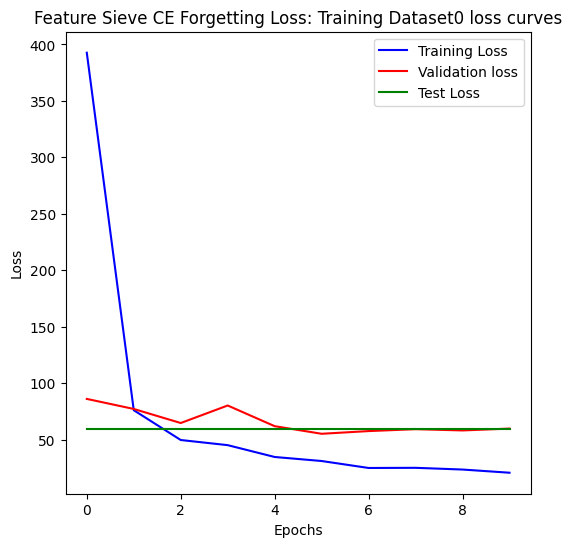

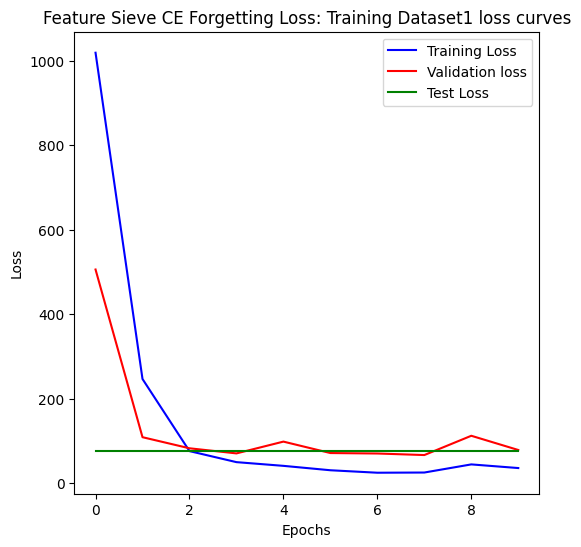

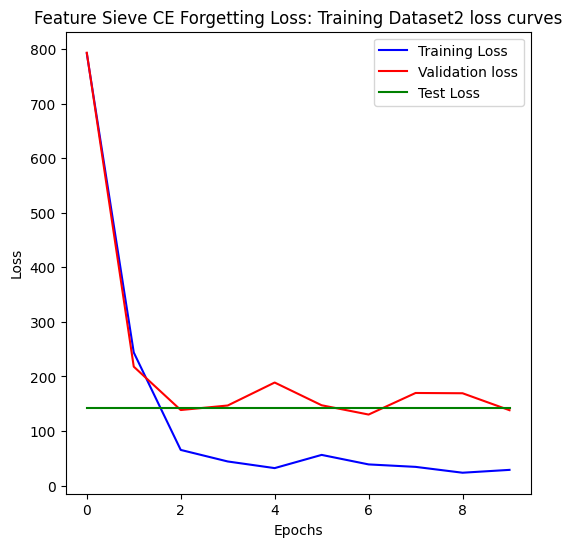

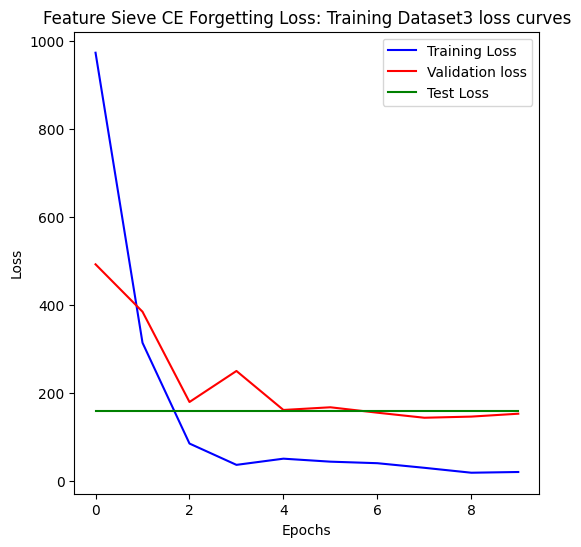

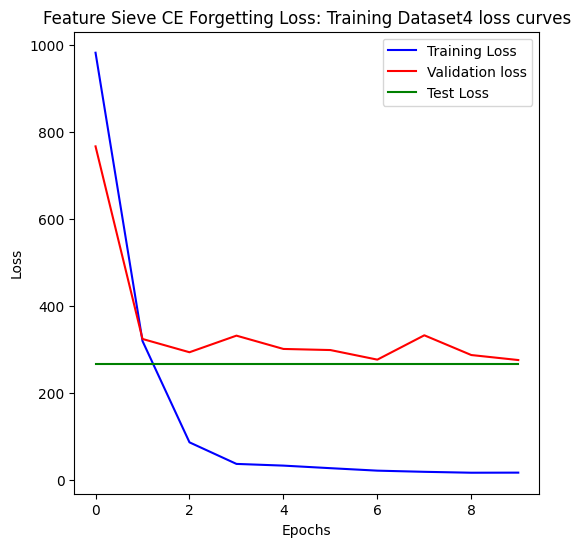

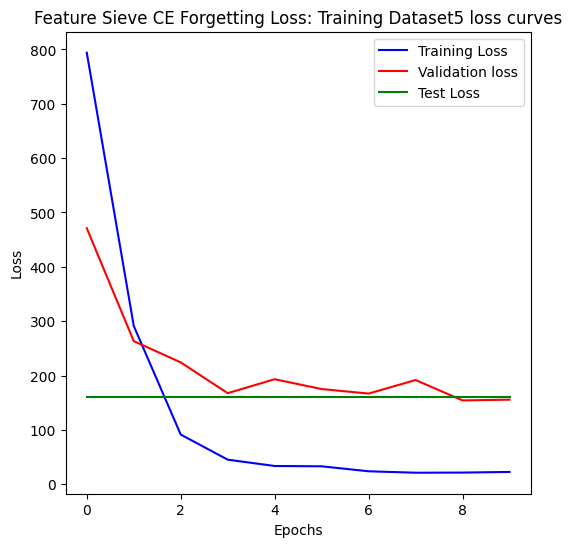

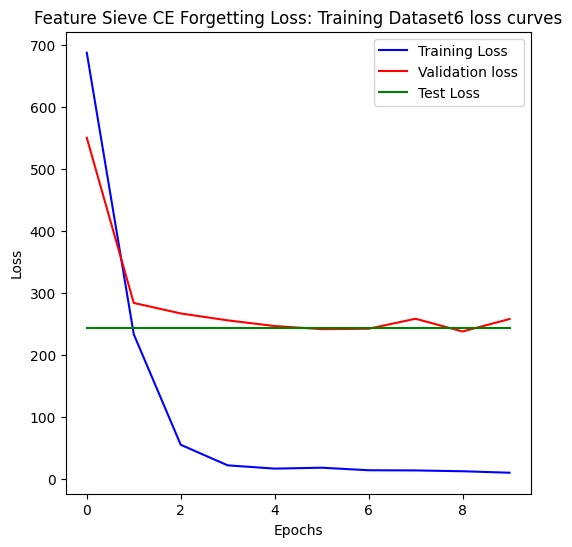

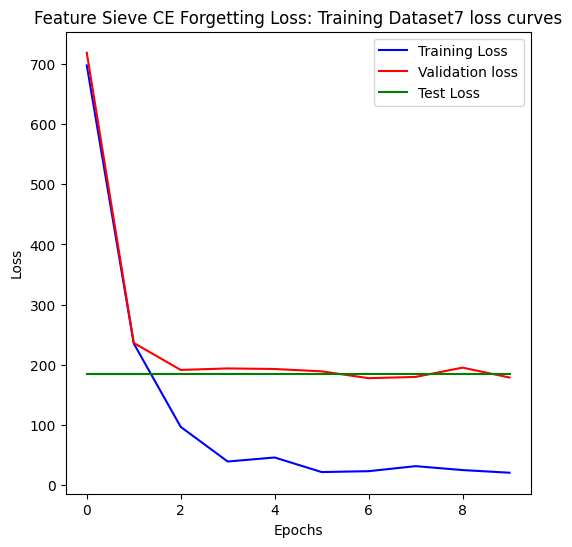

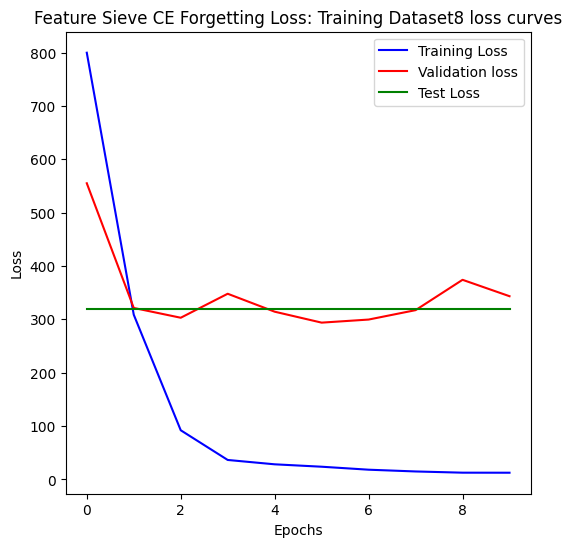

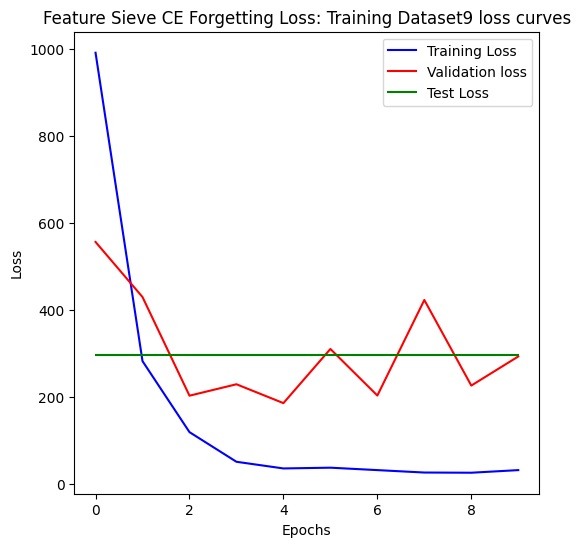

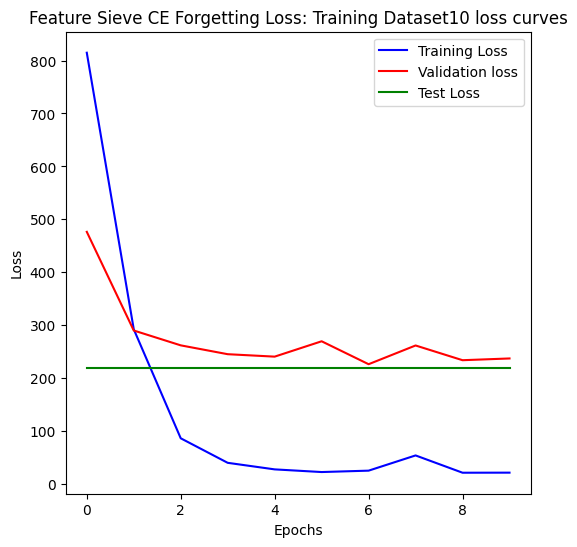

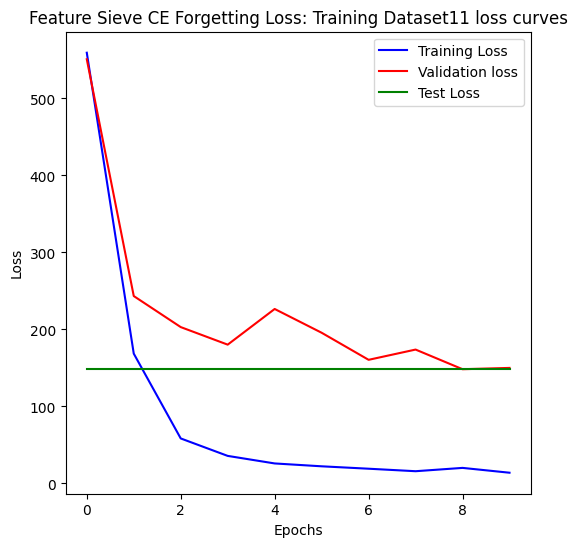

In [65]:
# plotting loss curves
for i in range(len(fs_ce_tlosses)):
    plot_loss_curves(fs_ce_tlosses[i], fs_ce_vlosses[i], fs_ce_tst_losses[i], epochs = 10, model_name=f"Feature Sieve CE Forgetting Loss: Training Dataset{i}")

#### 4) Ordinal Forgetting loss

In [66]:
class SiFer_ord(nn.Module):
    def __init__(self, block, num_classes, aux_pos = 1, aux_kernels = [128, 128], layers = [3, 4], num_bins = 20):
        super(SiFer_ord, self).__init__()
        self.num_classes = num_classes
        self.aux_pos = aux_pos + 4
        # main network
        network = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in network.parameters():
            param.requires_grad = True
            
        self.layers = nn.ModuleList(list(network.children())[:-1])
        self.layers.append(nn.Linear(512, num_classes))

        # Auxiliary Network
        self.aux_layers = nn.ModuleList([])
        
        self.inplanes = 128
        for kernel_id in range(len(aux_kernels)):
            self.aux_layers.append(self.__make_layer(block, aux_kernels[kernel_id], layers[kernel_id], stride = 2))
            
        self.aux_layers.append(nn.AvgPool2d(7, stride=1, padding=2))
        self.aux_layers.append(nn.Linear(512, num_bins))

        # parameters dict
        self.params = nn.ModuleDict({
            "main" : self.layers,
            "aux"  : self.aux_layers,
            'forget': self.layers[:self.aux_pos]
        })
        
    def forward(self, x):
        # forward for the main network
        outputs_main = []
        
        for layer in self.layers[:-1]:
            x = layer(x)
            outputs_main.append(x)

        x = x.view(x.shape[0], -1)
        x = self.layers[-1](x)
        outputs_main.append(x)

        # forward for the aux network
        aux = outputs_main[self.aux_pos]
        for aux_layer in self.aux_layers[:-1]:
            aux = aux_layer(aux)

        aux = aux.view(aux.shape[0], -1)
        aux = self.aux_layers[-1](aux)
        return x, aux

    def __make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

100%|███████████████████████████████████████████████████████████| 10/10 [04:23<00:00, 26.40s/it]


Test Loss: 199.30242919921875
Group test Loss: 397.10905838012695


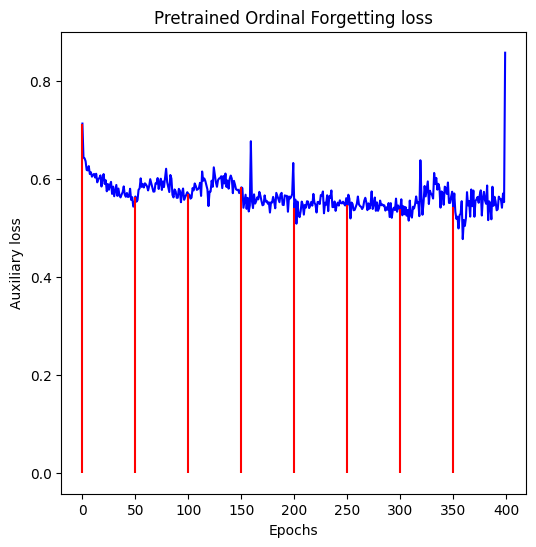

In [67]:
sifer_ord = SiFer_ord(BasicBlock, 1, num_bins = 10, aux_kernels = [128, 128], layers = [5,4]).to(device)
sifer_ord, train_losses, val_losses, aux_losses, forget_losses = train_fs_ord(sifer_ord, train_dataloaders[2], val_dataloader, verbose = False, epochs = 10, forget_iters = 50,num_bins = 10)
test_loss = eval_FSModel(sifer_ord, test_dataloader)
print(f"Test Loss: {test_loss}")
group_eval_fs(sifer_ord, group_dataloaders)

plot_aux_losses(aux_losses, model_name = "Pretrained Ordinal Forgetting loss", forget_iters = 50)

In [68]:
# Hyper parameter tuning
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}] Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ord(BasicBlock, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ord(model, train_dataloaders[2], val_dataloader, num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 5, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ =group_eval_fs(model, group_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins_ord, best_forget_lr_ord, best_forget_iter_ord = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_ord_grp, best_forget_lr_ord_grp, best_forget_iter_ord_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters:")
print(f"Best num_bins : {num_bins[best_num_bins_ord]} Best Forget LR: {forget_lrs[best_forget_lr_ord]} Best Forget Iter: {forget_iters[best_forget_iter_ord]}")
print("Group Loss Hyperparameters: ")
print(f"Best num_bins : {num_bins[best_num_bins_ord_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ord_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ord_grp]}")

[1/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.83s/it]


Test Loss: 146.2316436767578
Group test Loss: 214.10904121398926
[2/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]


Test Loss: 168.16270446777344
Group test Loss: 205.4324493408203
[3/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.81s/it]


Test Loss: 140.4163818359375
Group test Loss: 291.264612197876
[4/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.63s/it]


Test Loss: 234.34146118164062
Group test Loss: 202.62611198425293
[5/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.80s/it]


Test Loss: 177.01486206054688
Group test Loss: 240.33423042297363
[6/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.83s/it]


Test Loss: 175.0670928955078
Group test Loss: 224.25079345703125
[7/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.16s/it]


Test Loss: 167.66839599609375
Group test Loss: 189.52637100219727
[8/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.07s/it]


Test Loss: 154.06394958496094
Group test Loss: 197.7621307373047
[9/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.07s/it]


Test Loss: 237.4943084716797
Group test Loss: 362.1021499633789
[10/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.03s/it]


Test Loss: 182.7792205810547
Group test Loss: 270.78361320495605
[11/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.52s/it]


Test Loss: 221.8434600830078
Group test Loss: 263.292573928833
[12/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.77s/it]


Test Loss: 164.87940979003906
Group test Loss: 239.99592399597168
[13/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.79s/it]


Test Loss: 172.99520874023438
Group test Loss: 173.81358528137207
[14/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.31s/it]


Test Loss: 129.9573516845703
Group test Loss: 210.30467224121094
[15/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.93s/it]


Test Loss: 167.19412231445312
Group test Loss: 206.1393051147461
[16/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.70s/it]


Test Loss: 145.3334503173828
Group test Loss: 254.87612342834473
[17/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.95s/it]


Test Loss: 226.4073486328125
Group test Loss: 221.52338409423828
[18/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.51s/it]


Test Loss: 191.15277099609375
Group test Loss: 258.398962020874
[19/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.78s/it]


Test Loss: 175.1336669921875
Group test Loss: 305.7932929992676
[20/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.01s/it]


Test Loss: 134.59913635253906
Group test Loss: 164.64867782592773
[21/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.66s/it]


Test Loss: 284.9708557128906
Group test Loss: 300.87330627441406
[22/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.37s/it]


Test Loss: 283.4979248046875
Group test Loss: 267.07616424560547
[23/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 29.00s/it]


Test Loss: 229.0306396484375
Group test Loss: 229.86859512329102
[24/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.01s/it]


Test Loss: 205.21868896484375
Group test Loss: 222.77235794067383
[25/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.92s/it]


Test Loss: 133.79820251464844
Group test Loss: 194.05327796936035
[26/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.75s/it]


Test Loss: 137.38328552246094
Group test Loss: 190.4320011138916
[27/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.04s/it]


Test Loss: 150.2029266357422
Group test Loss: 204.97442626953125
[28/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.66s/it]


Test Loss: 212.00332641601562
Group test Loss: 173.64089965820312
[29/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.96s/it]


Test Loss: 161.06251525878906
Group test Loss: 216.02460861206055
[30/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.37s/it]


Test Loss: 149.849365234375
Group test Loss: 213.1680030822754
[31/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.20s/it]


Test Loss: 150.73104858398438
Group test Loss: 187.05214881896973
[32/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.88s/it]


Test Loss: 157.5927734375
Group test Loss: 257.77936363220215
[33/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.93s/it]


Test Loss: 228.6592559814453
Group test Loss: 475.73904609680176
[34/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.26s/it]


Test Loss: 208.520263671875
Group test Loss: 402.9703254699707
[35/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.95s/it]


Test Loss: 161.45286560058594
Group test Loss: 207.8580207824707
[36/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]


Test Loss: 164.6734161376953
Group test Loss: 191.14174842834473
[37/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.56s/it]


Test Loss: 160.16217041015625
Group test Loss: 178.5406551361084
[38/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.46s/it]


Test Loss: 137.14210510253906
Group test Loss: 220.47967147827148
[39/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.80s/it]


Test Loss: 119.9463882446289
Group test Loss: 176.3085823059082
[40/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.12s/it]


Test Loss: 128.09461975097656
Group test Loss: 211.55178833007812
[41/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.21s/it]


Test Loss: 145.71932983398438
Group test Loss: 234.87151718139648
[42/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.28s/it]


Test Loss: 153.0448455810547
Group test Loss: 303.8850574493408
[43/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.21s/it]


Test Loss: 146.4590606689453
Group test Loss: 193.89240074157715
[44/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.61s/it]


Test Loss: 114.8844223022461
Group test Loss: 192.59287643432617
[45/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.32s/it]


Test Loss: 233.53485107421875
Group test Loss: 591.1409912109375
[46/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.91s/it]


Test Loss: 279.1994323730469
Group test Loss: 497.4994583129883
[47/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.47s/it]


Test Loss: 183.2257080078125
Group test Loss: 267.42688179016113
[48/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.52s/it]


Test Loss: 165.1956024169922
Group test Loss: 273.34717178344727
[49/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.07s/it]


Test Loss: 134.82781982421875
Group test Loss: 164.46851921081543
[50/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.43s/it]


Test Loss: 144.7067413330078
Group test Loss: 258.15258026123047
[51/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.36s/it]


Test Loss: 139.91726684570312
Group test Loss: 228.57101440429688
[52/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.83s/it]


Test Loss: 141.01287841796875
Group test Loss: 185.87119674682617
[53/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.64s/it]


Test Loss: 139.16831970214844
Group test Loss: 222.71351623535156
[54/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.86s/it]


Test Loss: 220.6104736328125
Group test Loss: 269.38155364990234
[55/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.54s/it]


Test Loss: 137.7734832763672
Group test Loss: 255.3172664642334
[56/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.62s/it]


Test Loss: 109.61121368408203
Group test Loss: 175.916654586792
[57/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.15s/it]


Test Loss: 205.36184692382812
Group test Loss: 501.9219779968262
[58/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.16s/it]


Test Loss: 250.8354034423828
Group test Loss: 520.518913269043
[59/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.51s/it]


Test Loss: 240.71841430664062
Group test Loss: 217.6016960144043
[60/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.49s/it]


Test Loss: 149.4714813232422
Group test Loss: 280.6737003326416
[61/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.79s/it]


Test Loss: 136.87486267089844
Group test Loss: 153.99453926086426
[62/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.43s/it]


Test Loss: 131.3924560546875
Group test Loss: 172.73859977722168
[63/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.24s/it]


Test Loss: 129.69876098632812
Group test Loss: 205.52536582946777
[64/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.07s/it]


Test Loss: 141.9906005859375
Group test Loss: 186.66839027404785
[65/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.05s/it]


Test Loss: 160.0925750732422
Group test Loss: 303.0279006958008
[66/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.62s/it]


Test Loss: 208.673583984375
Group test Loss: 401.7021789550781
[67/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 27.00s/it]


Test Loss: 122.56514739990234
Group test Loss: 195.84884071350098
[68/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.55s/it]


Test Loss: 252.26864624023438
Group test Loss: 282.3922004699707
[69/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.97s/it]


Test Loss: 212.62913513183594
Group test Loss: 230.33946228027344
[70/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.55s/it]


Test Loss: 196.62950134277344
Group test Loss: 398.7493667602539
[71/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 192.0774688720703
Group test Loss: 241.4378604888916
[72/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.48s/it]


Test Loss: 171.4658203125
Group test Loss: 271.3236770629883
[73/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.20s/it]


Test Loss: 135.4916229248047
Group test Loss: 173.83368301391602
[74/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.31s/it]


Test Loss: 236.27325439453125
Group test Loss: 251.04623794555664
[75/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.78s/it]


Test Loss: 173.92625427246094
Group test Loss: 227.14627075195312
[76/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.07s/it]


Test Loss: 136.65333557128906
Group test Loss: 265.99627685546875
[77/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.67s/it]


Test Loss: 200.23681640625
Group test Loss: 244.1745319366455
[78/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.24s/it]


Test Loss: 151.8192138671875
Group test Loss: 233.88766860961914
[79/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.24s/it]


Test Loss: 140.04241943359375
Group test Loss: 213.36765480041504
[80/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.48s/it]


Test Loss: 140.14964294433594
Group test Loss: 168.25664138793945
[81/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.98s/it]


Test Loss: 210.04556274414062
Group test Loss: 328.9053535461426
[82/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.57s/it]


Test Loss: 199.33241271972656
Group test Loss: 300.2517890930176
[83/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.20s/it]


Test Loss: 178.1673583984375
Group test Loss: 275.83776092529297
[84/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.83s/it]


Test Loss: 162.06454467773438
Group test Loss: 299.92448806762695
[85/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.24s/it]


Test Loss: 126.74769592285156
Group test Loss: 185.6858139038086
[86/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.01s/it]


Test Loss: 197.68734741210938
Group test Loss: 299.61252212524414
[87/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.01s/it]


Test Loss: 127.22100067138672
Group test Loss: 230.08266830444336
[88/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.14s/it]


Test Loss: 158.1287384033203
Group test Loss: 262.7001247406006
[89/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.42s/it]


Test Loss: 144.58859252929688
Group test Loss: 222.00736618041992
[90/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.53s/it]


Test Loss: 172.6305694580078
Group test Loss: 278.3976306915283
[91/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.30s/it]


Test Loss: 161.88174438476562
Group test Loss: 312.8915271759033
[92/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.90s/it]


Test Loss: 183.9108428955078
Group test Loss: 177.45838928222656
[93/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.42s/it]


Test Loss: 407.6171569824219
Group test Loss: 404.4427795410156
[94/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.55s/it]


Test Loss: 219.3058624267578
Group test Loss: 406.2367973327637
[95/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|█████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.28s/it]


Test Loss: 188.7713623046875
Group test Loss: 339.81396293640137
[96/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|█████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.35s/it]


Test Loss: 216.3497772216797
Group test Loss: 353.06278228759766
Test Loss Hyperparameters:
Best num_bins : 50 Best Forget LR: 0.001 Best Forget Iter: 5
Group Loss Hyperparameters: 
Best num_bins : 75 Best Forget LR: 0.0005 Best Forget Iter: 2


In [69]:
fs_ord_tlosses = []
fs_ord_vlosses = []
fs_ord_tst_losses = []
fs_ord_grp_tst_losses = []
fs_ord_grp_tst_losses_t = []
fs_ord_grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
fs_ord_grp_wise_losses_t = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
#####
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_num_bins_ord_grp = num_bins.index(30)
best_forget_iter_ord_grp = forget_iters.index(2)
best_forget_lr_ord_grp = forget_lrs.index(0.0005)
#####

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = SiFer_ord(BasicBlock, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[best_num_bins_ord_grp]).to(device)
    model, train_losses, val_losses, _,_ = train_fs_ord(model, train_dataloaders[i], val_dataloader, num_bins = num_bins[best_num_bins_ord_grp], forget_iters = best_forget_iter_ord_grp, lrs = [5e-4, 5e-4, forget_lrs[best_forget_lr_ord_grp]], verbose = False, epochs = 10)
    test_loss = eval_FSModel(model, test_dataloader)
    print(f"Test Loss: {test_loss}")
    
    group_loss, groups = group_eval_fs(model, group_dataloaders)
    group_loss_t, groups_t = group_eval_fs(model, train_group_dataloaders[i])

    fs_ord_tlosses.append(train_losses)
    fs_ord_vlosses.append(val_losses)
    fs_ord_tst_losses.append(test_loss)
    fs_ord_grp_tst_losses.append(group_loss)
    fs_ord_grp_tst_losses_t.append(group_loss_t)

    fs_ord_grp_wise_losses['m yng'].append(groups['m yng'])
    fs_ord_grp_wise_losses['m old'].append(groups['m old'])
    fs_ord_grp_wise_losses['f yng'].append(groups['f yng'])
    fs_ord_grp_wise_losses['f old'].append(groups['f old'])

    fs_ord_grp_wise_losses_t['m yng'].append(groups_t['m yng'])
    fs_ord_grp_wise_losses_t['m old'].append(groups_t['m old'])
    fs_ord_grp_wise_losses_t['f yng'].append(groups_t['f yng'])
    fs_ord_grp_wise_losses_t['f old'].append(groups_t['f old'])

    torch.save(model.state_dict(), f"./Models/fs_ord_model{i}.pth")
    print(f"Model saved to ./Models/fs_ord_model{i}.pth")

[1/12] Complete Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [09:55<00:00, 59.54s/it]


Test Loss: 60.33054733276367
Group test Loss: 106.94683837890625
Group test Loss: 34.77818012237549
Model saved to ./Models/fs_ord_model0.pth
[2/12] No Bias Dataloader


100%|███████████████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.16s/it]


Test Loss: 63.50357437133789
Group test Loss: 103.5889663696289
Group test Loss: 17.17499089241028
Model saved to ./Models/fs_ord_model1.pth
[3/12] Training dataset 1


100%|███████████████████████████████████████████████████████████| 10/10 [04:26<00:00, 26.64s/it]


Test Loss: 120.41707611083984
Group test Loss: 188.50098609924316
Group test Loss: 27.429888089497883
Model saved to ./Models/fs_ord_model2.pth
[4/12] Training dataset 2


100%|███████████████████████████████████████████████████████████| 10/10 [04:17<00:00, 25.70s/it]


Test Loss: 147.46456909179688
Group test Loss: 199.96186637878418
Group test Loss: 20.364619890848797
Model saved to ./Models/fs_ord_model3.pth
[5/12] Training dataset 3


100%|███████████████████████████████████████████████████████████| 10/10 [04:17<00:00, 25.75s/it]


Test Loss: 299.3277587890625
Group test Loss: 294.27918243408203
Group test Loss: 17.883890787760418
Model saved to ./Models/fs_ord_model4.pth
[6/12] Training dataset 4


100%|███████████████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.11s/it]


Test Loss: 126.5140380859375
Group test Loss: 156.8661651611328
Group test Loss: 19.681501070658367
Model saved to ./Models/fs_ord_model5.pth
[7/12] Training dataset 5


100%|███████████████████████████████████████████████████████████| 10/10 [04:15<00:00, 25.51s/it]


Test Loss: 229.0237274169922
Group test Loss: 387.9387016296387
Group test Loss: 10.204026858011881
Model saved to ./Models/fs_ord_model6.pth
[8/12] Training dataset 6


100%|███████████████████████████████████████████████████████████| 10/10 [04:11<00:00, 25.18s/it]


Test Loss: 188.0872344970703
Group test Loss: 333.6565361022949
Group test Loss: 15.163795948028564
Model saved to ./Models/fs_ord_model7.pth
[9/12] Training dataset 7


100%|███████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.65s/it]


Test Loss: 295.54449462890625
Group test Loss: 336.27515029907227
Group test Loss: 11.426040967305502
Model saved to ./Models/fs_ord_model8.pth
[10/12] Training dataset 8


100%|███████████████████████████████████████████████████████████| 10/10 [04:18<00:00, 25.84s/it]


Test Loss: 327.4062805175781
Group test Loss: 317.1216125488281
Group test Loss: 80.69558715820312
Model saved to ./Models/fs_ord_model9.pth
[11/12] Training dataset 9


100%|███████████████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.13s/it]


Test Loss: 214.18856811523438
Group test Loss: 281.3725051879883
Group test Loss: 39.53851064046224
Model saved to ./Models/fs_ord_model10.pth
[12/12] Training dataset 10


100%|███████████████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.16s/it]


Test Loss: 162.88125610351562
Group test Loss: 333.75574493408203
Group test Loss: 16.810821533203125
Model saved to ./Models/fs_ord_model11.pth


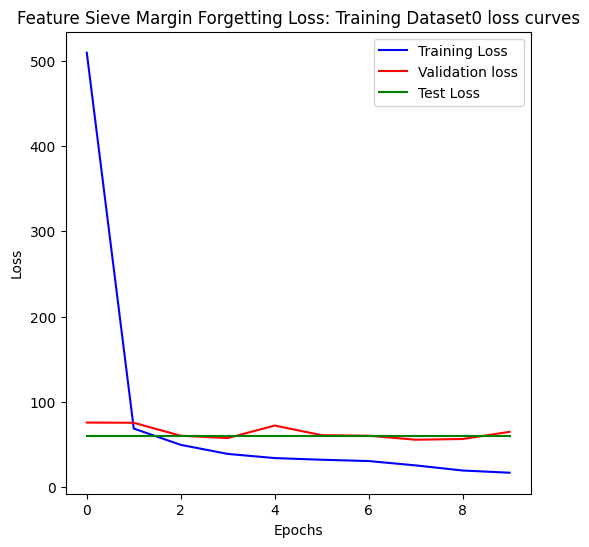

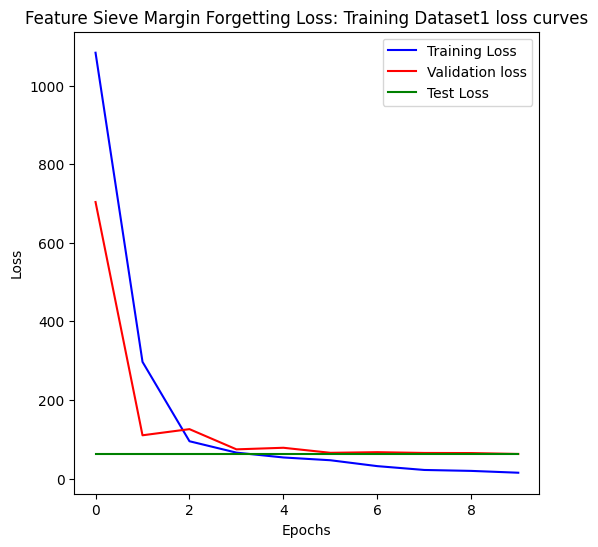

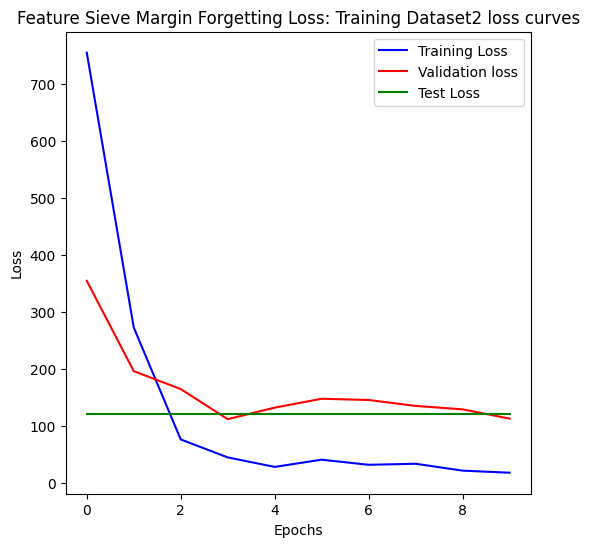

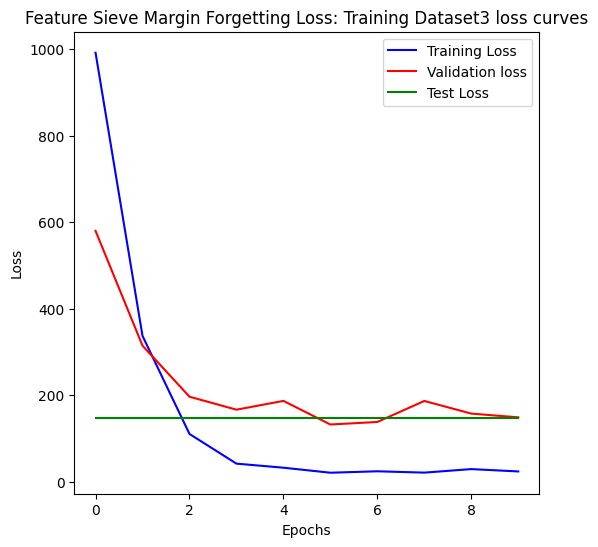

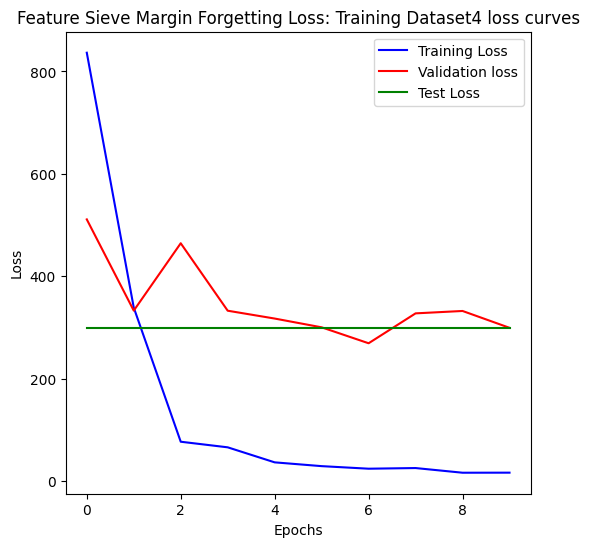

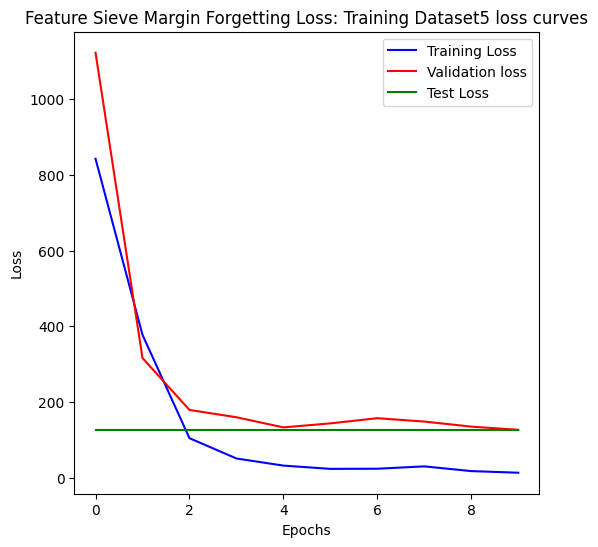

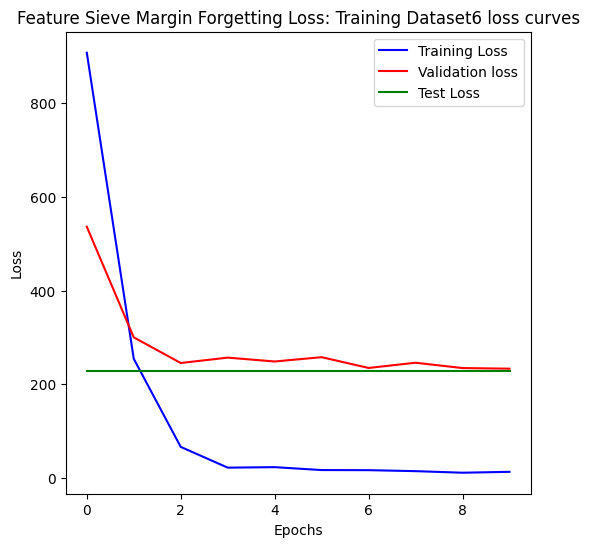

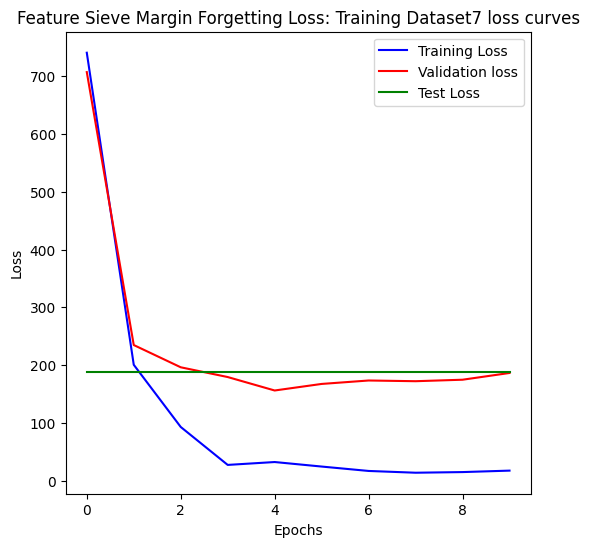

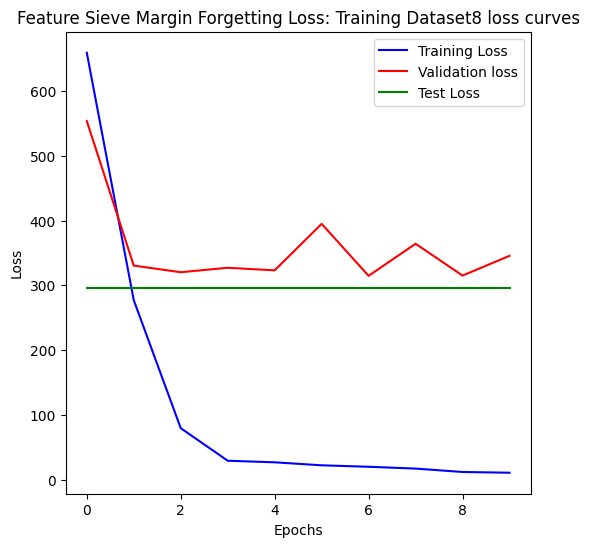

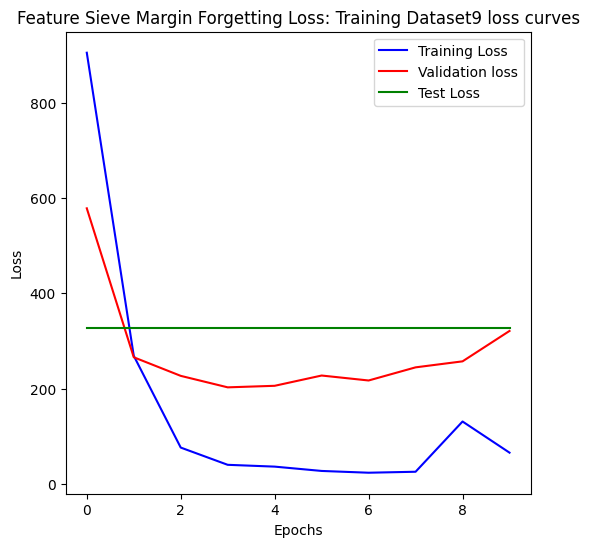

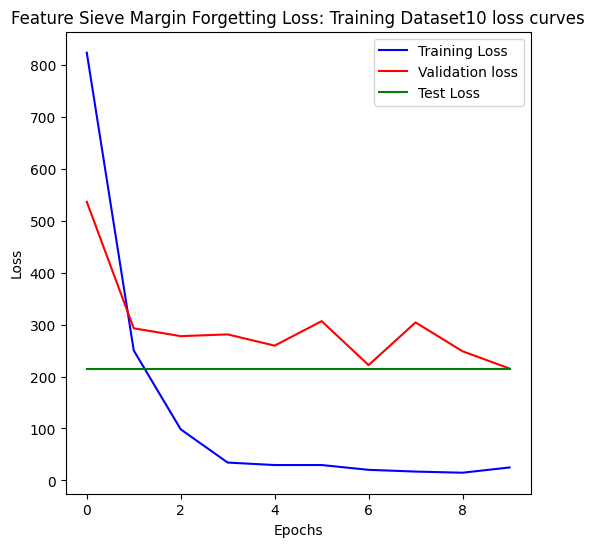

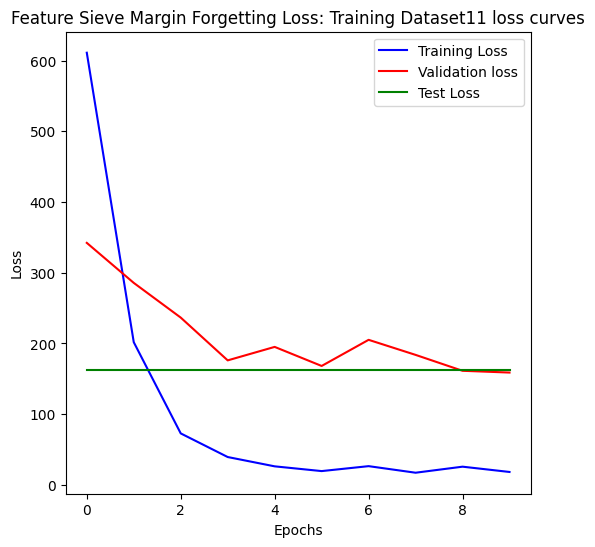

In [70]:
# plotting loss curves
plt.rcParams['figure.figsize'] = (6,6)
for i in range(len(fs_ord_tlosses)):
    plot_loss_curves(fs_ord_tlosses[i], fs_ord_vlosses[i], fs_ord_tst_losses[i], epochs = 10, model_name=f"Feature Sieve Margin Forgetting Loss: Training Dataset{i}")

### Visualization of the results

In [71]:
def bar_plot(names, dict_values, xlabel, ylabel, title, name):
    x = np.arange(len(names))
    width = 0.2
    multiplier = 0
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams.update({"font.size": 10})
    fig, ax = plt.subplots(layout="constrained")
    
    for model_type, test_loss in dict_values.items():
        offset = width*multiplier
        rects = ax.bar(x + offset, test_loss, width, label=model_type)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks(x+ width, names)
    ax.legend(loc="upper left")
    plt.title(title)
    # plt.savefig(f"./Outputs/{name}.png")
    plt.show()

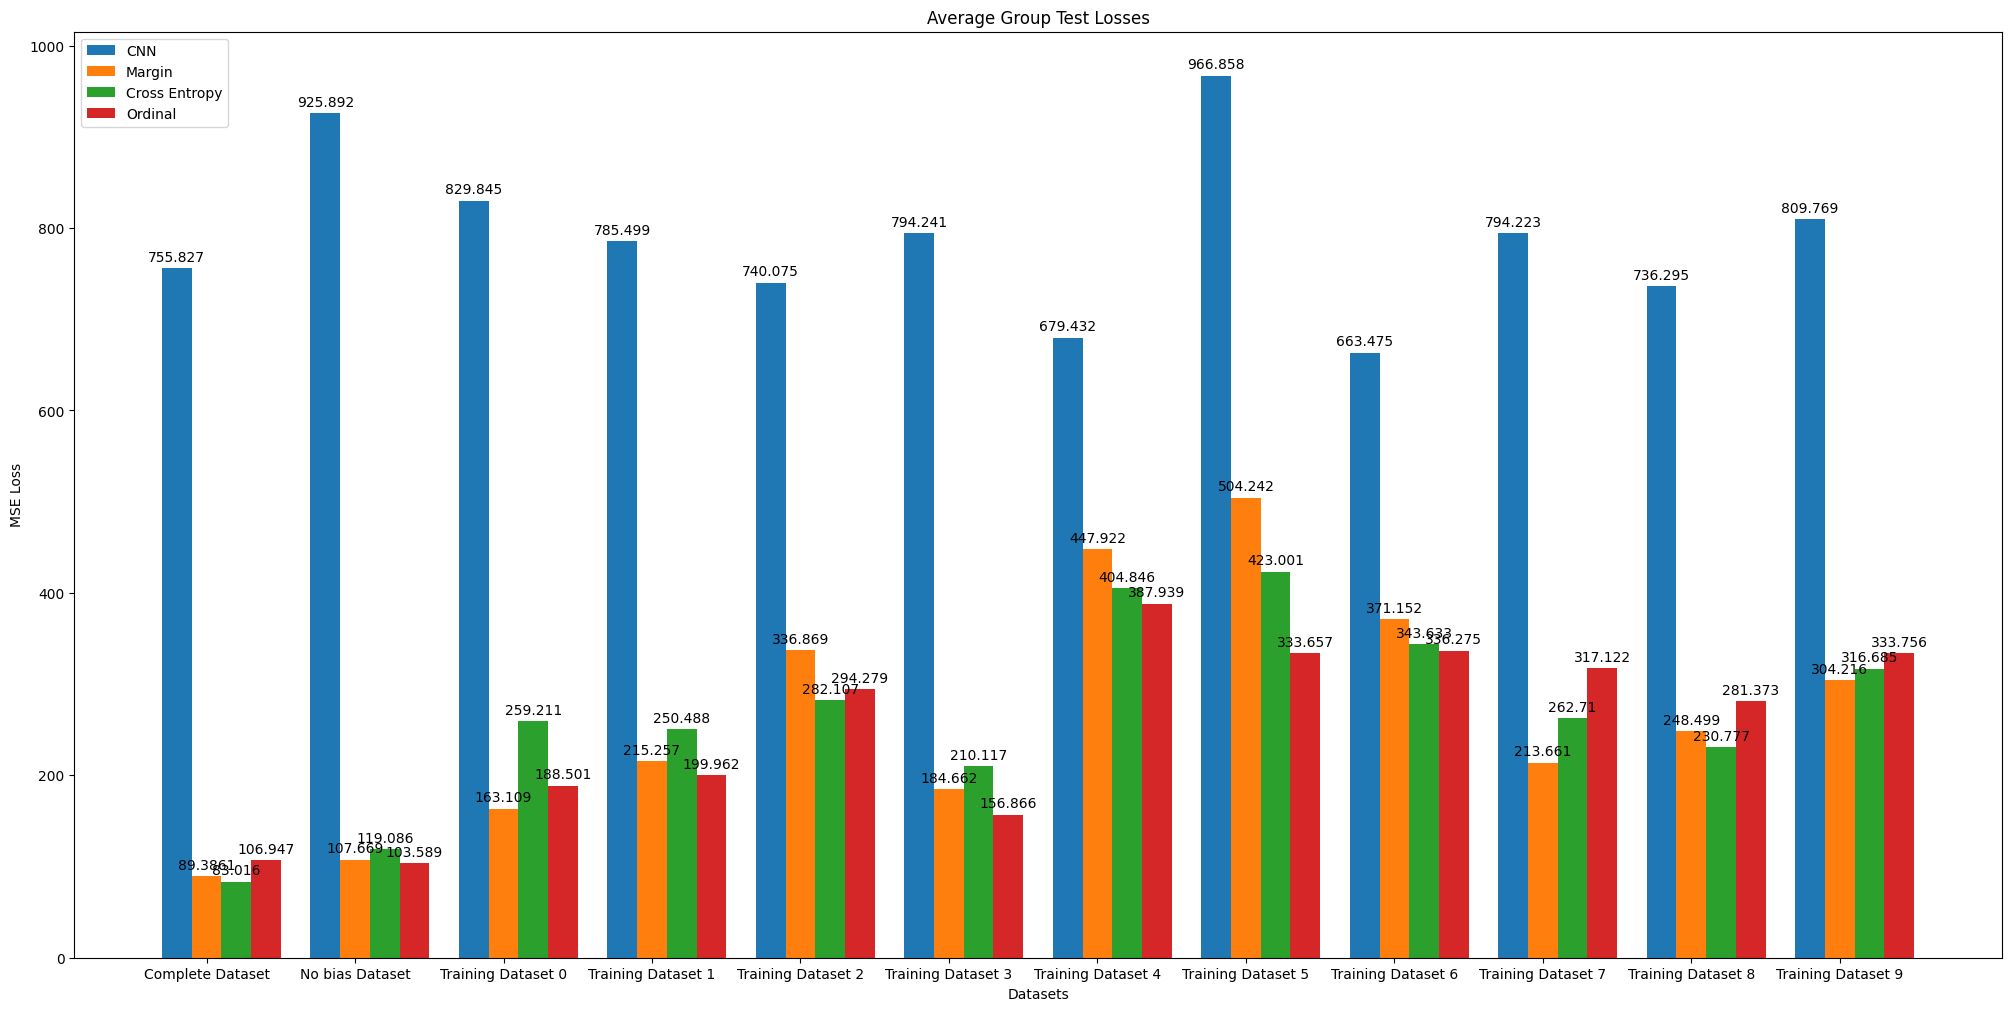

In [72]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
test_losses = {
    "CNN": grp_tst_losses,
    "Margin": fs_grp_tst_losses,
    "Cross Entropy": fs_ce_grp_tst_losses,
    "Ordinal": fs_ord_grp_tst_losses
}

bar_plot(datasets, test_losses, 'Datasets', "MSE Loss", "Average Group Test Losses", "Group_test_losses")

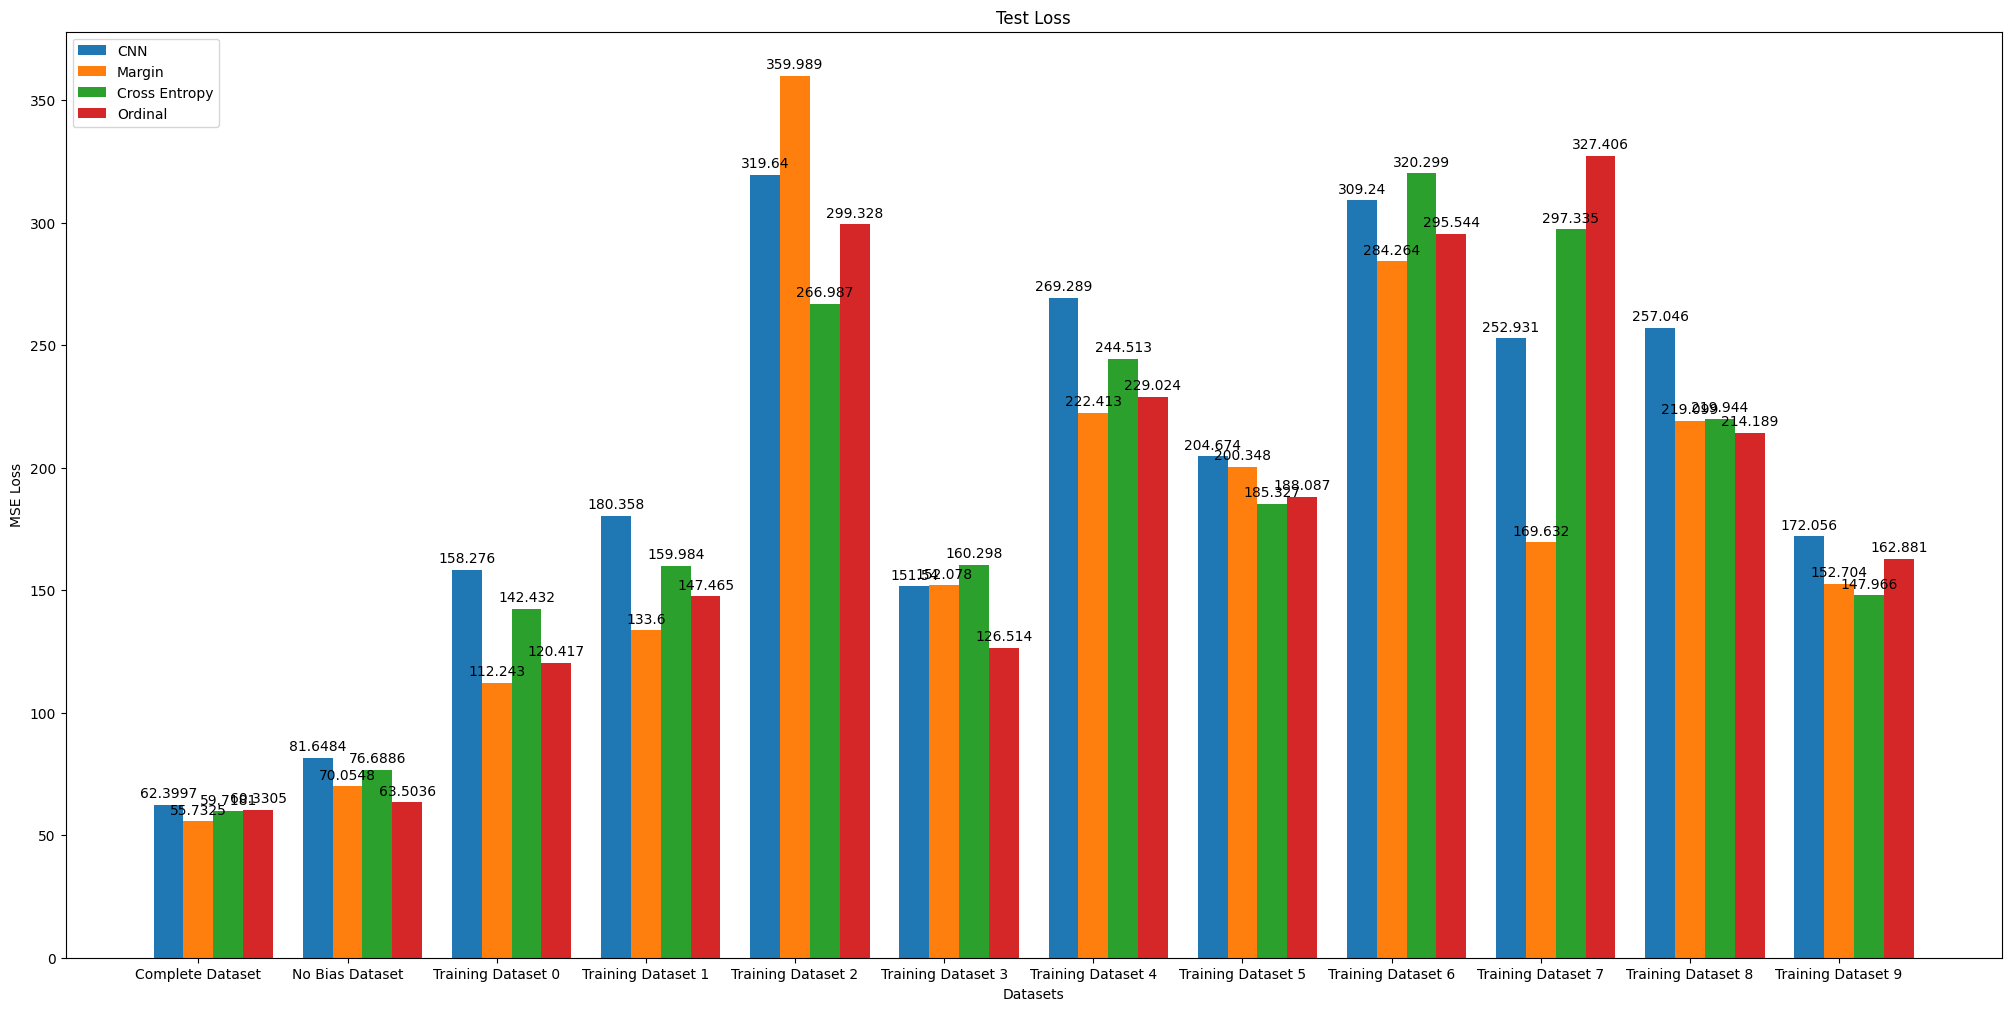

In [73]:
datasets = ["Complete Dataset", "No Bias Dataset"]  + [f"Training Dataset {i}" for i in range(10)]
test_losses = {
    "CNN": tst_losses,
    "Margin": fs_tst_losses,
    "Cross Entropy": fs_ce_tst_losses,
    "Ordinal": fs_ord_tst_losses
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Test Loss", "Test_losses")

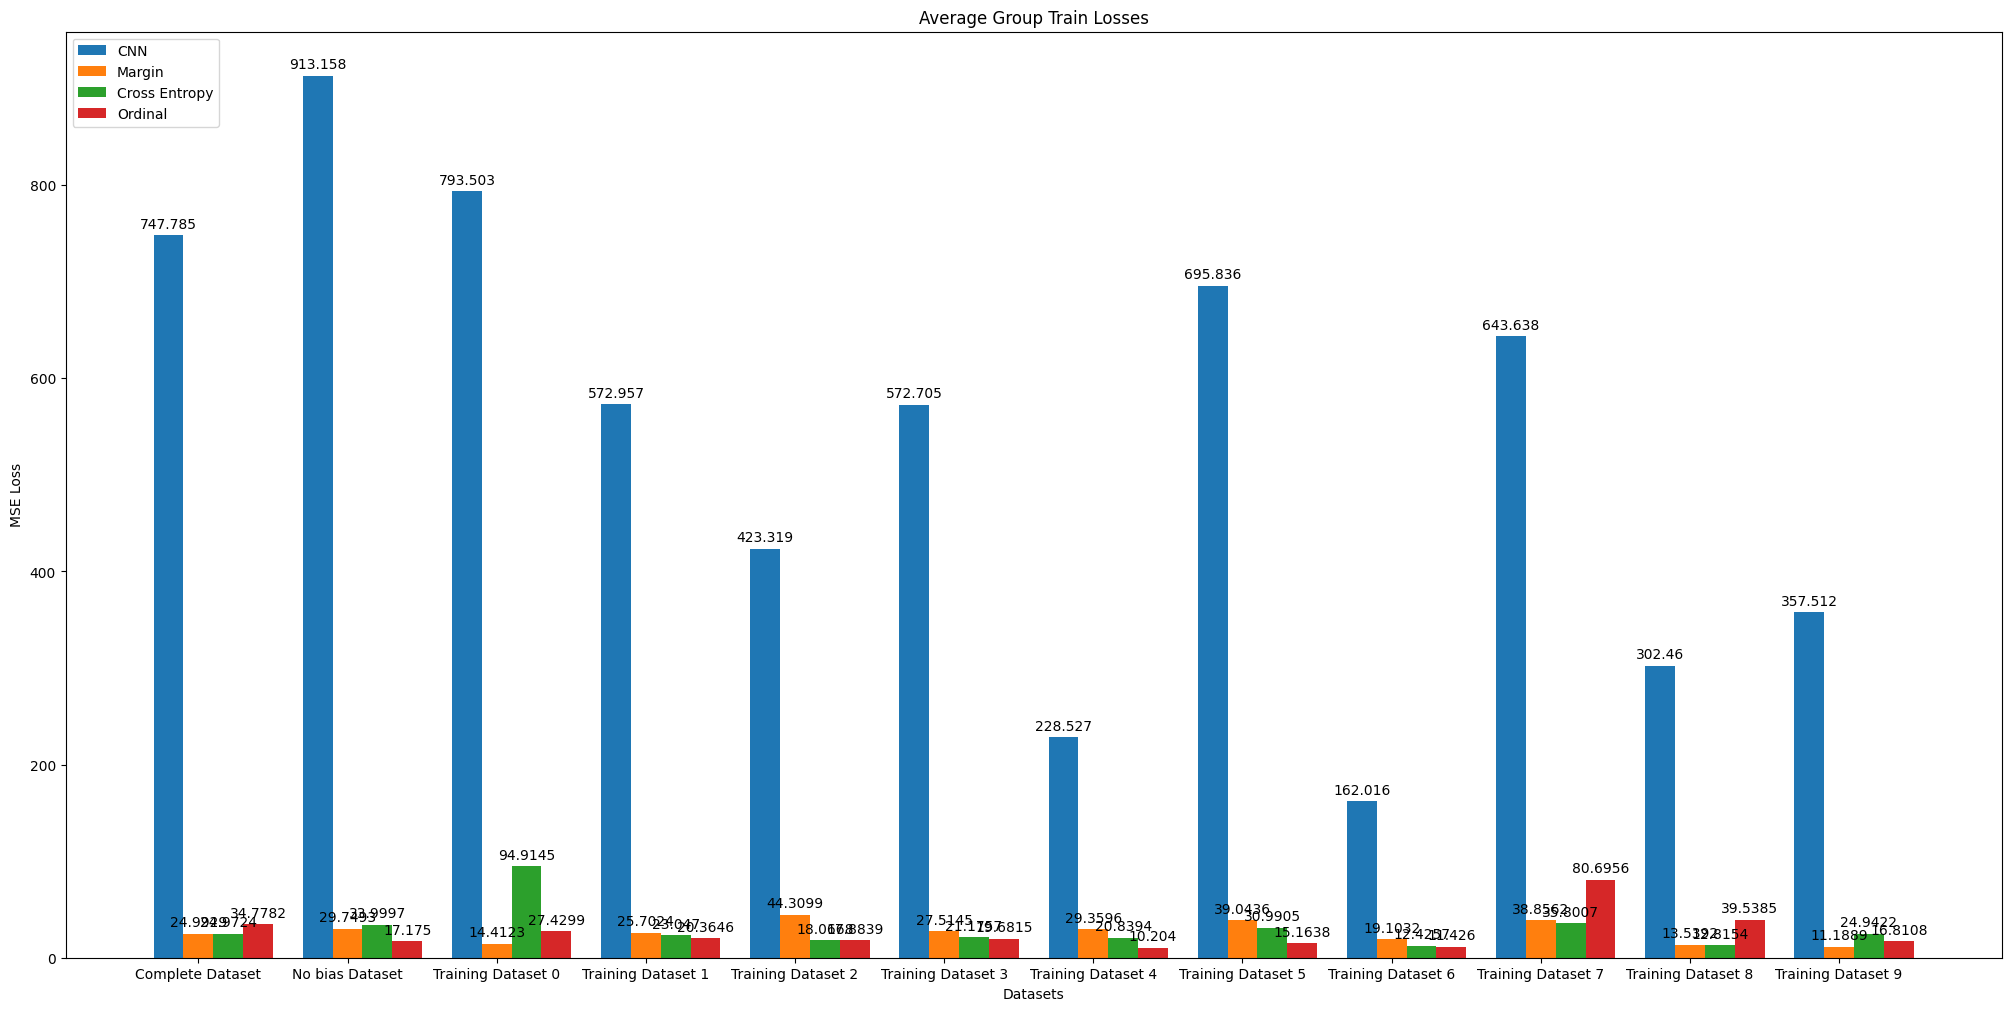

In [74]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
test_losses = {
    "CNN": grp_tst_losses_t,
    "Margin": fs_grp_tst_losses_t,
    "Cross Entropy": fs_ce_grp_tst_losses_t,
    "Ordinal": fs_ord_grp_tst_losses_t
}

bar_plot(datasets, test_losses, 'Datasets', "MSE Loss", "Average Group Train Losses", "Group_train_losses")

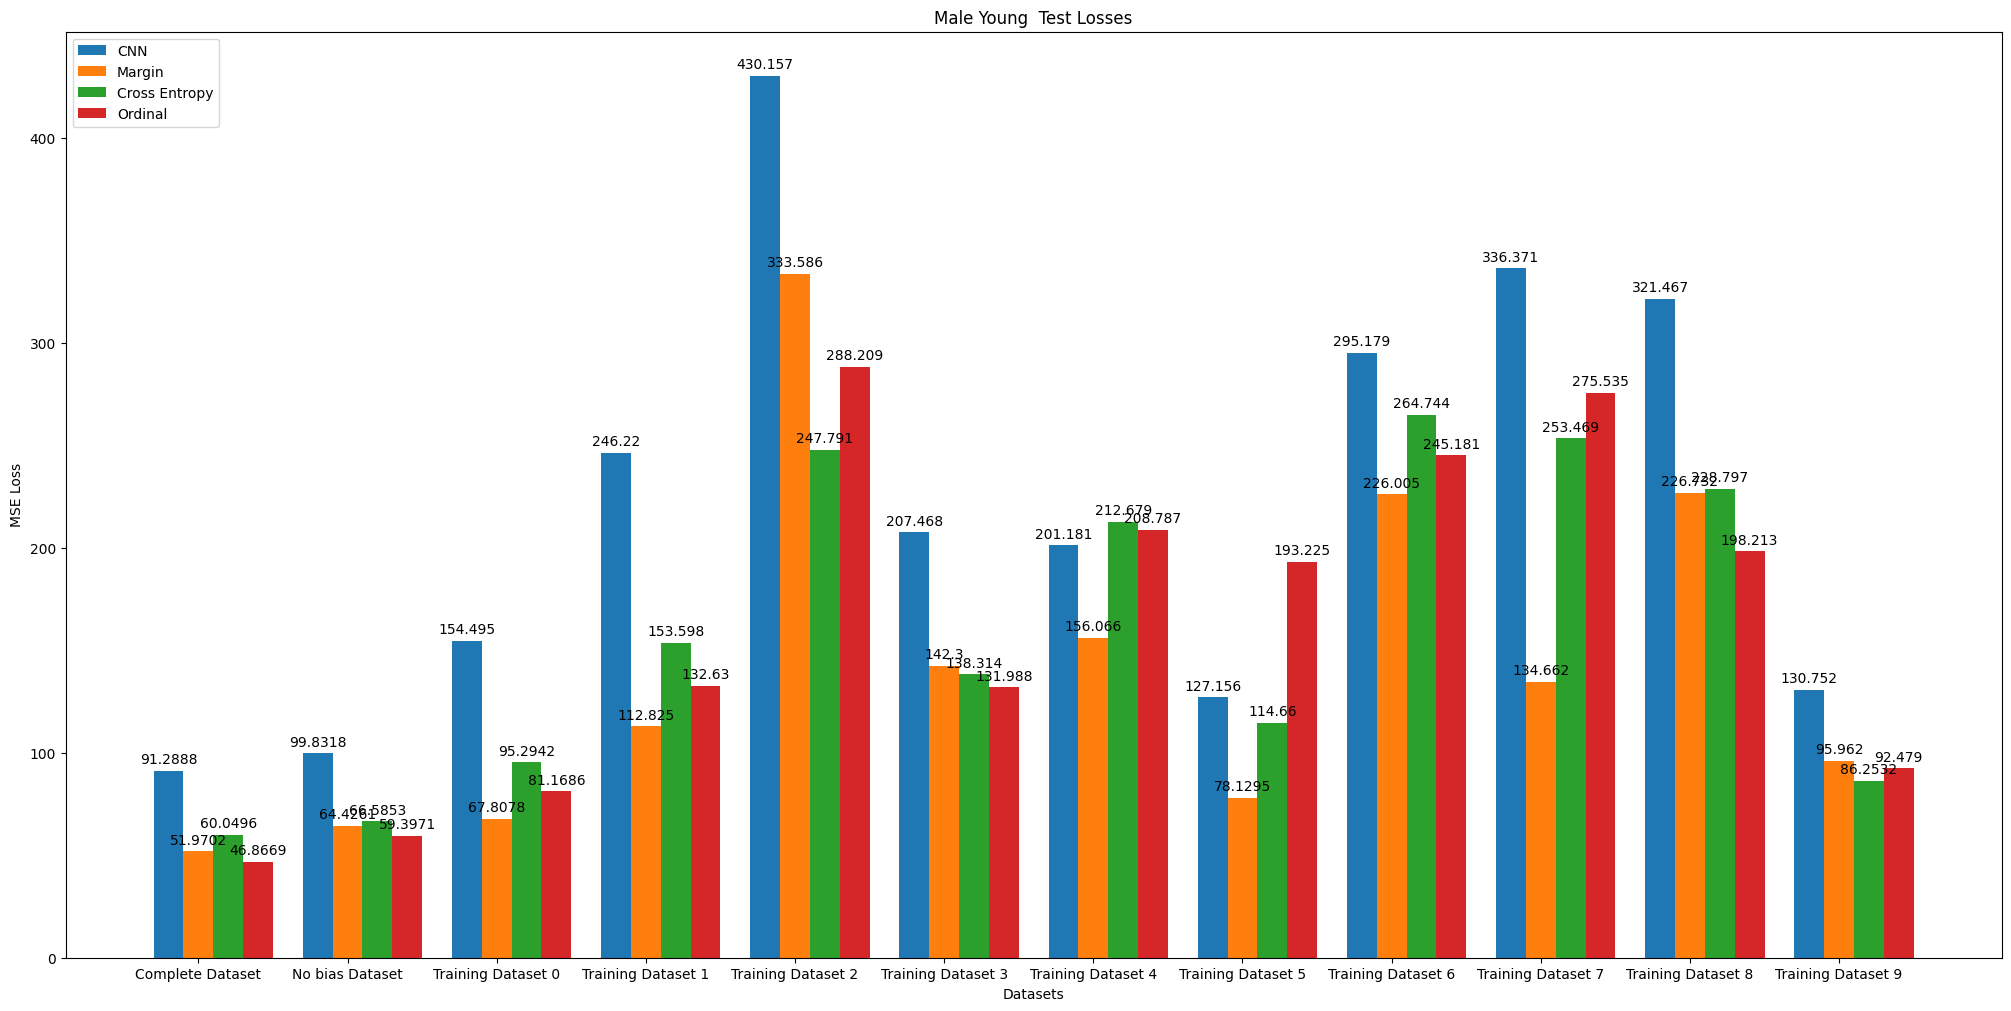

In [75]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
male_yng_test_losses = {
    "CNN": grp_wise_losses["m yng"],
    "Margin": fs_grp_wise_losses["m yng"],
    "Cross Entropy": fs_ce_grp_wise_losses["m yng"],
    "Ordinal": fs_ord_grp_wise_losses["m yng"]
}

bar_plot(datasets, male_yng_test_losses, 'Datasets', "MSE Loss", "Male Young  Test Losses", "male_yng_losses")

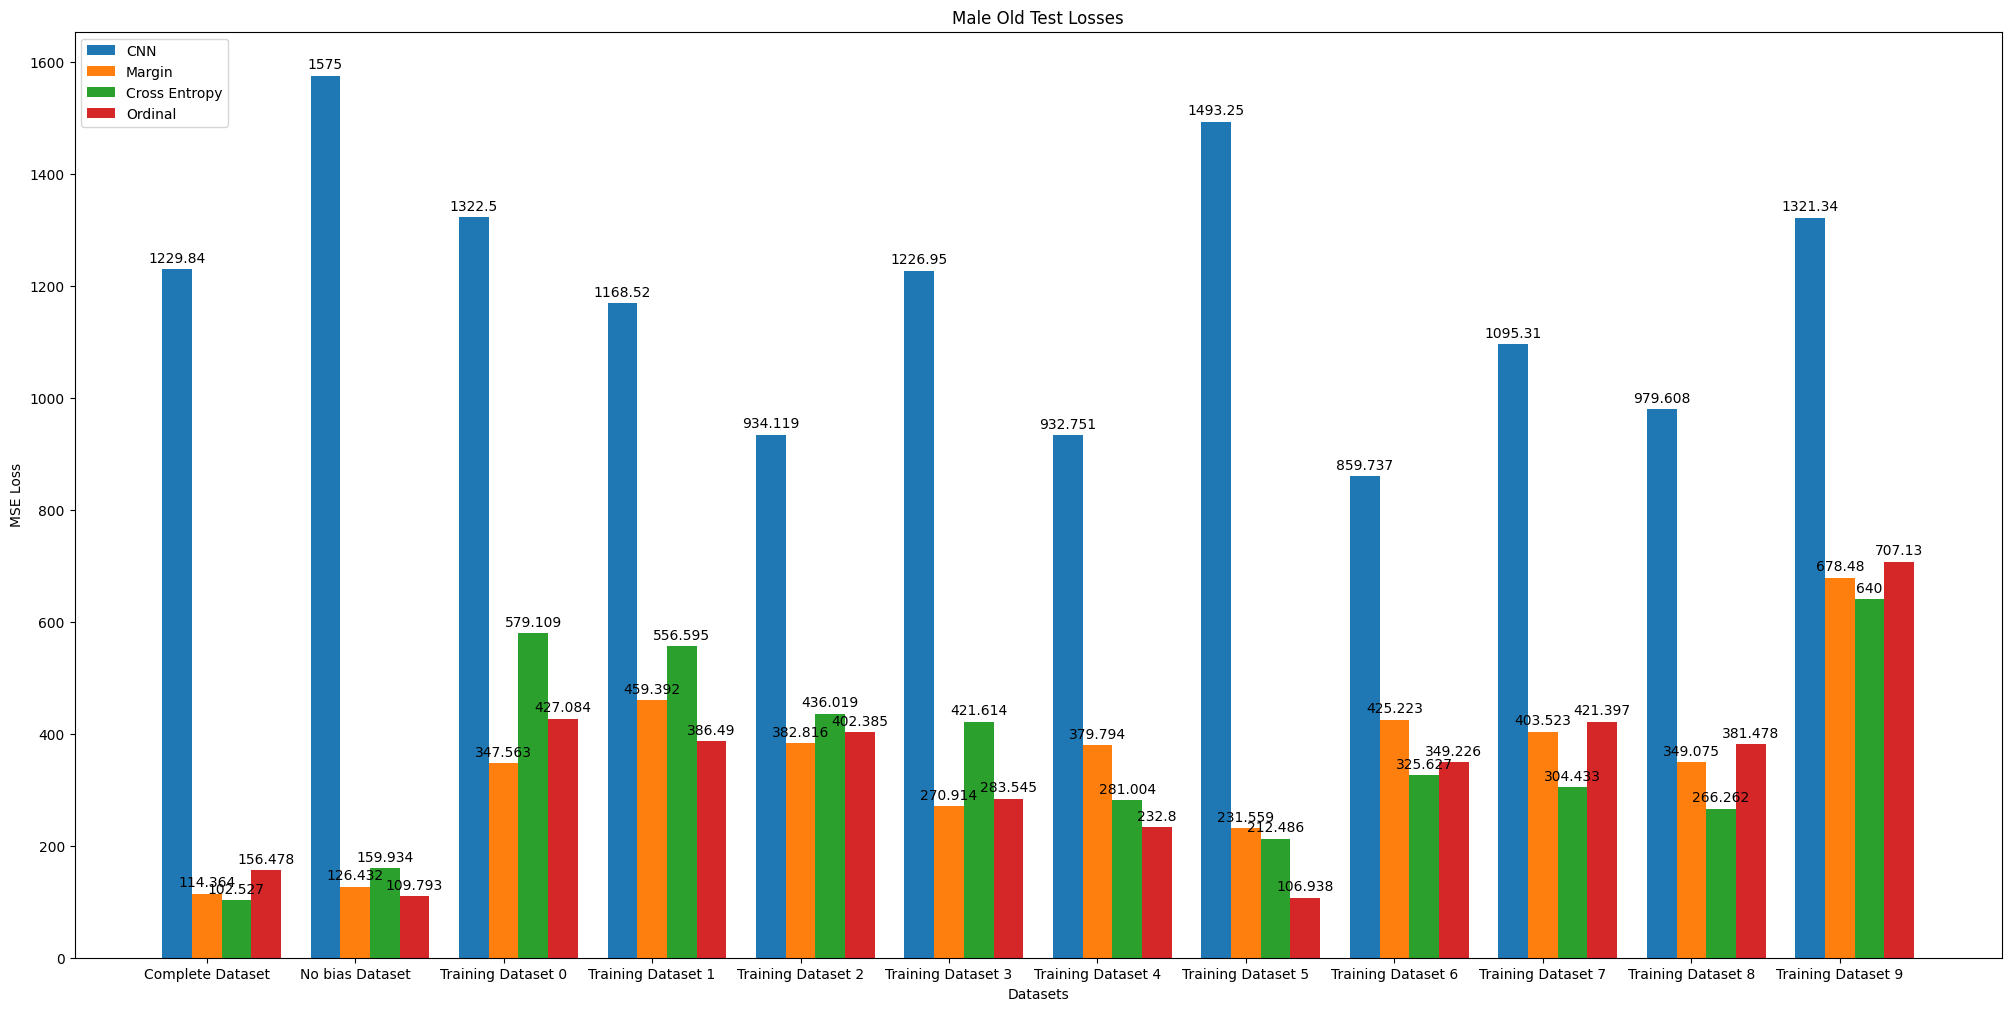

In [76]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
male_old_test_losses = {
    "CNN": grp_wise_losses["m old"],
    "Margin": fs_grp_wise_losses["m old"],
    "Cross Entropy": fs_ce_grp_wise_losses["m old"],
    "Ordinal": fs_ord_grp_wise_losses["m old"]
}

bar_plot(datasets, male_old_test_losses, 'Datasets', "MSE Loss", "Male Old Test Losses", "male_old_losses")

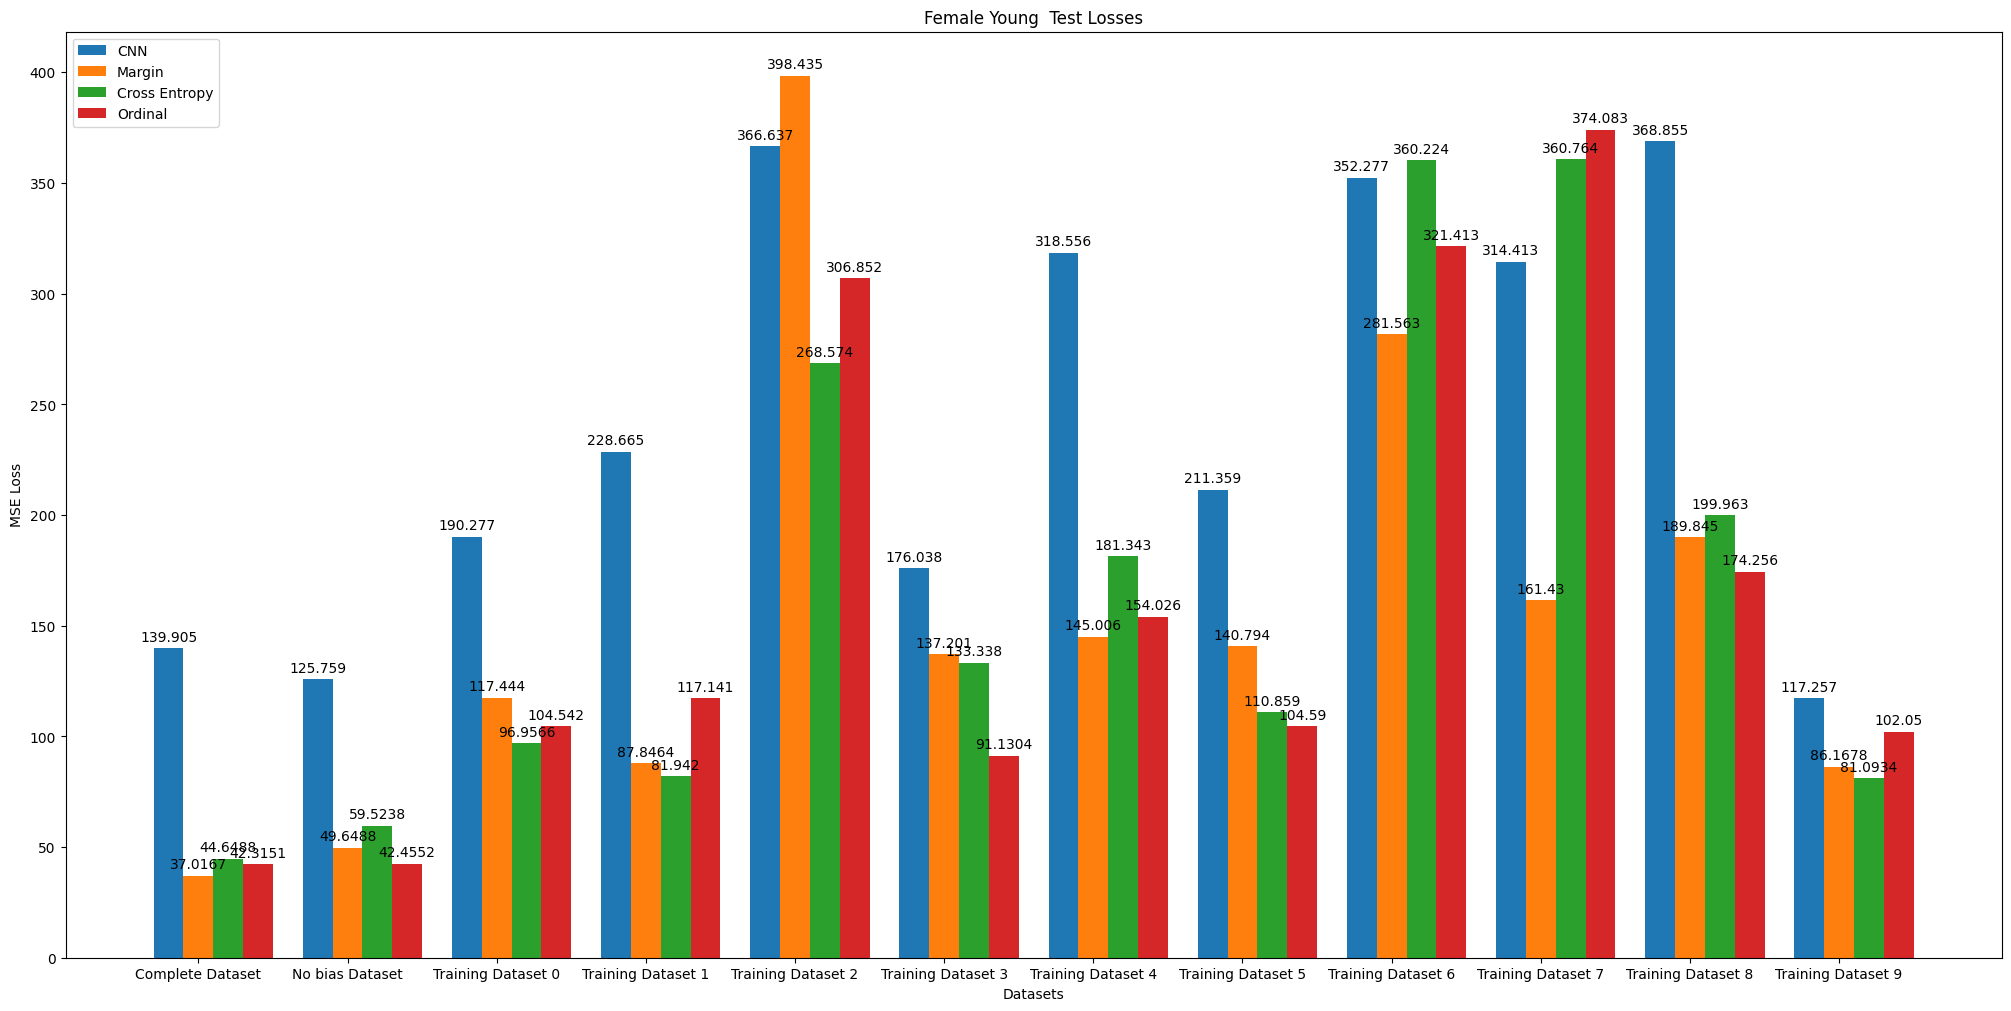

In [77]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
female_yng_test_losses = {
    "CNN": grp_wise_losses["f yng"],
    "Margin": fs_grp_wise_losses["f yng"],
    "Cross Entropy": fs_ce_grp_wise_losses["f yng"],
    "Ordinal": fs_ord_grp_wise_losses["f yng"]
}

bar_plot(datasets, female_yng_test_losses, 'Datasets', "MSE Loss", "Female Young  Test Losses", "female_yng_losses")

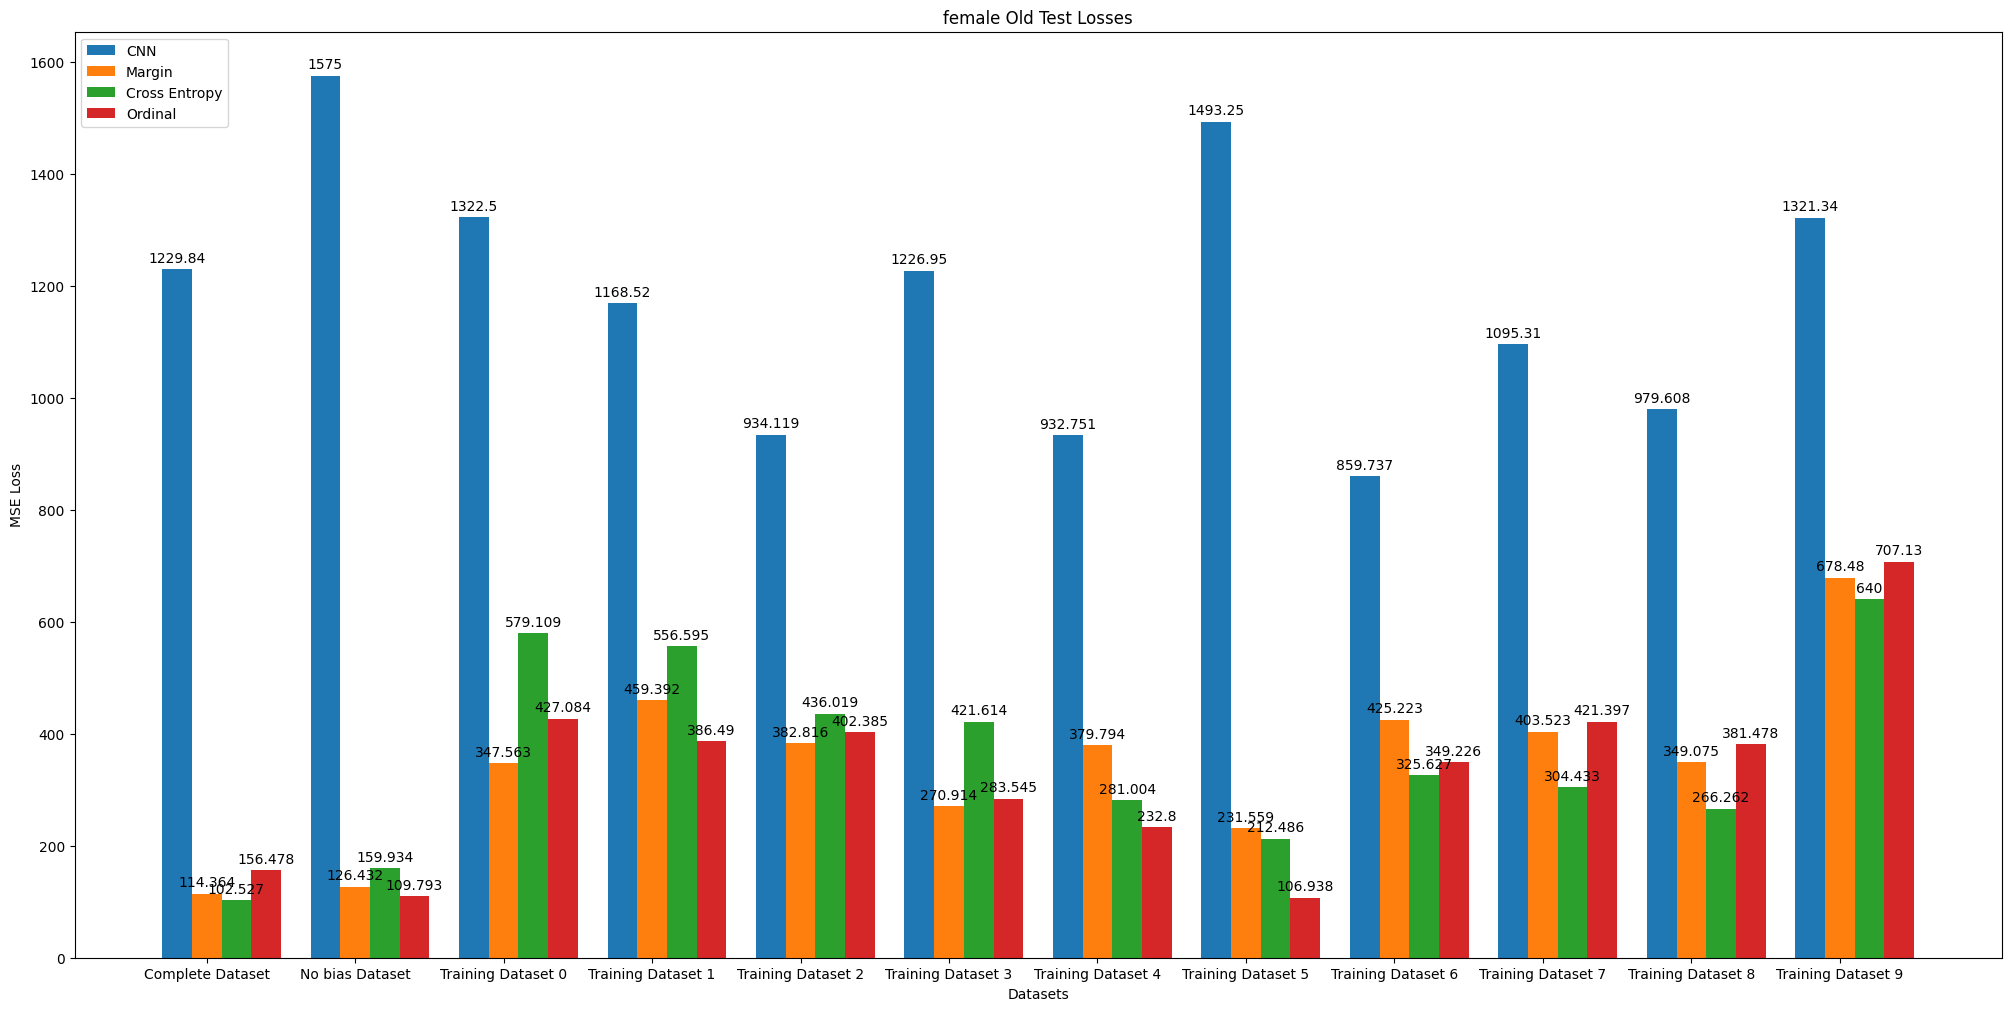

In [78]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
female_old_test_losses = {
    "CNN": grp_wise_losses["f old"],
    "Margin": fs_grp_wise_losses["f old"],
    "Cross Entropy": fs_ce_grp_wise_losses["f old"],
    "Ordinal": fs_ord_grp_wise_losses["f old"]
}

bar_plot(datasets, male_old_test_losses, 'Datasets', "MSE Loss", "female Old Test Losses", "female_old_losses")

#### Tabular form of the results
##### Test Group Losses

In [67]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
datasets_df = pd.DataFrame({"Dataset": datasets})

male_yng_test_losses_df = pd.DataFrame(male_yng_test_losses)
male_yng_test_losses_df = pd.concat([datasets_df, male_yng_test_losses_df], axis = 1).set_index("Dataset")
male_yng_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_yng_test_losses.csv")
male_yng_test_losses_df

CNN      Margin  Cross Entropy     Ordinal
Dataset                                                              
Complete Dataset     80.717720   49.377327      56.188622   43.071754
No bias Dataset     101.131180   54.017349      54.496017   71.208664
Training Dataset 0  197.230972   76.341011      76.007195   92.744896
Training Dataset 1  286.738068  138.650635     156.277756  126.948486
Training Dataset 2  460.613434  268.030853     243.747467  249.486893
Training Dataset 3  262.799988  148.667709     132.217804  125.455978
Training Dataset 4  193.363113  184.402481     214.798721  272.385437
Training Dataset 5  129.483353  118.268745     172.463470   91.919746
Training Dataset 6  311.126953  261.350708     281.655243  280.892975
Training Dataset 7  339.479401  196.980667     343.751221  215.037277
Training Dataset 8  266.416565  184.385651     248.408997  241.162216
Training Dataset 9  139.055161  114.194649     100.821579  118.480553

In [68]:
male_old_test_losses_df = pd.DataFrame(male_old_test_losses)
male_old_test_losses_df = pd.concat([datasets_df, male_old_test_losses_df], axis = 1).set_index("Dataset")
male_old_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_old_test_losses.csv")
male_old_test_losses_df

CNN      Margin  Cross Entropy     Ordinal
Dataset                                                               
Complete Dataset    1319.948120  119.569305     116.983574  143.830826
No bias Dataset     1363.826904  142.417023     129.101517  126.964035
Training Dataset 0  1282.722534  354.285034     223.019012  482.896362
Training Dataset 1  1115.593506  298.897491     339.563324  558.801758
Training Dataset 2   953.183350  348.041718     455.519897  417.468964
Training Dataset 3  1082.395020  405.921875     435.434387  181.239120
Training Dataset 4   924.480774  259.359009     298.125458  277.877075
Training Dataset 5  1592.543335  139.268250     116.416245  207.929337
Training Dataset 6   870.997620  338.091553     412.085510  415.317444
Training Dataset 7  1027.754761  290.901306     215.646027  338.538605
Training Dataset 8   980.758911  348.079620     338.686279  319.533081
Training Dataset 9  1356.348999  638.646606     552.335449  882.121521

In [69]:
female_yng_test_losses_df = pd.DataFrame(female_yng_test_losses)
female_yng_test_losses_df = pd.concat([datasets_df, female_yng_test_losses_df], axis = 1).set_index("Dataset")
female_yng_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}female_yng_test_losses.csv")
female_yng_test_losses_df

CNN      Margin  Cross Entropy     Ordinal
Dataset                                                              
Complete Dataset    135.098434   34.741402      46.476383   32.633331
No bias Dataset     167.211060   41.609108      44.325092   52.406986
Training Dataset 0  229.338425   89.126915     181.142609  123.659058
Training Dataset 1  276.937347  102.796005     138.430725   84.897667
Training Dataset 2  407.072540  322.611481     226.396561  258.354462
Training Dataset 3  247.079025  109.349808     112.399040  193.069092
Training Dataset 4  295.989197  144.224854     157.533386  160.013870
Training Dataset 5  194.718613   91.581192      89.783218  121.083359
Training Dataset 6  343.081085  401.275818     377.698303  377.383606
Training Dataset 7  323.149384  365.103760     672.192932  385.495483
Training Dataset 8  315.231323  158.024979     210.748779  200.697678
Training Dataset 9  115.666473   80.555206     105.208031   76.214928

In [70]:
female_old_test_losses_df = pd.DataFrame(female_old_test_losses)
female_old_test_losses_df = pd.concat([datasets_df, female_old_test_losses_df], axis = 1).set_index("Dataset")
female_old_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/female_old_test_losses.csv")
female_old_test_losses_df

CNN       Margin  Cross Entropy      Ordinal
Dataset                                                                 
Complete Dataset    1831.747925   185.772263     162.023285   197.133667
No bias Dataset     1847.354858   188.187637     195.177460   151.567673
Training Dataset 0  1785.772461   172.629150     131.881134   167.393967
Training Dataset 1  1580.575195   171.510361     197.214737   441.294281
Training Dataset 2  1387.901367   229.444138     195.805908   236.745636
Training Dataset 3  1547.719116   191.956757     222.396011   129.155594
Training Dataset 4  1413.325195  1024.486328    1020.327271   908.081970
Training Dataset 5  2117.394043   957.366882     782.333130  1236.915649
Training Dataset 6  1333.585938   506.487427     648.564941   593.542969
Training Dataset 7  1504.564575   115.078789     117.243126   134.843765
Training Dataset 8  1454.473999   300.781830     296.791107   242.623627
Training Dataset 9  1923.576050   392.689606     407.469635   605.783447

##### Train Group Losses

In [71]:
male_yng_train_losses = {
    "CNN": grp_wise_losses_t["m yng"],
    "Margin": fs_grp_wise_losses_t["m yng"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["m yng"],
    "Ordinal": fs_ord_grp_wise_losses_t["m yng"]
}

male_yng_train_losses_df = pd.DataFrame(male_yng_train_losses)
male_yng_train_losses_df = pd.concat([datasets_df, male_yng_train_losses_df], axis = 1).set_index("Dataset")
male_yng_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_yng_train_losses.csv")
male_yng_train_losses_df

CNN     Margin  Cross Entropy    Ordinal
Dataset                                                            
Complete Dataset     56.154255  17.459282      24.520189  15.863811
No bias Dataset      69.347321  16.379419      14.648203  21.723518
Training Dataset 0  257.558044  13.091161      17.349499  16.427153
Training Dataset 1  286.401093   8.863683       9.478614  13.476275
Training Dataset 2  150.067993  16.295965      17.503534  13.969060
Training Dataset 3  244.169632   8.201126      17.553797  20.692245
Training Dataset 4  139.213135  15.086378      11.275716  19.378729
Training Dataset 5  607.390930  11.782673      14.386482  24.332899
Training Dataset 6   33.295372  12.921011      13.754068   8.166376
Training Dataset 7  108.046906  13.496071      38.741261  18.435493
Training Dataset 8   38.428307  16.848328       7.701077   9.362974
Training Dataset 9  116.261215  11.043303      10.427846  10.406708

In [72]:
male_old_train_losses = {
    "CNN": grp_wise_losses_t["m old"],
    "Margin": fs_grp_wise_losses_t["m old"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["m old"],
    "Ordinal": fs_ord_grp_wise_losses_t["m old"]
}

male_old_train_losses_df = pd.DataFrame(male_old_train_losses)
male_old_train_losses_df = pd.concat([datasets_df, male_old_train_losses_df], axis = 1).set_index("Dataset")
male_old_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_old_train_losses.csv")
male_old_train_losses_df

CNN     Margin  Cross Entropy    Ordinal
Dataset                                                             
Complete Dataset    1332.749512  35.628407      45.208115  62.960747
No bias Dataset     1366.267212  20.649174      28.013496  51.592449
Training Dataset 0     0.000000   0.000000       0.000000   0.000000
Training Dataset 1     0.000000   0.000000       0.000000   0.000000
Training Dataset 2     0.000000   0.000000       0.000000   0.000000
Training Dataset 3     0.000000   0.000000       0.000000   0.000000
Training Dataset 4   429.749573  21.109034      25.042362  14.137608
Training Dataset 5  1271.039429  30.655212      20.939932  66.229065
Training Dataset 6     0.000000   0.000000       0.000000   0.000000
Training Dataset 7     0.000000   0.000000       0.000000   0.000000
Training Dataset 8     0.000000   0.000000       0.000000   0.000000
Training Dataset 9     0.000000   0.000000       0.000000   0.000000

In [73]:
female_yng_train_losses = {
    "CNN": grp_wise_losses_t["f yng"],
    "Margin": fs_grp_wise_losses_t["f yng"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["f yng"],
    "Ordinal": fs_ord_grp_wise_losses_t["f yng"]
}

female_yng_train_losses_df = pd.DataFrame(female_yng_train_losses)
female_yng_train_losses_df = pd.concat([datasets_df, female_yng_train_losses_df], axis = 1).set_index("Dataset")
female_yng_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/female_yng_train_losses.csv")
female_yng_train_losses_df

CNN     Margin  Cross Entropy    Ordinal
Dataset                                                            
Complete Dataset    110.216789  15.864799      24.203491  14.125878
No bias Dataset     128.703400  16.703503      14.994602  22.517033
Training Dataset 0  567.874084  28.454065      52.496269  59.736431
Training Dataset 1  144.093414  16.827362      21.010977  56.346313
Training Dataset 2   78.965103  13.095757      36.300880  35.175026
Training Dataset 3   91.283806  19.061588      27.447344  40.338711
Training Dataset 4  119.159958  10.896475       9.935986  10.711398
Training Dataset 5  346.684570   5.251101       6.227899   8.530180
Training Dataset 6   84.926186  19.632362      11.160574   7.403625
Training Dataset 7  355.217377  15.600179      69.602280  26.067915
Training Dataset 8   46.037945  21.620611      16.189407  16.260523
Training Dataset 9  127.026031  16.672802      15.218842  29.676287

In [74]:
female_old_train_losses = {
    "CNN": grp_wise_losses_t["f old"],
    "Margin": fs_grp_wise_losses_t["f old"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["f old"],
    "Ordinal": fs_ord_grp_wise_losses_t["f old"]
}

female_old_train_losses_df = pd.DataFrame(female_old_train_losses)
female_old_train_losses_df = pd.concat([datasets_df, female_old_train_losses_df], axis = 1).set_index("Dataset")
female_old_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/female_old_train_losses.csv")
female_old_train_losses_df

CNN     Margin  Cross Entropy     Ordinal
Dataset                                                              
Complete Dataset    1681.908813  40.365135      43.171452   59.597340
No bias Dataset     1730.914795  21.716906      35.460251   55.969654
Training Dataset 0  1577.046143  46.902534      25.988798   49.919895
Training Dataset 1  1259.415894  20.218769      43.495716  237.888367
Training Dataset 2  1004.397217  62.200550      29.262842   67.579231
Training Dataset 3  1242.571289  34.161224      58.017712   18.750847
Training Dataset 4     0.000000   0.000000       0.000000    0.000000
Training Dataset 5     0.000000   0.000000       0.000000    0.000000
Training Dataset 6   386.665253   9.995540      38.476719   17.390530
Training Dataset 7  1310.455566  15.102396      46.055046   26.819221
Training Dataset 8   773.883484  22.257360      21.557379   15.900480
Training Dataset 9   894.541748  11.890709      20.557335   66.641312

In [75]:
grp_train_losses_df = {
    "CNN": grp_tst_losses_t,
    "Margin": fs_grp_tst_losses_t,
    "Cross Entropy": fs_ce_grp_tst_losses_t,
    "Ordinal": fs_ord_grp_tst_losses_t
}

grp_train_losses_df = pd.DataFrame(grp_train_losses_df)
grp_train_losses_df = pd.concat([datasets_df, grp_train_losses_df], axis = 1).set_index("Dataset")
grp_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/grp_train_losses.csv")
grp_train_losses_df

CNN     Margin  Cross Entropy     Ordinal
Dataset                                                             
Complete Dataset    795.257342  27.329406      34.275812   38.136944
No bias Dataset     823.808182  18.862250      23.279138   37.950664
Training Dataset 0  800.826090  29.482587      31.944855   42.027826
Training Dataset 1  563.303467  15.303271      24.661769  102.570319
Training Dataset 2  411.143438  30.530758      27.689086   38.907772
Training Dataset 3  526.008242  20.474646      34.339617   26.593934
Training Dataset 4  229.374222  15.697296      15.418021   14.742578
Training Dataset 5  741.704976  15.896329      13.851438   33.030715
Training Dataset 6  168.295603  14.182971      21.130454   10.986843
Training Dataset 7  591.239950  14.732882      51.466195   23.774210
Training Dataset 8  286.116578  20.242100      15.149288   13.841326
Training Dataset 9  379.276332  13.202271      15.401341   35.574769

In [76]:
grp_test_losses_df = {
    "CNN": grp_tst_losses,
    "Margin": fs_grp_tst_losses,
    "Cross Entropy": fs_ce_grp_tst_losses,
    "Ordinal": fs_ord_grp_tst_losses
}

grp_test_losses_df = pd.DataFrame(grp_test_losses_df)
grp_test_losses_df = pd.concat([datasets_df, grp_test_losses_df], axis = 1).set_index("Dataset")
grp_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/grp_test_losses.csv")
grp_test_losses_df

CNN      Margin  Cross Entropy     Ordinal
Dataset                                                               
Complete Dataset     841.878050   97.365074      95.417966  104.167395
No bias Dataset      869.881001  106.557779     105.775022  100.536839
Training Dataset 0   873.766098  173.095528     153.012487  216.673571
Training Dataset 1   814.961029  177.963623     207.871635  302.985548
Training Dataset 2   802.192673  292.032047     280.367458  290.513988
Training Dataset 3   784.998287  213.974037     225.611811  157.229946
Training Dataset 4   706.789570  403.118168     422.696209  404.589588
Training Dataset 5  1008.534836  326.621267     290.249016  414.462023
Training Dataset 6   714.697899  376.801376     430.000999  416.784248
Training Dataset 7   798.737030  242.016130     337.208326  268.478783
Training Dataset 8   754.220200  247.818020     273.658791  251.004150
Training Dataset 9   883.661671  306.521517     291.458673  420.650112

In [77]:
test_losses_df = {
    "CNN": tst_losses,
    "Margin": fs_tst_losses,
    "Cross Entropy": fs_ce_tst_losses,
    "Ordinal": fs_ord_tst_losses
}

test_losses_df = pd.DataFrame(test_losses_df)
test_losses_df = pd.concat([datasets_df, test_losses_df], axis = 1).set_index("Dataset")
test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/test_losses.csv")
test_losses_df

CNN      Margin  Cross Entropy     Ordinal
Dataset                                                              
Complete Dataset     67.578041   55.740929      63.359589   55.566673
No bias Dataset      83.494064   62.625957      63.828548   72.654579
Training Dataset 0  157.505310  109.656693     136.204407  142.126602
Training Dataset 1  182.645782  138.978928     166.223724  162.559860
Training Dataset 2  314.756683  295.195526     252.475616  267.122711
Training Dataset 3  187.615555  155.971069     153.651901  156.455399
Training Dataset 4  249.088776  217.669510     240.166626  259.609772
Training Dataset 5  209.050049  151.837784     165.887177  172.351135
Training Dataset 6  333.303955  337.900299     350.668976  348.934814
Training Dataset 7  274.371246  269.771790     459.254791  295.074188
Training Dataset 8  269.741913  192.877228     239.979065  232.409454
Training Dataset 9  189.167862  158.204544     155.708923  187.333496

In [2]:
grp = pd.read_csv('./Outputs/Losses/SEED_3407/grp_test_losses.csv')
grp

Dataset          CNN      Margin  Cross Entropy     Ordinal
0     Complete Dataset   769.491482   83.975795      85.490667   80.189699
1      No bias Dataset   890.259041  111.798407     171.604198   91.291381
2   Training Dataset 0   866.309467  210.243759     174.206036  184.826660
3   Training Dataset 1   750.750488  217.775373     187.176659  217.417835
4   Training Dataset 2   764.359947  299.401611     306.167168  266.106148
5   Training Dataset 3   802.131741  211.571367     195.235149  204.913778
6   Training Dataset 4   707.288918  430.714401     412.557117  434.898460
7   Training Dataset 5  1053.085648  273.585964     307.172892  343.826033
8   Training Dataset 6   677.709679  337.799671     357.095490  322.706829
9   Training Dataset 7   796.981911  237.904930     267.195827  282.417973
10  Training Dataset 8   750.859406  240.250786     286.359913  302.692181
11  Training Dataset 9   849.786266  301.678919     322.196243  365.150398

In [3]:
grp['Margin'] = (grp['Margin'] - grp['CNN']) / grp['CNN'] * 100
grp['Cross Entropy'] = (grp['Cross Entropy'] - grp['CNN']) / grp['CNN'] * 100
grp['Ordinal'] = (grp['Ordinal'] - grp['CNN']) / grp['CNN'] * 100
grp

Dataset          CNN     Margin  Cross Entropy    Ordinal
0     Complete Dataset   769.491482 -89.086845     -88.889979 -89.578871
1      No bias Dataset   890.259041 -87.442036     -80.724240 -89.745526
2   Training Dataset 0   866.309467 -75.731102     -79.891016 -78.665054
3   Training Dataset 1   750.750488 -70.992310     -75.068060 -71.039934
4   Training Dataset 2   764.359947 -60.829762     -59.944635 -65.185755
5   Training Dataset 3   802.131741 -73.623863     -75.660463 -74.453850
6   Training Dataset 4   707.288918 -39.103471     -41.670637 -38.511908
7   Training Dataset 5  1053.085648 -74.020540     -70.831158 -67.350611
8   Training Dataset 6   677.709679 -50.155696     -47.308486 -52.382733
9   Training Dataset 7   796.981911 -70.149269     -66.474041 -64.564067
10  Training Dataset 8   750.859406 -68.003226     -61.862379 -59.687236
11  Training Dataset 9   849.786266 -64.499436     -62.085026 -57.030325